# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|████████████████████████████████████████████████████████| 60.0K/60.0K [00:39<00:00, 1.52KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

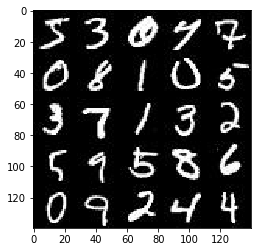

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

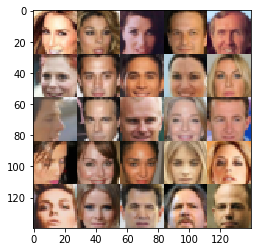

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


C:\Users\Anna\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [44]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    r_input  = tf.placeholder(tf.float32, (None,image_width, image_height, image_channels), name='r_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_r = tf.placeholder(dtype=tf.float32, name='learning_r')
    return r_input , z_input, learning_r


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\Users\\Anna\\Anaconda3\\envs\\py36\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\Users\\Anna\\Anaconda3\\envs\\py36\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\Users\\Anna\\Anaconda3\\envs\\py36\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "C:\\Users\\Anna\\Anaconda3\\envs\\py36\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\Users\\Anna\\Anaconda3\\envs\\py36\\lib\\site-packages\\ipykernel\\kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "C:\\Users\\Anna\\A

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        l1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * l1, l1)
        # 16x16x64
        
        l2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        l2 = tf.layers.batch_normalization(l2, training=True)
        relu2 = tf.maximum(alpha * l2, l2)
        # 8x8x128
        
        l3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        l3 = tf.layers.batch_normalization(l3, training=True)
        relu3 = tf.maximum(alpha * l3, l3)
        # 4x4x256
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        #dropout_layer = tf.layers.dropout(inputs=flat, rate=dropout)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        
    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
 

    with tf.variable_scope('generator', reuse= not is_train):
        l1 = tf.layers.dense(z, 3*3*512)
        l1 = tf.reshape(l1, (-1, 3, 3, 512))
        l1 = tf.layers.batch_normalization(l1, training=is_train)
        l1 = tf.maximum(alpha * l1, l1)
        # 3x3x512
        
        l2 = tf.layers.conv2d_transpose(l1, 256, kernel_size=4, strides=2, padding='same')
        l2 = tf.layers.batch_normalization(l2, training=is_train)
        l2 = tf.maximum(alpha * l2, l2)
        # 6x6x256
        
        l3 = tf.layers.conv2d_transpose(l2, 128, kernel_size=4, strides=2, padding='valid')
        l3 = tf.layers.batch_normalization(l3, training=is_train)
        l3 = tf.maximum(alpha * l3, l3)
        #14x14x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(l3, out_channel_dim, kernel_size=5,strides=2, padding='same')
        out = tf.tanh(logits)
        # 28x28x5
        
        return out
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [36]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
#    print(input_real.shape)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False,alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [47]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #saver = tf.train.Saver()
    #sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    steps = 0
   
    print_step = 10
    show_step = 100
    alpha = 0.2
    images_to_show = 9
    losses =[]

    _, width, height, channels = data_shape
    print(data_shape)
    
    r_input, z_input, learning_r = model_inputs(width, height, channels, z_dim)
    print('model input evaluated')
    print(r_input.shape)
    d_loss, g_loss = model_loss(r_input, z_input, channels, alpha = alpha)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_r, beta1)
    
    print('training...')
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = 2*batch_images
                # Random Noise as input
                z_batch = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={r_input : batch_images, z_input: z_batch, learning_r: learning_rate})
                # Let the generator run twice, so that the discriminator does not converge that fast.
                _ = sess.run(g_opt, feed_dict={z_input: z_batch, r_input : batch_images, learning_r: learning_rate})
                
                if steps % print_step == 0:
                    train_loss_d = d_loss.eval({z_input: z_batch, r_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_batch})
                    
                    print("Step: {}:".format(steps),
                          "Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_step == 0:
                    show_generator_output(sess, images_to_show, z_input, channels, data_image_mode)
        #saver.save(sess, './checkpoints/generator.ckpt')
    print("Training finished")                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
model input evaluated
(?, 28, 28, 1)
training...
Step: 10: Epoch 1/2... Discriminator Loss: 4.5246... Generator Loss: 0.0141
Step: 20: Epoch 1/2... Discriminator Loss: 1.5945... Generator Loss: 3.2732
Step: 30: Epoch 1/2... Discriminator Loss: 0.8160... Generator Loss: 2.1300
Step: 40: Epoch 1/2... Discriminator Loss: 1.9401... Generator Loss: 0.1872
Step: 50: Epoch 1/2... Discriminator Loss: 0.6848... Generator Loss: 1.5699
Step: 60: Epoch 1/2... Discriminator Loss: 0.4322... Generator Loss: 2.7270
Step: 70: Epoch 1/2... Discriminator Loss: 2.0954... Generator Loss: 0.2062
Step: 80: Epoch 1/2... Discriminator Loss: 1.2109... Generator Loss: 0.5417
Step: 90: Epoch 1/2... Discriminator Loss: 0.6478... Generator Loss: 1.8053
Step: 100: Epoch 1/2... Discriminator Loss: 0.7937... Generator Loss: 1.8659


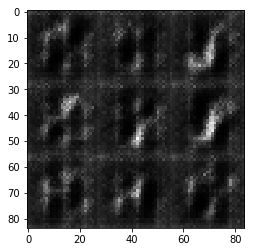

Step: 110: Epoch 1/2... Discriminator Loss: 1.0040... Generator Loss: 0.7807
Step: 120: Epoch 1/2... Discriminator Loss: 1.0993... Generator Loss: 0.6176
Step: 130: Epoch 1/2... Discriminator Loss: 1.0465... Generator Loss: 0.7366
Step: 140: Epoch 1/2... Discriminator Loss: 1.5195... Generator Loss: 0.5006
Step: 150: Epoch 1/2... Discriminator Loss: 1.7786... Generator Loss: 0.2782
Step: 160: Epoch 1/2... Discriminator Loss: 1.3124... Generator Loss: 1.3335
Step: 170: Epoch 1/2... Discriminator Loss: 1.9887... Generator Loss: 0.1989
Step: 180: Epoch 1/2... Discriminator Loss: 1.1762... Generator Loss: 0.5372
Step: 190: Epoch 1/2... Discriminator Loss: 0.7833... Generator Loss: 1.3705
Step: 200: Epoch 1/2... Discriminator Loss: 1.1882... Generator Loss: 0.5366


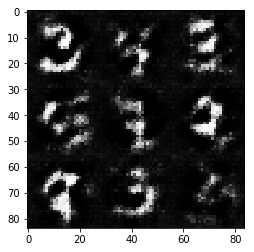

Step: 210: Epoch 1/2... Discriminator Loss: 1.3384... Generator Loss: 0.6183
Step: 220: Epoch 1/2... Discriminator Loss: 0.8924... Generator Loss: 1.3869
Step: 230: Epoch 1/2... Discriminator Loss: 0.8386... Generator Loss: 0.9824
Step: 240: Epoch 1/2... Discriminator Loss: 0.9608... Generator Loss: 0.9323
Step: 250: Epoch 1/2... Discriminator Loss: 1.1202... Generator Loss: 0.6868
Step: 260: Epoch 1/2... Discriminator Loss: 0.8841... Generator Loss: 1.3923
Step: 270: Epoch 1/2... Discriminator Loss: 1.1626... Generator Loss: 0.5906
Step: 280: Epoch 1/2... Discriminator Loss: 1.1925... Generator Loss: 0.7229
Step: 290: Epoch 1/2... Discriminator Loss: 1.1850... Generator Loss: 0.4924
Step: 300: Epoch 1/2... Discriminator Loss: 1.1730... Generator Loss: 0.6080


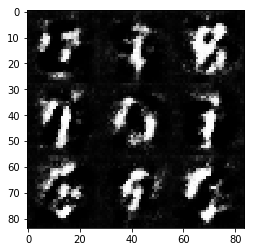

Step: 310: Epoch 1/2... Discriminator Loss: 0.8728... Generator Loss: 0.8168
Step: 320: Epoch 1/2... Discriminator Loss: 0.8000... Generator Loss: 1.1347
Step: 330: Epoch 1/2... Discriminator Loss: 1.0292... Generator Loss: 1.8911
Step: 340: Epoch 1/2... Discriminator Loss: 0.8294... Generator Loss: 1.7329
Step: 350: Epoch 1/2... Discriminator Loss: 0.9321... Generator Loss: 0.7571
Step: 360: Epoch 1/2... Discriminator Loss: 0.8653... Generator Loss: 0.9849
Step: 370: Epoch 1/2... Discriminator Loss: 1.4115... Generator Loss: 0.3375
Step: 380: Epoch 1/2... Discriminator Loss: 0.8729... Generator Loss: 0.9766
Step: 390: Epoch 1/2... Discriminator Loss: 0.7763... Generator Loss: 1.5937
Step: 400: Epoch 1/2... Discriminator Loss: 0.9853... Generator Loss: 0.6671


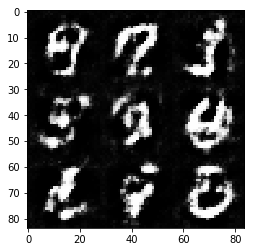

Step: 410: Epoch 1/2... Discriminator Loss: 0.9784... Generator Loss: 1.0173
Step: 420: Epoch 1/2... Discriminator Loss: 0.7301... Generator Loss: 1.0711
Step: 430: Epoch 1/2... Discriminator Loss: 0.8782... Generator Loss: 1.4331
Step: 440: Epoch 1/2... Discriminator Loss: 1.4468... Generator Loss: 0.3907
Step: 450: Epoch 1/2... Discriminator Loss: 0.8245... Generator Loss: 1.9624
Step: 460: Epoch 1/2... Discriminator Loss: 0.8171... Generator Loss: 0.9680
Step: 470: Epoch 1/2... Discriminator Loss: 0.8812... Generator Loss: 0.8533
Step: 480: Epoch 1/2... Discriminator Loss: 0.9482... Generator Loss: 1.8117
Step: 490: Epoch 1/2... Discriminator Loss: 1.2506... Generator Loss: 0.5463
Step: 500: Epoch 1/2... Discriminator Loss: 0.7401... Generator Loss: 0.9874


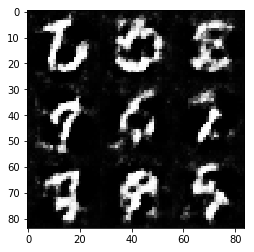

Step: 510: Epoch 1/2... Discriminator Loss: 1.0339... Generator Loss: 0.7091
Step: 520: Epoch 1/2... Discriminator Loss: 0.9588... Generator Loss: 2.0683
Step: 530: Epoch 1/2... Discriminator Loss: 0.7921... Generator Loss: 1.4968
Step: 540: Epoch 1/2... Discriminator Loss: 0.9978... Generator Loss: 0.6379
Step: 550: Epoch 1/2... Discriminator Loss: 0.8205... Generator Loss: 0.9941
Step: 560: Epoch 1/2... Discriminator Loss: 1.1775... Generator Loss: 2.0490
Step: 570: Epoch 1/2... Discriminator Loss: 0.8506... Generator Loss: 1.4198
Step: 580: Epoch 1/2... Discriminator Loss: 1.0559... Generator Loss: 0.6699
Step: 590: Epoch 1/2... Discriminator Loss: 0.9265... Generator Loss: 2.8819
Step: 600: Epoch 1/2... Discriminator Loss: 1.2706... Generator Loss: 0.6076


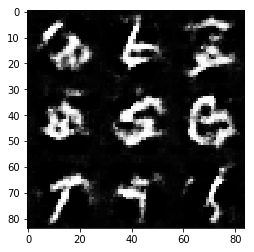

Step: 610: Epoch 1/2... Discriminator Loss: 0.8690... Generator Loss: 0.9711
Step: 620: Epoch 1/2... Discriminator Loss: 1.3138... Generator Loss: 2.6223
Step: 630: Epoch 1/2... Discriminator Loss: 1.2197... Generator Loss: 0.5016
Step: 640: Epoch 1/2... Discriminator Loss: 1.0155... Generator Loss: 0.6796
Step: 650: Epoch 1/2... Discriminator Loss: 1.0755... Generator Loss: 0.6261
Step: 660: Epoch 1/2... Discriminator Loss: 0.9993... Generator Loss: 0.6869
Step: 670: Epoch 1/2... Discriminator Loss: 1.1707... Generator Loss: 2.1651
Step: 680: Epoch 1/2... Discriminator Loss: 0.6603... Generator Loss: 1.4774
Step: 690: Epoch 1/2... Discriminator Loss: 1.0311... Generator Loss: 0.7935
Step: 700: Epoch 1/2... Discriminator Loss: 0.6742... Generator Loss: 1.1329


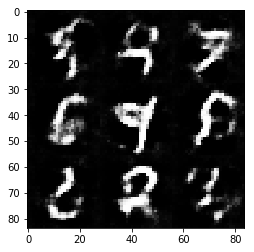

Step: 710: Epoch 1/2... Discriminator Loss: 1.4525... Generator Loss: 0.3344
Step: 720: Epoch 1/2... Discriminator Loss: 1.2448... Generator Loss: 0.5364
Step: 730: Epoch 1/2... Discriminator Loss: 0.8164... Generator Loss: 1.1349
Step: 740: Epoch 1/2... Discriminator Loss: 0.9197... Generator Loss: 0.7774
Step: 750: Epoch 1/2... Discriminator Loss: 0.7362... Generator Loss: 1.5518
Step: 760: Epoch 1/2... Discriminator Loss: 0.4900... Generator Loss: 1.9430
Step: 770: Epoch 1/2... Discriminator Loss: 0.6996... Generator Loss: 1.7019
Step: 780: Epoch 1/2... Discriminator Loss: 1.1802... Generator Loss: 0.7414
Step: 790: Epoch 1/2... Discriminator Loss: 1.5416... Generator Loss: 0.3322
Step: 800: Epoch 1/2... Discriminator Loss: 1.9294... Generator Loss: 0.1960


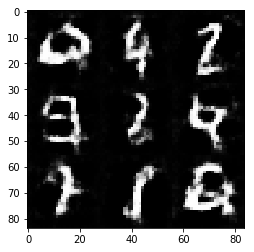

Step: 810: Epoch 1/2... Discriminator Loss: 0.6313... Generator Loss: 1.2845
Step: 820: Epoch 1/2... Discriminator Loss: 1.3525... Generator Loss: 0.4246
Step: 830: Epoch 1/2... Discriminator Loss: 0.9313... Generator Loss: 1.4890
Step: 840: Epoch 1/2... Discriminator Loss: 0.9811... Generator Loss: 0.6220
Step: 850: Epoch 1/2... Discriminator Loss: 1.1436... Generator Loss: 2.3278
Step: 860: Epoch 1/2... Discriminator Loss: 1.1506... Generator Loss: 0.5735
Step: 870: Epoch 1/2... Discriminator Loss: 1.2378... Generator Loss: 0.5093
Step: 880: Epoch 1/2... Discriminator Loss: 1.2923... Generator Loss: 0.4129
Step: 890: Epoch 1/2... Discriminator Loss: 1.3057... Generator Loss: 0.4209
Step: 900: Epoch 1/2... Discriminator Loss: 0.7100... Generator Loss: 0.9649


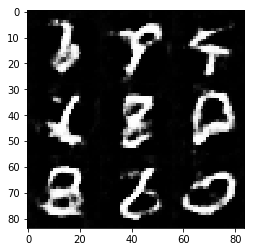

Step: 910: Epoch 1/2... Discriminator Loss: 0.7189... Generator Loss: 1.0357
Step: 920: Epoch 1/2... Discriminator Loss: 0.8451... Generator Loss: 0.9910
Step: 930: Epoch 1/2... Discriminator Loss: 1.2932... Generator Loss: 0.4425
Step: 940: Epoch 1/2... Discriminator Loss: 1.5328... Generator Loss: 0.3157
Step: 950: Epoch 1/2... Discriminator Loss: 0.6556... Generator Loss: 1.4013
Step: 960: Epoch 1/2... Discriminator Loss: 0.7724... Generator Loss: 1.9210
Step: 970: Epoch 1/2... Discriminator Loss: 0.9855... Generator Loss: 0.6809
Step: 980: Epoch 1/2... Discriminator Loss: 0.9327... Generator Loss: 2.3936
Step: 990: Epoch 1/2... Discriminator Loss: 0.8972... Generator Loss: 0.7425
Step: 1000: Epoch 1/2... Discriminator Loss: 1.2346... Generator Loss: 0.4627


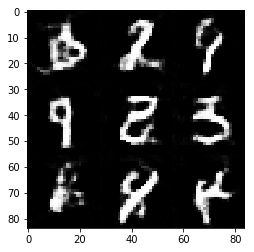

Step: 1010: Epoch 1/2... Discriminator Loss: 0.8701... Generator Loss: 1.7049
Step: 1020: Epoch 1/2... Discriminator Loss: 2.2779... Generator Loss: 0.1842
Step: 1030: Epoch 1/2... Discriminator Loss: 0.9351... Generator Loss: 0.7266
Step: 1040: Epoch 1/2... Discriminator Loss: 0.9023... Generator Loss: 0.7711
Step: 1050: Epoch 1/2... Discriminator Loss: 0.5924... Generator Loss: 1.3581
Step: 1060: Epoch 1/2... Discriminator Loss: 0.9281... Generator Loss: 2.8400
Step: 1070: Epoch 1/2... Discriminator Loss: 0.7967... Generator Loss: 0.8689
Step: 1080: Epoch 1/2... Discriminator Loss: 0.9166... Generator Loss: 0.7539
Step: 1090: Epoch 1/2... Discriminator Loss: 0.7086... Generator Loss: 0.9422
Step: 1100: Epoch 1/2... Discriminator Loss: 1.0333... Generator Loss: 2.1968


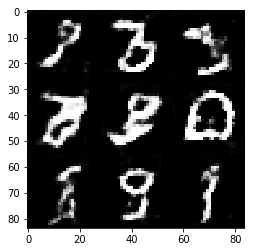

Step: 1110: Epoch 1/2... Discriminator Loss: 0.8654... Generator Loss: 1.1316
Step: 1120: Epoch 1/2... Discriminator Loss: 2.0339... Generator Loss: 3.5154
Step: 1130: Epoch 1/2... Discriminator Loss: 1.0018... Generator Loss: 0.6624
Step: 1140: Epoch 1/2... Discriminator Loss: 1.0859... Generator Loss: 0.7492
Step: 1150: Epoch 1/2... Discriminator Loss: 0.7299... Generator Loss: 1.1872
Step: 1160: Epoch 1/2... Discriminator Loss: 0.7399... Generator Loss: 1.0623
Step: 1170: Epoch 1/2... Discriminator Loss: 0.8756... Generator Loss: 0.7308
Step: 1180: Epoch 1/2... Discriminator Loss: 0.7821... Generator Loss: 0.8874
Step: 1190: Epoch 1/2... Discriminator Loss: 0.9310... Generator Loss: 0.6868
Step: 1200: Epoch 1/2... Discriminator Loss: 0.7285... Generator Loss: 1.1349


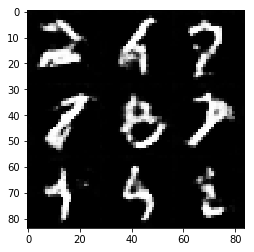

Step: 1210: Epoch 1/2... Discriminator Loss: 1.5179... Generator Loss: 0.3383
Step: 1220: Epoch 1/2... Discriminator Loss: 0.9145... Generator Loss: 3.2305
Step: 1230: Epoch 1/2... Discriminator Loss: 1.1302... Generator Loss: 0.5590
Step: 1240: Epoch 1/2... Discriminator Loss: 0.9079... Generator Loss: 0.7640
Step: 1250: Epoch 1/2... Discriminator Loss: 0.6146... Generator Loss: 1.1451
Step: 1260: Epoch 1/2... Discriminator Loss: 0.9615... Generator Loss: 0.6521
Step: 1270: Epoch 1/2... Discriminator Loss: 0.9009... Generator Loss: 0.8335
Step: 1280: Epoch 1/2... Discriminator Loss: 1.0929... Generator Loss: 0.5129
Step: 1290: Epoch 1/2... Discriminator Loss: 1.2322... Generator Loss: 0.5097
Step: 1300: Epoch 1/2... Discriminator Loss: 2.6322... Generator Loss: 0.1246


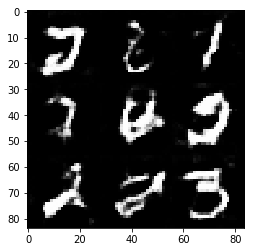

Step: 1310: Epoch 1/2... Discriminator Loss: 0.6991... Generator Loss: 1.9218
Step: 1320: Epoch 1/2... Discriminator Loss: 0.8748... Generator Loss: 0.7133
Step: 1330: Epoch 1/2... Discriminator Loss: 1.3439... Generator Loss: 0.4032
Step: 1340: Epoch 1/2... Discriminator Loss: 0.7174... Generator Loss: 1.2083
Step: 1350: Epoch 1/2... Discriminator Loss: 2.3005... Generator Loss: 0.1352
Step: 1360: Epoch 1/2... Discriminator Loss: 1.3385... Generator Loss: 0.4121
Step: 1370: Epoch 1/2... Discriminator Loss: 0.6470... Generator Loss: 1.0639
Step: 1380: Epoch 1/2... Discriminator Loss: 0.6330... Generator Loss: 1.0778
Step: 1390: Epoch 1/2... Discriminator Loss: 0.6942... Generator Loss: 0.9847
Step: 1400: Epoch 1/2... Discriminator Loss: 1.3803... Generator Loss: 0.3733


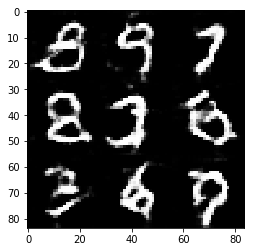

Step: 1410: Epoch 1/2... Discriminator Loss: 0.4663... Generator Loss: 1.7740
Step: 1420: Epoch 1/2... Discriminator Loss: 0.7283... Generator Loss: 1.2021
Step: 1430: Epoch 1/2... Discriminator Loss: 1.0681... Generator Loss: 0.6081
Step: 1440: Epoch 1/2... Discriminator Loss: 1.3288... Generator Loss: 0.4385
Step: 1450: Epoch 1/2... Discriminator Loss: 0.6066... Generator Loss: 1.1000
Step: 1460: Epoch 1/2... Discriminator Loss: 0.5200... Generator Loss: 1.3207
Step: 1470: Epoch 1/2... Discriminator Loss: 0.9938... Generator Loss: 0.6415
Step: 1480: Epoch 1/2... Discriminator Loss: 0.5985... Generator Loss: 0.9932
Step: 1490: Epoch 1/2... Discriminator Loss: 0.8667... Generator Loss: 2.6196
Step: 1500: Epoch 1/2... Discriminator Loss: 0.5834... Generator Loss: 2.9345


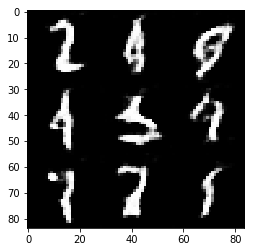

Step: 1510: Epoch 1/2... Discriminator Loss: 1.3991... Generator Loss: 0.3679
Step: 1520: Epoch 1/2... Discriminator Loss: 0.6347... Generator Loss: 1.1770
Step: 1530: Epoch 1/2... Discriminator Loss: 1.0891... Generator Loss: 0.5560
Step: 1540: Epoch 1/2... Discriminator Loss: 0.9255... Generator Loss: 0.6834
Step: 1550: Epoch 1/2... Discriminator Loss: 0.6614... Generator Loss: 0.9857
Step: 1560: Epoch 1/2... Discriminator Loss: 0.9485... Generator Loss: 1.7647
Step: 1570: Epoch 1/2... Discriminator Loss: 1.0634... Generator Loss: 2.4019
Step: 1580: Epoch 1/2... Discriminator Loss: 0.7503... Generator Loss: 0.9497
Step: 1590: Epoch 1/2... Discriminator Loss: 0.8146... Generator Loss: 2.3927
Step: 1600: Epoch 1/2... Discriminator Loss: 1.1175... Generator Loss: 0.5484


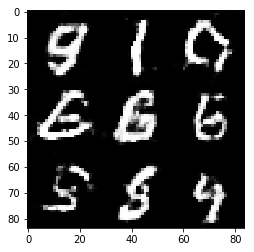

Step: 1610: Epoch 1/2... Discriminator Loss: 1.8267... Generator Loss: 0.2337
Step: 1620: Epoch 1/2... Discriminator Loss: 0.9391... Generator Loss: 0.7020
Step: 1630: Epoch 1/2... Discriminator Loss: 0.7177... Generator Loss: 0.9371
Step: 1640: Epoch 1/2... Discriminator Loss: 0.6452... Generator Loss: 1.0346
Step: 1650: Epoch 1/2... Discriminator Loss: 0.5821... Generator Loss: 1.1645
Step: 1660: Epoch 1/2... Discriminator Loss: 0.5570... Generator Loss: 1.1588
Step: 1670: Epoch 1/2... Discriminator Loss: 0.9657... Generator Loss: 0.8764
Step: 1680: Epoch 1/2... Discriminator Loss: 0.4537... Generator Loss: 1.3511
Step: 1690: Epoch 1/2... Discriminator Loss: 2.7845... Generator Loss: 0.1627
Step: 1700: Epoch 1/2... Discriminator Loss: 0.7249... Generator Loss: 0.8630


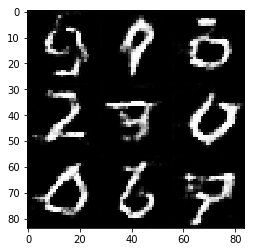

Step: 1710: Epoch 1/2... Discriminator Loss: 0.6530... Generator Loss: 1.0094
Step: 1720: Epoch 1/2... Discriminator Loss: 0.5309... Generator Loss: 1.4842
Step: 1730: Epoch 1/2... Discriminator Loss: 0.9931... Generator Loss: 1.0236
Step: 1740: Epoch 1/2... Discriminator Loss: 1.0401... Generator Loss: 2.1516
Step: 1750: Epoch 1/2... Discriminator Loss: 0.8373... Generator Loss: 0.8355
Step: 1760: Epoch 1/2... Discriminator Loss: 0.7712... Generator Loss: 0.8776
Step: 1770: Epoch 1/2... Discriminator Loss: 0.9059... Generator Loss: 0.7618
Step: 1780: Epoch 1/2... Discriminator Loss: 0.5051... Generator Loss: 1.6406
Step: 1790: Epoch 1/2... Discriminator Loss: 0.6191... Generator Loss: 1.1677
Step: 1800: Epoch 1/2... Discriminator Loss: 0.6527... Generator Loss: 0.9548


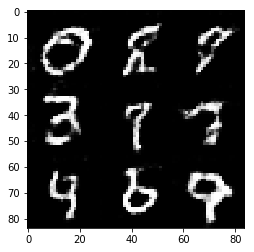

Step: 1810: Epoch 1/2... Discriminator Loss: 1.0374... Generator Loss: 1.7142
Step: 1820: Epoch 1/2... Discriminator Loss: 0.6530... Generator Loss: 1.0085
Step: 1830: Epoch 1/2... Discriminator Loss: 1.0130... Generator Loss: 0.6633
Step: 1840: Epoch 1/2... Discriminator Loss: 0.5945... Generator Loss: 1.1565
Step: 1850: Epoch 1/2... Discriminator Loss: 1.0932... Generator Loss: 0.6012
Step: 1860: Epoch 1/2... Discriminator Loss: 1.1270... Generator Loss: 0.5659
Step: 1870: Epoch 1/2... Discriminator Loss: 0.4593... Generator Loss: 1.2949
Step: 1880: Epoch 2/2... Discriminator Loss: 0.4321... Generator Loss: 1.2891
Step: 1890: Epoch 2/2... Discriminator Loss: 0.8439... Generator Loss: 1.3862
Step: 1900: Epoch 2/2... Discriminator Loss: 0.6077... Generator Loss: 1.2511


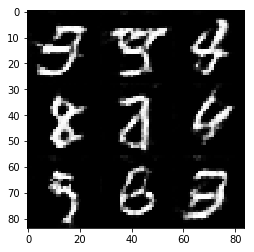

Step: 1910: Epoch 2/2... Discriminator Loss: 0.7598... Generator Loss: 1.0255
Step: 1920: Epoch 2/2... Discriminator Loss: 0.5474... Generator Loss: 1.1343
Step: 1930: Epoch 2/2... Discriminator Loss: 1.0682... Generator Loss: 0.5809
Step: 1940: Epoch 2/2... Discriminator Loss: 0.9367... Generator Loss: 0.6792
Step: 1950: Epoch 2/2... Discriminator Loss: 0.6103... Generator Loss: 0.9749
Step: 1960: Epoch 2/2... Discriminator Loss: 1.4935... Generator Loss: 0.3737
Step: 1970: Epoch 2/2... Discriminator Loss: 0.9990... Generator Loss: 0.7979
Step: 1980: Epoch 2/2... Discriminator Loss: 0.5458... Generator Loss: 1.4439
Step: 1990: Epoch 2/2... Discriminator Loss: 0.7757... Generator Loss: 1.2817
Step: 2000: Epoch 2/2... Discriminator Loss: 0.6994... Generator Loss: 1.4558


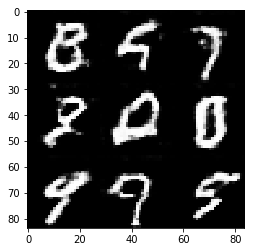

Step: 2010: Epoch 2/2... Discriminator Loss: 0.5454... Generator Loss: 1.7729
Step: 2020: Epoch 2/2... Discriminator Loss: 0.6234... Generator Loss: 1.0894
Step: 2030: Epoch 2/2... Discriminator Loss: 0.9231... Generator Loss: 0.7036
Step: 2040: Epoch 2/2... Discriminator Loss: 0.3981... Generator Loss: 1.5681
Step: 2050: Epoch 2/2... Discriminator Loss: 0.6496... Generator Loss: 2.1925
Step: 2060: Epoch 2/2... Discriminator Loss: 0.5039... Generator Loss: 1.3101
Step: 2070: Epoch 2/2... Discriminator Loss: 0.8889... Generator Loss: 0.7194
Step: 2080: Epoch 2/2... Discriminator Loss: 1.0147... Generator Loss: 0.5751
Step: 2090: Epoch 2/2... Discriminator Loss: 1.2492... Generator Loss: 4.4035
Step: 2100: Epoch 2/2... Discriminator Loss: 0.5734... Generator Loss: 2.2925


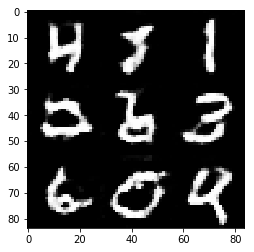

Step: 2110: Epoch 2/2... Discriminator Loss: 1.0891... Generator Loss: 0.7116
Step: 2120: Epoch 2/2... Discriminator Loss: 0.6143... Generator Loss: 1.4580
Step: 2130: Epoch 2/2... Discriminator Loss: 0.4241... Generator Loss: 1.3673
Step: 2140: Epoch 2/2... Discriminator Loss: 0.4235... Generator Loss: 2.3533
Step: 2150: Epoch 2/2... Discriminator Loss: 0.8859... Generator Loss: 0.7857
Step: 2160: Epoch 2/2... Discriminator Loss: 0.6895... Generator Loss: 0.8446
Step: 2170: Epoch 2/2... Discriminator Loss: 1.3101... Generator Loss: 0.5164
Step: 2180: Epoch 2/2... Discriminator Loss: 0.8494... Generator Loss: 1.2651
Step: 2190: Epoch 2/2... Discriminator Loss: 0.4724... Generator Loss: 1.4601
Step: 2200: Epoch 2/2... Discriminator Loss: 0.5041... Generator Loss: 1.1857


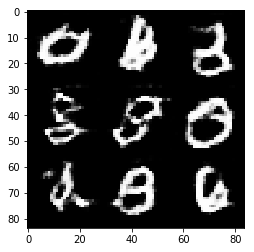

Step: 2210: Epoch 2/2... Discriminator Loss: 1.7998... Generator Loss: 2.8046
Step: 2220: Epoch 2/2... Discriminator Loss: 0.3466... Generator Loss: 2.2913
Step: 2230: Epoch 2/2... Discriminator Loss: 0.7733... Generator Loss: 1.5152
Step: 2240: Epoch 2/2... Discriminator Loss: 0.6586... Generator Loss: 0.9777
Step: 2250: Epoch 2/2... Discriminator Loss: 0.6567... Generator Loss: 1.0438
Step: 2260: Epoch 2/2... Discriminator Loss: 0.4902... Generator Loss: 1.9152
Step: 2270: Epoch 2/2... Discriminator Loss: 1.0452... Generator Loss: 0.6679
Step: 2280: Epoch 2/2... Discriminator Loss: 0.4430... Generator Loss: 1.4547
Step: 2290: Epoch 2/2... Discriminator Loss: 0.6542... Generator Loss: 1.1328
Step: 2300: Epoch 2/2... Discriminator Loss: 0.6750... Generator Loss: 0.9106


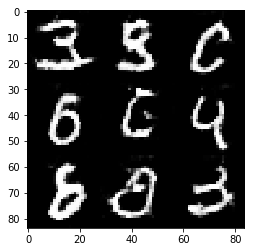

Step: 2310: Epoch 2/2... Discriminator Loss: 0.8319... Generator Loss: 1.8154
Step: 2320: Epoch 2/2... Discriminator Loss: 0.6990... Generator Loss: 1.0093
Step: 2330: Epoch 2/2... Discriminator Loss: 1.4281... Generator Loss: 0.3945
Step: 2340: Epoch 2/2... Discriminator Loss: 0.9472... Generator Loss: 0.7554
Step: 2350: Epoch 2/2... Discriminator Loss: 0.4575... Generator Loss: 1.4027
Step: 2360: Epoch 2/2... Discriminator Loss: 0.6927... Generator Loss: 1.0092
Step: 2370: Epoch 2/2... Discriminator Loss: 0.8088... Generator Loss: 0.7626
Step: 2380: Epoch 2/2... Discriminator Loss: 0.4536... Generator Loss: 1.3710
Step: 2390: Epoch 2/2... Discriminator Loss: 0.5680... Generator Loss: 1.1172
Step: 2400: Epoch 2/2... Discriminator Loss: 0.9934... Generator Loss: 0.7332


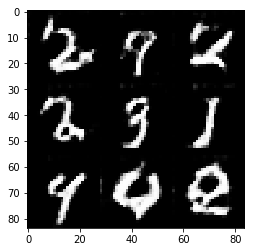

Step: 2410: Epoch 2/2... Discriminator Loss: 0.3985... Generator Loss: 2.2935
Step: 2420: Epoch 2/2... Discriminator Loss: 1.3580... Generator Loss: 4.0448
Step: 2430: Epoch 2/2... Discriminator Loss: 0.5943... Generator Loss: 1.4673
Step: 2440: Epoch 2/2... Discriminator Loss: 0.6071... Generator Loss: 1.6791
Step: 2450: Epoch 2/2... Discriminator Loss: 0.9497... Generator Loss: 0.6911
Step: 2460: Epoch 2/2... Discriminator Loss: 0.8361... Generator Loss: 0.8550
Step: 2470: Epoch 2/2... Discriminator Loss: 0.9301... Generator Loss: 0.6634
Step: 2480: Epoch 2/2... Discriminator Loss: 0.5711... Generator Loss: 1.1510
Step: 2490: Epoch 2/2... Discriminator Loss: 0.5148... Generator Loss: 1.2821
Step: 2500: Epoch 2/2... Discriminator Loss: 0.6577... Generator Loss: 1.1423


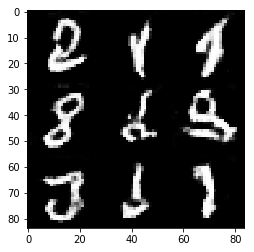

Step: 2510: Epoch 2/2... Discriminator Loss: 1.0201... Generator Loss: 0.6610
Step: 2520: Epoch 2/2... Discriminator Loss: 0.9481... Generator Loss: 0.8499
Step: 2530: Epoch 2/2... Discriminator Loss: 1.0737... Generator Loss: 0.5763
Step: 2540: Epoch 2/2... Discriminator Loss: 0.5669... Generator Loss: 2.7410
Step: 2550: Epoch 2/2... Discriminator Loss: 0.6919... Generator Loss: 1.8205
Step: 2560: Epoch 2/2... Discriminator Loss: 0.7845... Generator Loss: 0.7320
Step: 2570: Epoch 2/2... Discriminator Loss: 0.6599... Generator Loss: 0.9508
Step: 2580: Epoch 2/2... Discriminator Loss: 1.0377... Generator Loss: 0.6510
Step: 2590: Epoch 2/2... Discriminator Loss: 0.5235... Generator Loss: 1.2764
Step: 2600: Epoch 2/2... Discriminator Loss: 0.4820... Generator Loss: 1.2781


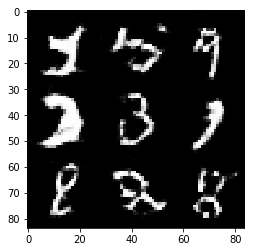

Step: 2610: Epoch 2/2... Discriminator Loss: 1.0816... Generator Loss: 0.5579
Step: 2620: Epoch 2/2... Discriminator Loss: 0.9616... Generator Loss: 0.6444
Step: 2630: Epoch 2/2... Discriminator Loss: 0.4393... Generator Loss: 1.4591
Step: 2640: Epoch 2/2... Discriminator Loss: 0.8889... Generator Loss: 0.7471
Step: 2650: Epoch 2/2... Discriminator Loss: 0.7573... Generator Loss: 0.8476
Step: 2660: Epoch 2/2... Discriminator Loss: 0.3905... Generator Loss: 1.6869
Step: 2670: Epoch 2/2... Discriminator Loss: 0.8637... Generator Loss: 0.8506
Step: 2680: Epoch 2/2... Discriminator Loss: 0.7084... Generator Loss: 1.0942
Step: 2690: Epoch 2/2... Discriminator Loss: 0.4249... Generator Loss: 1.3265
Step: 2700: Epoch 2/2... Discriminator Loss: 2.5170... Generator Loss: 0.1600


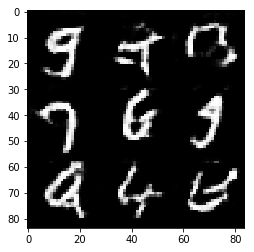

Step: 2710: Epoch 2/2... Discriminator Loss: 0.6278... Generator Loss: 2.2336
Step: 2720: Epoch 2/2... Discriminator Loss: 1.2389... Generator Loss: 0.5132
Step: 2730: Epoch 2/2... Discriminator Loss: 1.1259... Generator Loss: 0.5059
Step: 2740: Epoch 2/2... Discriminator Loss: 0.5983... Generator Loss: 1.1933
Step: 2750: Epoch 2/2... Discriminator Loss: 0.5689... Generator Loss: 1.1841
Step: 2760: Epoch 2/2... Discriminator Loss: 1.2547... Generator Loss: 0.4320
Step: 2770: Epoch 2/2... Discriminator Loss: 0.6069... Generator Loss: 1.1061
Step: 2780: Epoch 2/2... Discriminator Loss: 0.4823... Generator Loss: 1.1854
Step: 2790: Epoch 2/2... Discriminator Loss: 2.3448... Generator Loss: 0.1683
Step: 2800: Epoch 2/2... Discriminator Loss: 0.6162... Generator Loss: 1.6486


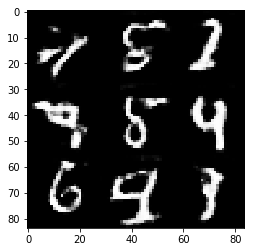

Step: 2810: Epoch 2/2... Discriminator Loss: 0.7165... Generator Loss: 1.1030
Step: 2820: Epoch 2/2... Discriminator Loss: 0.6358... Generator Loss: 1.8545
Step: 2830: Epoch 2/2... Discriminator Loss: 0.4468... Generator Loss: 1.4073
Step: 2840: Epoch 2/2... Discriminator Loss: 0.6553... Generator Loss: 1.0477
Step: 2850: Epoch 2/2... Discriminator Loss: 0.6692... Generator Loss: 0.9580
Step: 2860: Epoch 2/2... Discriminator Loss: 0.6528... Generator Loss: 1.0563
Step: 2870: Epoch 2/2... Discriminator Loss: 0.8876... Generator Loss: 0.6660
Step: 2880: Epoch 2/2... Discriminator Loss: 0.4764... Generator Loss: 1.2961
Step: 2890: Epoch 2/2... Discriminator Loss: 0.5292... Generator Loss: 1.1907
Step: 2900: Epoch 2/2... Discriminator Loss: 0.6092... Generator Loss: 1.4199


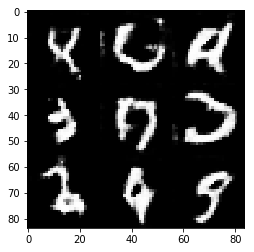

Step: 2910: Epoch 2/2... Discriminator Loss: 0.6308... Generator Loss: 1.2401
Step: 2920: Epoch 2/2... Discriminator Loss: 0.7572... Generator Loss: 0.9380
Step: 2930: Epoch 2/2... Discriminator Loss: 0.4589... Generator Loss: 1.3663
Step: 2940: Epoch 2/2... Discriminator Loss: 0.7834... Generator Loss: 0.7906
Step: 2950: Epoch 2/2... Discriminator Loss: 0.9316... Generator Loss: 0.6166
Step: 2960: Epoch 2/2... Discriminator Loss: 0.5777... Generator Loss: 1.1151
Step: 2970: Epoch 2/2... Discriminator Loss: 0.4496... Generator Loss: 1.5151
Step: 2980: Epoch 2/2... Discriminator Loss: 0.4922... Generator Loss: 1.3480
Step: 2990: Epoch 2/2... Discriminator Loss: 0.4186... Generator Loss: 1.7435
Step: 3000: Epoch 2/2... Discriminator Loss: 0.6367... Generator Loss: 1.1053


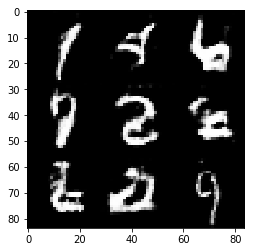

Step: 3010: Epoch 2/2... Discriminator Loss: 0.5053... Generator Loss: 1.3911
Step: 3020: Epoch 2/2... Discriminator Loss: 0.2317... Generator Loss: 2.8095
Step: 3030: Epoch 2/2... Discriminator Loss: 1.4059... Generator Loss: 0.5619
Step: 3040: Epoch 2/2... Discriminator Loss: 0.6948... Generator Loss: 0.9461
Step: 3050: Epoch 2/2... Discriminator Loss: 0.4526... Generator Loss: 1.3095
Step: 3060: Epoch 2/2... Discriminator Loss: 0.5535... Generator Loss: 1.1332
Step: 3070: Epoch 2/2... Discriminator Loss: 0.8192... Generator Loss: 0.8186
Step: 3080: Epoch 2/2... Discriminator Loss: 0.4648... Generator Loss: 1.3597
Step: 3090: Epoch 2/2... Discriminator Loss: 3.0925... Generator Loss: 0.0896
Step: 3100: Epoch 2/2... Discriminator Loss: 0.4097... Generator Loss: 1.5552


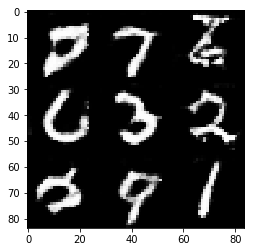

Step: 3110: Epoch 2/2... Discriminator Loss: 0.5210... Generator Loss: 1.4211
Step: 3120: Epoch 2/2... Discriminator Loss: 0.7359... Generator Loss: 0.9787
Step: 3130: Epoch 2/2... Discriminator Loss: 0.6555... Generator Loss: 1.0467
Step: 3140: Epoch 2/2... Discriminator Loss: 0.9342... Generator Loss: 0.7141
Step: 3150: Epoch 2/2... Discriminator Loss: 0.3600... Generator Loss: 1.6489
Step: 3160: Epoch 2/2... Discriminator Loss: 0.2534... Generator Loss: 1.8986
Step: 3170: Epoch 2/2... Discriminator Loss: 0.6562... Generator Loss: 1.0721
Step: 3180: Epoch 2/2... Discriminator Loss: 0.5953... Generator Loss: 1.1890
Step: 3190: Epoch 2/2... Discriminator Loss: 0.8749... Generator Loss: 0.7762
Step: 3200: Epoch 2/2... Discriminator Loss: 0.5186... Generator Loss: 1.2956


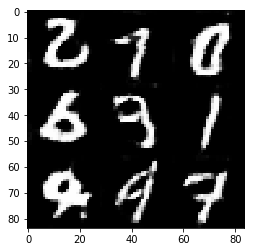

Step: 3210: Epoch 2/2... Discriminator Loss: 0.4493... Generator Loss: 1.3671
Step: 3220: Epoch 2/2... Discriminator Loss: 0.5225... Generator Loss: 1.3697
Step: 3230: Epoch 2/2... Discriminator Loss: 1.1925... Generator Loss: 0.5681
Step: 3240: Epoch 2/2... Discriminator Loss: 0.5232... Generator Loss: 1.7068
Step: 3250: Epoch 2/2... Discriminator Loss: 0.6068... Generator Loss: 1.0489
Step: 3260: Epoch 2/2... Discriminator Loss: 0.4807... Generator Loss: 1.2107
Step: 3270: Epoch 2/2... Discriminator Loss: 0.4594... Generator Loss: 1.3531
Step: 3280: Epoch 2/2... Discriminator Loss: 0.5348... Generator Loss: 1.9578
Step: 3290: Epoch 2/2... Discriminator Loss: 0.9292... Generator Loss: 0.7374
Step: 3300: Epoch 2/2... Discriminator Loss: 0.7236... Generator Loss: 0.8932


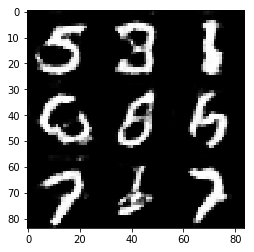

Step: 3310: Epoch 2/2... Discriminator Loss: 0.5881... Generator Loss: 1.0473
Step: 3320: Epoch 2/2... Discriminator Loss: 0.3812... Generator Loss: 1.5023
Step: 3330: Epoch 2/2... Discriminator Loss: 0.3611... Generator Loss: 1.5649
Step: 3340: Epoch 2/2... Discriminator Loss: 0.4780... Generator Loss: 1.2349
Step: 3350: Epoch 2/2... Discriminator Loss: 0.5062... Generator Loss: 1.2732
Step: 3360: Epoch 2/2... Discriminator Loss: 0.3000... Generator Loss: 1.9061
Step: 3370: Epoch 2/2... Discriminator Loss: 1.5859... Generator Loss: 0.4114
Step: 3380: Epoch 2/2... Discriminator Loss: 0.4699... Generator Loss: 1.4304
Step: 3390: Epoch 2/2... Discriminator Loss: 0.1733... Generator Loss: 2.9333
Step: 3400: Epoch 2/2... Discriminator Loss: 0.8246... Generator Loss: 0.8127


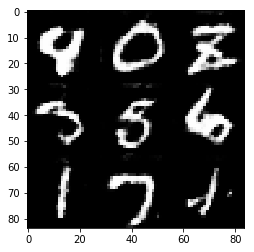

Step: 3410: Epoch 2/2... Discriminator Loss: 1.8939... Generator Loss: 0.2268
Step: 3420: Epoch 2/2... Discriminator Loss: 0.3680... Generator Loss: 2.1029
Step: 3430: Epoch 2/2... Discriminator Loss: 0.4401... Generator Loss: 1.4703
Step: 3440: Epoch 2/2... Discriminator Loss: 0.4674... Generator Loss: 1.4765
Step: 3450: Epoch 2/2... Discriminator Loss: 0.9976... Generator Loss: 0.5932
Step: 3460: Epoch 2/2... Discriminator Loss: 0.6480... Generator Loss: 0.9570
Step: 3470: Epoch 2/2... Discriminator Loss: 0.2843... Generator Loss: 1.8211
Step: 3480: Epoch 2/2... Discriminator Loss: 0.3952... Generator Loss: 1.5194
Step: 3490: Epoch 2/2... Discriminator Loss: 0.4950... Generator Loss: 1.4333
Step: 3500: Epoch 2/2... Discriminator Loss: 1.9990... Generator Loss: 0.2866


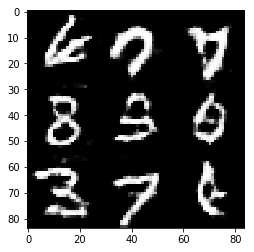

Step: 3510: Epoch 2/2... Discriminator Loss: 1.3422... Generator Loss: 5.2514
Step: 3520: Epoch 2/2... Discriminator Loss: 0.8847... Generator Loss: 0.8805
Step: 3530: Epoch 2/2... Discriminator Loss: 0.8530... Generator Loss: 0.8066
Step: 3540: Epoch 2/2... Discriminator Loss: 0.4274... Generator Loss: 1.5296
Step: 3550: Epoch 2/2... Discriminator Loss: 0.8013... Generator Loss: 0.7981
Step: 3560: Epoch 2/2... Discriminator Loss: 0.3951... Generator Loss: 1.5511
Step: 3570: Epoch 2/2... Discriminator Loss: 0.3299... Generator Loss: 1.6585
Step: 3580: Epoch 2/2... Discriminator Loss: 0.4753... Generator Loss: 2.0106
Step: 3590: Epoch 2/2... Discriminator Loss: 1.5723... Generator Loss: 0.4145
Step: 3600: Epoch 2/2... Discriminator Loss: 0.5571... Generator Loss: 1.4104


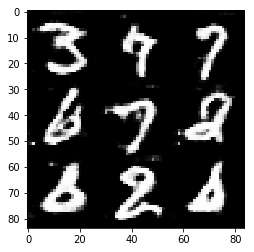

Step: 3610: Epoch 2/2... Discriminator Loss: 0.2866... Generator Loss: 3.2662
Step: 3620: Epoch 2/2... Discriminator Loss: 0.8099... Generator Loss: 3.5508
Step: 3630: Epoch 2/2... Discriminator Loss: 0.4248... Generator Loss: 1.3771
Step: 3640: Epoch 2/2... Discriminator Loss: 0.9878... Generator Loss: 0.6319
Step: 3650: Epoch 2/2... Discriminator Loss: 0.5869... Generator Loss: 1.2247
Step: 3660: Epoch 2/2... Discriminator Loss: 0.7283... Generator Loss: 0.9315
Step: 3670: Epoch 2/2... Discriminator Loss: 1.0421... Generator Loss: 0.6101
Step: 3680: Epoch 2/2... Discriminator Loss: 0.5516... Generator Loss: 1.3211
Step: 3690: Epoch 2/2... Discriminator Loss: 0.6369... Generator Loss: 1.0750
Step: 3700: Epoch 2/2... Discriminator Loss: 1.2385... Generator Loss: 0.6126


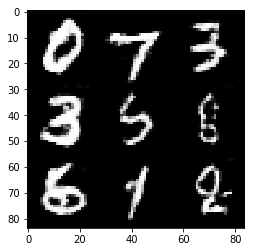

Step: 3710: Epoch 2/2... Discriminator Loss: 0.4344... Generator Loss: 1.1992
Step: 3720: Epoch 2/2... Discriminator Loss: 0.3301... Generator Loss: 1.6379
Step: 3730: Epoch 2/2... Discriminator Loss: 0.5029... Generator Loss: 1.2719
Step: 3740: Epoch 2/2... Discriminator Loss: 0.6534... Generator Loss: 0.9216
Step: 3750: Epoch 2/2... Discriminator Loss: 0.3812... Generator Loss: 1.5947
Training finished


In [48]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
model input evaluated
(?, 28, 28, 3)
training...
Step: 10: Epoch 1/2... Discriminator Loss: 0.4997... Generator Loss: 1.9838
Step: 20: Epoch 1/2... Discriminator Loss: 0.3435... Generator Loss: 3.7795
Step: 30: Epoch 1/2... Discriminator Loss: 0.6435... Generator Loss: 8.6140
Step: 40: Epoch 1/2... Discriminator Loss: 0.1062... Generator Loss: 3.6392
Step: 50: Epoch 1/2... Discriminator Loss: 0.4228... Generator Loss: 5.2021
Step: 60: Epoch 1/2... Discriminator Loss: 0.4502... Generator Loss: 5.0158
Step: 70: Epoch 1/2... Discriminator Loss: 2.0957... Generator Loss: 0.2898
Step: 80: Epoch 1/2... Discriminator Loss: 1.2794... Generator Loss: 3.0261
Step: 90: Epoch 1/2... Discriminator Loss: 1.1259... Generator Loss: 0.5759
Step: 100: Epoch 1/2... Discriminator Loss: 1.3504... Generator Loss: 0.3874


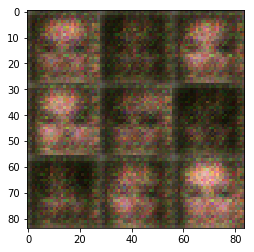

Step: 110: Epoch 1/2... Discriminator Loss: 0.6998... Generator Loss: 1.1671
Step: 120: Epoch 1/2... Discriminator Loss: 0.8440... Generator Loss: 0.6740
Step: 130: Epoch 1/2... Discriminator Loss: 0.9744... Generator Loss: 5.0050
Step: 140: Epoch 1/2... Discriminator Loss: 0.5163... Generator Loss: 3.1381
Step: 150: Epoch 1/2... Discriminator Loss: 0.4798... Generator Loss: 3.8234
Step: 160: Epoch 1/2... Discriminator Loss: 0.5925... Generator Loss: 1.3277
Step: 170: Epoch 1/2... Discriminator Loss: 0.8627... Generator Loss: 0.7819
Step: 180: Epoch 1/2... Discriminator Loss: 1.2056... Generator Loss: 0.5139
Step: 190: Epoch 1/2... Discriminator Loss: 1.0239... Generator Loss: 0.7396
Step: 200: Epoch 1/2... Discriminator Loss: 0.8827... Generator Loss: 1.7161


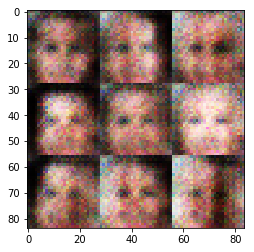

Step: 210: Epoch 1/2... Discriminator Loss: 0.5807... Generator Loss: 1.3270
Step: 220: Epoch 1/2... Discriminator Loss: 0.8695... Generator Loss: 3.2031
Step: 230: Epoch 1/2... Discriminator Loss: 0.4783... Generator Loss: 2.4526
Step: 240: Epoch 1/2... Discriminator Loss: 0.8261... Generator Loss: 2.1026
Step: 250: Epoch 1/2... Discriminator Loss: 0.7498... Generator Loss: 0.9432
Step: 260: Epoch 1/2... Discriminator Loss: 3.0819... Generator Loss: 0.0659
Step: 270: Epoch 1/2... Discriminator Loss: 1.2674... Generator Loss: 0.7091
Step: 280: Epoch 1/2... Discriminator Loss: 1.0492... Generator Loss: 0.6669
Step: 290: Epoch 1/2... Discriminator Loss: 1.3501... Generator Loss: 0.4226
Step: 300: Epoch 1/2... Discriminator Loss: 0.5541... Generator Loss: 2.1671


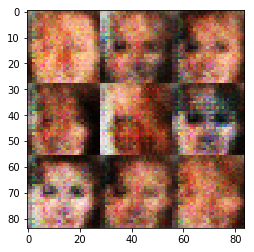

Step: 310: Epoch 1/2... Discriminator Loss: 1.0192... Generator Loss: 2.6886
Step: 320: Epoch 1/2... Discriminator Loss: 0.8168... Generator Loss: 0.7952
Step: 330: Epoch 1/2... Discriminator Loss: 0.4962... Generator Loss: 1.3083
Step: 340: Epoch 1/2... Discriminator Loss: 0.6783... Generator Loss: 1.4004
Step: 350: Epoch 1/2... Discriminator Loss: 1.1734... Generator Loss: 0.5796
Step: 360: Epoch 1/2... Discriminator Loss: 1.0075... Generator Loss: 1.5461
Step: 370: Epoch 1/2... Discriminator Loss: 0.6809... Generator Loss: 1.0452
Step: 380: Epoch 1/2... Discriminator Loss: 1.5933... Generator Loss: 0.3298
Step: 390: Epoch 1/2... Discriminator Loss: 1.1347... Generator Loss: 0.7607
Step: 400: Epoch 1/2... Discriminator Loss: 0.8720... Generator Loss: 0.9170


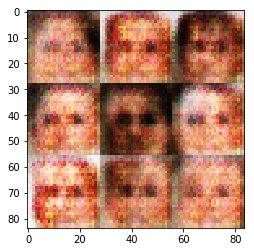

Step: 410: Epoch 1/2... Discriminator Loss: 0.9963... Generator Loss: 0.7256
Step: 420: Epoch 1/2... Discriminator Loss: 0.3786... Generator Loss: 1.5072
Step: 430: Epoch 1/2... Discriminator Loss: 1.7778... Generator Loss: 0.2715
Step: 440: Epoch 1/2... Discriminator Loss: 1.2455... Generator Loss: 3.4792
Step: 450: Epoch 1/2... Discriminator Loss: 0.4129... Generator Loss: 2.7056
Step: 460: Epoch 1/2... Discriminator Loss: 0.5607... Generator Loss: 1.3412
Step: 470: Epoch 1/2... Discriminator Loss: 0.6043... Generator Loss: 1.7224
Step: 480: Epoch 1/2... Discriminator Loss: 0.7410... Generator Loss: 3.1676
Step: 490: Epoch 1/2... Discriminator Loss: 0.9996... Generator Loss: 0.7726
Step: 500: Epoch 1/2... Discriminator Loss: 0.9111... Generator Loss: 0.7123


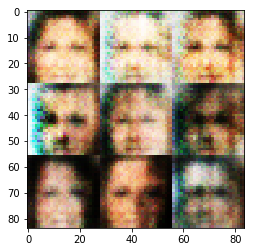

Step: 510: Epoch 1/2... Discriminator Loss: 0.7561... Generator Loss: 0.9134
Step: 520: Epoch 1/2... Discriminator Loss: 0.6594... Generator Loss: 2.8341
Step: 530: Epoch 1/2... Discriminator Loss: 1.0317... Generator Loss: 2.9995
Step: 540: Epoch 1/2... Discriminator Loss: 0.9261... Generator Loss: 0.7586
Step: 550: Epoch 1/2... Discriminator Loss: 0.7592... Generator Loss: 1.2401
Step: 560: Epoch 1/2... Discriminator Loss: 0.5903... Generator Loss: 2.2362
Step: 570: Epoch 1/2... Discriminator Loss: 1.1759... Generator Loss: 0.6554
Step: 580: Epoch 1/2... Discriminator Loss: 0.5375... Generator Loss: 1.3791
Step: 590: Epoch 1/2... Discriminator Loss: 0.7316... Generator Loss: 1.0918
Step: 600: Epoch 1/2... Discriminator Loss: 1.3931... Generator Loss: 0.4960


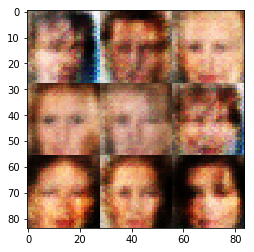

Step: 610: Epoch 1/2... Discriminator Loss: 1.0899... Generator Loss: 0.5505
Step: 620: Epoch 1/2... Discriminator Loss: 0.5810... Generator Loss: 1.7206
Step: 630: Epoch 1/2... Discriminator Loss: 0.6751... Generator Loss: 1.4136
Step: 640: Epoch 1/2... Discriminator Loss: 2.3455... Generator Loss: 0.1259
Step: 650: Epoch 1/2... Discriminator Loss: 0.6086... Generator Loss: 2.3409
Step: 660: Epoch 1/2... Discriminator Loss: 0.8692... Generator Loss: 1.3613
Step: 670: Epoch 1/2... Discriminator Loss: 0.9916... Generator Loss: 0.6307
Step: 680: Epoch 1/2... Discriminator Loss: 0.9003... Generator Loss: 1.3840
Step: 690: Epoch 1/2... Discriminator Loss: 0.7162... Generator Loss: 1.0804
Step: 700: Epoch 1/2... Discriminator Loss: 0.6555... Generator Loss: 1.0291


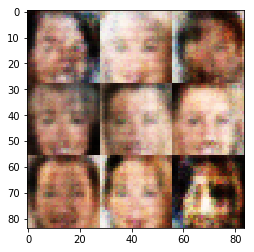

Step: 710: Epoch 1/2... Discriminator Loss: 0.9784... Generator Loss: 2.6158
Step: 720: Epoch 1/2... Discriminator Loss: 0.8840... Generator Loss: 3.6204
Step: 730: Epoch 1/2... Discriminator Loss: 1.9459... Generator Loss: 0.2434
Step: 740: Epoch 1/2... Discriminator Loss: 1.5169... Generator Loss: 0.3489
Step: 750: Epoch 1/2... Discriminator Loss: 0.5309... Generator Loss: 1.5972
Step: 760: Epoch 1/2... Discriminator Loss: 1.1872... Generator Loss: 3.0359
Step: 770: Epoch 1/2... Discriminator Loss: 0.8313... Generator Loss: 1.9659
Step: 780: Epoch 1/2... Discriminator Loss: 1.7814... Generator Loss: 0.2700
Step: 790: Epoch 1/2... Discriminator Loss: 1.2668... Generator Loss: 0.4575
Step: 800: Epoch 1/2... Discriminator Loss: 1.2323... Generator Loss: 0.5113


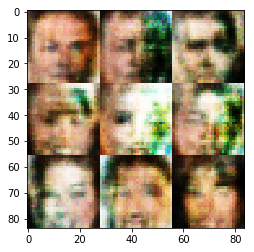

Step: 810: Epoch 1/2... Discriminator Loss: 0.9094... Generator Loss: 2.9575
Step: 820: Epoch 1/2... Discriminator Loss: 0.6808... Generator Loss: 1.3976
Step: 830: Epoch 1/2... Discriminator Loss: 1.2741... Generator Loss: 0.4186
Step: 840: Epoch 1/2... Discriminator Loss: 0.6662... Generator Loss: 1.0747
Step: 850: Epoch 1/2... Discriminator Loss: 0.8566... Generator Loss: 0.8335
Step: 860: Epoch 1/2... Discriminator Loss: 0.5323... Generator Loss: 1.7929
Step: 870: Epoch 1/2... Discriminator Loss: 0.6378... Generator Loss: 0.9955
Step: 880: Epoch 1/2... Discriminator Loss: 0.8224... Generator Loss: 0.8040
Step: 890: Epoch 1/2... Discriminator Loss: 1.4847... Generator Loss: 0.3762
Step: 900: Epoch 1/2... Discriminator Loss: 1.4578... Generator Loss: 0.4009


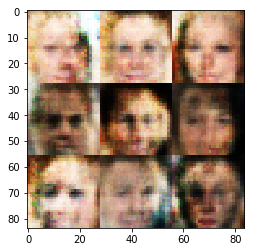

Step: 910: Epoch 1/2... Discriminator Loss: 1.0317... Generator Loss: 0.6516
Step: 920: Epoch 1/2... Discriminator Loss: 0.5765... Generator Loss: 1.3809
Step: 930: Epoch 1/2... Discriminator Loss: 1.0265... Generator Loss: 2.6218
Step: 940: Epoch 1/2... Discriminator Loss: 1.1589... Generator Loss: 2.0189
Step: 950: Epoch 1/2... Discriminator Loss: 0.8908... Generator Loss: 0.7667
Step: 960: Epoch 1/2... Discriminator Loss: 0.5660... Generator Loss: 2.3845
Step: 970: Epoch 1/2... Discriminator Loss: 0.8342... Generator Loss: 0.8138
Step: 980: Epoch 1/2... Discriminator Loss: 1.1979... Generator Loss: 3.6667
Step: 990: Epoch 1/2... Discriminator Loss: 1.0894... Generator Loss: 0.5837
Step: 1000: Epoch 1/2... Discriminator Loss: 0.5123... Generator Loss: 1.7190


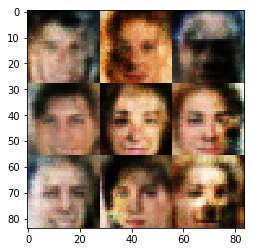

Step: 1010: Epoch 1/2... Discriminator Loss: 0.6242... Generator Loss: 2.9278
Step: 1020: Epoch 1/2... Discriminator Loss: 1.1566... Generator Loss: 0.5764
Step: 1030: Epoch 1/2... Discriminator Loss: 0.9808... Generator Loss: 0.6081
Step: 1040: Epoch 1/2... Discriminator Loss: 0.3735... Generator Loss: 2.1001
Step: 1050: Epoch 1/2... Discriminator Loss: 0.8418... Generator Loss: 3.6221
Step: 1060: Epoch 1/2... Discriminator Loss: 1.0019... Generator Loss: 3.0351
Step: 1070: Epoch 1/2... Discriminator Loss: 0.4864... Generator Loss: 1.3908
Step: 1080: Epoch 1/2... Discriminator Loss: 0.6228... Generator Loss: 2.7348
Step: 1090: Epoch 1/2... Discriminator Loss: 0.4151... Generator Loss: 1.6370
Step: 1100: Epoch 1/2... Discriminator Loss: 0.6725... Generator Loss: 3.1873


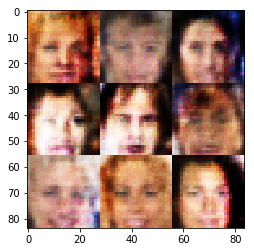

Step: 1110: Epoch 1/2... Discriminator Loss: 1.0470... Generator Loss: 0.5705
Step: 1120: Epoch 1/2... Discriminator Loss: 0.7544... Generator Loss: 3.4623
Step: 1130: Epoch 1/2... Discriminator Loss: 1.1208... Generator Loss: 0.5029
Step: 1140: Epoch 1/2... Discriminator Loss: 1.8393... Generator Loss: 0.2948
Step: 1150: Epoch 1/2... Discriminator Loss: 2.3826... Generator Loss: 0.1183
Step: 1160: Epoch 1/2... Discriminator Loss: 0.3704... Generator Loss: 2.0922
Step: 1170: Epoch 1/2... Discriminator Loss: 0.3238... Generator Loss: 2.3187
Step: 1180: Epoch 1/2... Discriminator Loss: 0.5615... Generator Loss: 2.1678
Step: 1190: Epoch 1/2... Discriminator Loss: 0.6316... Generator Loss: 3.0524
Step: 1200: Epoch 1/2... Discriminator Loss: 0.9031... Generator Loss: 0.6798


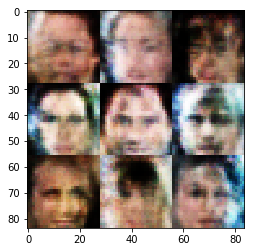

Step: 1210: Epoch 1/2... Discriminator Loss: 1.0343... Generator Loss: 4.1186
Step: 1220: Epoch 1/2... Discriminator Loss: 0.7418... Generator Loss: 0.8364
Step: 1230: Epoch 1/2... Discriminator Loss: 0.3197... Generator Loss: 2.3920
Step: 1240: Epoch 1/2... Discriminator Loss: 0.2917... Generator Loss: 2.5527
Step: 1250: Epoch 1/2... Discriminator Loss: 0.3772... Generator Loss: 2.3960
Step: 1260: Epoch 1/2... Discriminator Loss: 0.6143... Generator Loss: 0.9619
Step: 1270: Epoch 1/2... Discriminator Loss: 0.4465... Generator Loss: 3.0294
Step: 1280: Epoch 1/2... Discriminator Loss: 1.5806... Generator Loss: 0.3199
Step: 1290: Epoch 1/2... Discriminator Loss: 1.2214... Generator Loss: 0.4994
Step: 1300: Epoch 1/2... Discriminator Loss: 0.5845... Generator Loss: 3.7060


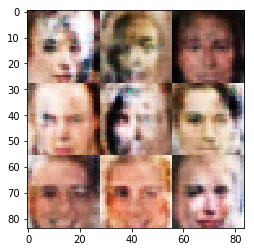

Step: 1310: Epoch 1/2... Discriminator Loss: 0.4993... Generator Loss: 2.3322
Step: 1320: Epoch 1/2... Discriminator Loss: 0.5057... Generator Loss: 1.2812
Step: 1330: Epoch 1/2... Discriminator Loss: 0.7838... Generator Loss: 0.8468
Step: 1340: Epoch 1/2... Discriminator Loss: 0.6619... Generator Loss: 0.9564
Step: 1350: Epoch 1/2... Discriminator Loss: 0.5925... Generator Loss: 1.0561
Step: 1360: Epoch 1/2... Discriminator Loss: 0.2435... Generator Loss: 2.5669
Step: 1370: Epoch 1/2... Discriminator Loss: 0.2843... Generator Loss: 1.8633
Step: 1380: Epoch 1/2... Discriminator Loss: 0.3002... Generator Loss: 3.3445
Step: 1390: Epoch 1/2... Discriminator Loss: 0.2796... Generator Loss: 2.0712
Step: 1400: Epoch 1/2... Discriminator Loss: 0.4768... Generator Loss: 2.4221


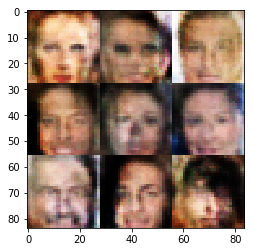

Step: 1410: Epoch 1/2... Discriminator Loss: 0.3043... Generator Loss: 2.0144
Step: 1420: Epoch 1/2... Discriminator Loss: 0.4369... Generator Loss: 2.3023
Step: 1430: Epoch 1/2... Discriminator Loss: 1.2168... Generator Loss: 1.6503
Step: 1440: Epoch 1/2... Discriminator Loss: 0.5035... Generator Loss: 1.7202
Step: 1450: Epoch 1/2... Discriminator Loss: 0.3325... Generator Loss: 2.4656
Step: 1460: Epoch 1/2... Discriminator Loss: 0.7790... Generator Loss: 0.7911
Step: 1470: Epoch 1/2... Discriminator Loss: 0.3875... Generator Loss: 1.5552
Step: 1480: Epoch 1/2... Discriminator Loss: 0.4851... Generator Loss: 3.1683
Step: 1490: Epoch 1/2... Discriminator Loss: 0.9029... Generator Loss: 3.1648
Step: 1500: Epoch 1/2... Discriminator Loss: 0.2542... Generator Loss: 3.4440


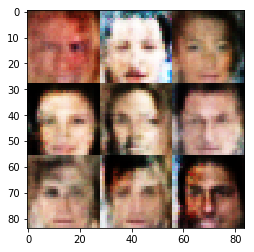

Step: 1510: Epoch 1/2... Discriminator Loss: 0.4375... Generator Loss: 1.2510
Step: 1520: Epoch 1/2... Discriminator Loss: 1.0612... Generator Loss: 0.5335
Step: 1530: Epoch 1/2... Discriminator Loss: 1.2149... Generator Loss: 0.4551
Step: 1540: Epoch 1/2... Discriminator Loss: 0.3230... Generator Loss: 3.2993
Step: 1550: Epoch 1/2... Discriminator Loss: 0.2494... Generator Loss: 2.2127
Step: 1560: Epoch 1/2... Discriminator Loss: 0.4007... Generator Loss: 1.6174
Step: 1570: Epoch 1/2... Discriminator Loss: 0.5468... Generator Loss: 4.0768
Step: 1580: Epoch 1/2... Discriminator Loss: 0.1846... Generator Loss: 3.1162
Step: 1590: Epoch 1/2... Discriminator Loss: 0.9300... Generator Loss: 0.7687
Step: 1600: Epoch 1/2... Discriminator Loss: 0.8951... Generator Loss: 0.6980


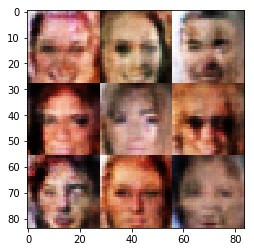

Step: 1610: Epoch 1/2... Discriminator Loss: 1.6410... Generator Loss: 0.2929
Step: 1620: Epoch 1/2... Discriminator Loss: 0.4178... Generator Loss: 1.5725
Step: 1630: Epoch 1/2... Discriminator Loss: 0.1519... Generator Loss: 2.9028
Step: 1640: Epoch 1/2... Discriminator Loss: 0.3844... Generator Loss: 1.6363
Step: 1650: Epoch 1/2... Discriminator Loss: 0.5501... Generator Loss: 1.0672
Step: 1660: Epoch 1/2... Discriminator Loss: 2.4666... Generator Loss: 0.1366
Step: 1670: Epoch 1/2... Discriminator Loss: 1.2178... Generator Loss: 6.3596
Step: 1680: Epoch 1/2... Discriminator Loss: 0.7470... Generator Loss: 0.8644
Step: 1690: Epoch 1/2... Discriminator Loss: 1.4316... Generator Loss: 0.4160
Step: 1700: Epoch 1/2... Discriminator Loss: 0.2736... Generator Loss: 2.3427


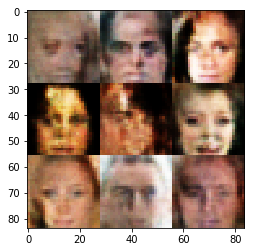

Step: 1710: Epoch 1/2... Discriminator Loss: 0.3140... Generator Loss: 1.7715
Step: 1720: Epoch 1/2... Discriminator Loss: 0.9525... Generator Loss: 0.6760
Step: 1730: Epoch 1/2... Discriminator Loss: 0.1293... Generator Loss: 3.6128
Step: 1740: Epoch 1/2... Discriminator Loss: 0.7496... Generator Loss: 3.9183
Step: 1750: Epoch 1/2... Discriminator Loss: 0.4887... Generator Loss: 1.2397
Step: 1760: Epoch 1/2... Discriminator Loss: 0.5544... Generator Loss: 1.1515
Step: 1770: Epoch 1/2... Discriminator Loss: 0.8625... Generator Loss: 0.7099
Step: 1780: Epoch 1/2... Discriminator Loss: 0.5965... Generator Loss: 1.0456
Step: 1790: Epoch 1/2... Discriminator Loss: 0.2343... Generator Loss: 3.4343
Step: 1800: Epoch 1/2... Discriminator Loss: 0.3203... Generator Loss: 3.4427


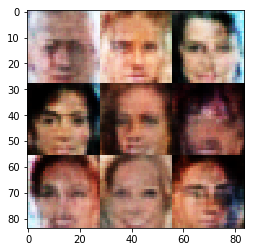

Step: 1810: Epoch 1/2... Discriminator Loss: 0.2278... Generator Loss: 6.0726
Step: 1820: Epoch 1/2... Discriminator Loss: 0.1590... Generator Loss: 3.4597
Step: 1830: Epoch 1/2... Discriminator Loss: 0.2838... Generator Loss: 2.1232
Step: 1840: Epoch 1/2... Discriminator Loss: 1.3169... Generator Loss: 0.5390
Step: 1850: Epoch 1/2... Discriminator Loss: 0.7815... Generator Loss: 0.7428
Step: 1860: Epoch 1/2... Discriminator Loss: 0.1451... Generator Loss: 2.5016
Step: 1870: Epoch 1/2... Discriminator Loss: 0.4350... Generator Loss: 1.3730
Step: 1880: Epoch 1/2... Discriminator Loss: 0.8647... Generator Loss: 5.8538
Step: 1890: Epoch 1/2... Discriminator Loss: 0.1736... Generator Loss: 3.4348
Step: 1900: Epoch 1/2... Discriminator Loss: 0.3975... Generator Loss: 5.6347


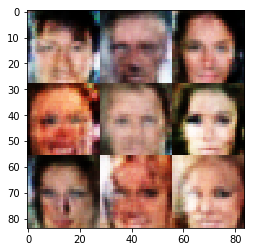

Step: 1910: Epoch 1/2... Discriminator Loss: 0.4869... Generator Loss: 1.2094
Step: 1920: Epoch 1/2... Discriminator Loss: 0.2050... Generator Loss: 4.4159
Step: 1930: Epoch 1/2... Discriminator Loss: 0.1776... Generator Loss: 2.8326
Step: 1940: Epoch 1/2... Discriminator Loss: 0.2651... Generator Loss: 2.0425
Step: 1950: Epoch 1/2... Discriminator Loss: 1.5097... Generator Loss: 3.3662
Step: 1960: Epoch 1/2... Discriminator Loss: 0.1384... Generator Loss: 3.5956
Step: 1970: Epoch 1/2... Discriminator Loss: 1.3488... Generator Loss: 0.4114
Step: 1980: Epoch 1/2... Discriminator Loss: 0.1951... Generator Loss: 2.4932
Step: 1990: Epoch 1/2... Discriminator Loss: 0.2032... Generator Loss: 2.3683
Step: 2000: Epoch 1/2... Discriminator Loss: 0.1333... Generator Loss: 2.9387


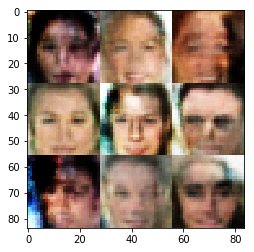

Step: 2010: Epoch 1/2... Discriminator Loss: 0.4852... Generator Loss: 1.2716
Step: 2020: Epoch 1/2... Discriminator Loss: 0.5888... Generator Loss: 1.0035
Step: 2030: Epoch 1/2... Discriminator Loss: 0.0828... Generator Loss: 3.7906
Step: 2040: Epoch 1/2... Discriminator Loss: 0.7224... Generator Loss: 0.8457
Step: 2050: Epoch 1/2... Discriminator Loss: 0.4466... Generator Loss: 1.3475
Step: 2060: Epoch 1/2... Discriminator Loss: 0.2281... Generator Loss: 4.7375
Step: 2070: Epoch 1/2... Discriminator Loss: 0.3039... Generator Loss: 1.9009
Step: 2080: Epoch 1/2... Discriminator Loss: 2.3108... Generator Loss: 0.1487
Step: 2090: Epoch 1/2... Discriminator Loss: 0.7422... Generator Loss: 0.9157
Step: 2100: Epoch 1/2... Discriminator Loss: 0.5773... Generator Loss: 1.0478


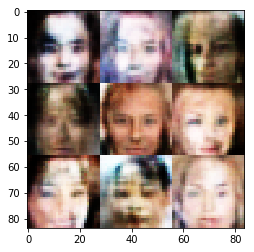

Step: 2110: Epoch 1/2... Discriminator Loss: 0.6033... Generator Loss: 1.0237
Step: 2120: Epoch 1/2... Discriminator Loss: 0.2508... Generator Loss: 1.8921
Step: 2130: Epoch 1/2... Discriminator Loss: 0.1363... Generator Loss: 4.0089
Step: 2140: Epoch 1/2... Discriminator Loss: 0.1512... Generator Loss: 2.5101
Step: 2150: Epoch 1/2... Discriminator Loss: 0.2615... Generator Loss: 5.8161
Step: 2160: Epoch 1/2... Discriminator Loss: 0.1491... Generator Loss: 2.8355
Step: 2170: Epoch 1/2... Discriminator Loss: 0.4285... Generator Loss: 1.8893
Step: 2180: Epoch 1/2... Discriminator Loss: 0.3665... Generator Loss: 1.9522
Step: 2190: Epoch 1/2... Discriminator Loss: 0.3691... Generator Loss: 4.2179
Step: 2200: Epoch 1/2... Discriminator Loss: 0.1455... Generator Loss: 3.4601


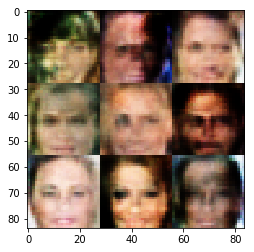

Step: 2210: Epoch 1/2... Discriminator Loss: 0.1924... Generator Loss: 2.8515
Step: 2220: Epoch 1/2... Discriminator Loss: 0.1876... Generator Loss: 2.3939
Step: 2230: Epoch 1/2... Discriminator Loss: 0.1113... Generator Loss: 2.8867
Step: 2240: Epoch 1/2... Discriminator Loss: 0.3008... Generator Loss: 1.7061
Step: 2250: Epoch 1/2... Discriminator Loss: 0.2605... Generator Loss: 3.8985
Step: 2260: Epoch 1/2... Discriminator Loss: 0.2243... Generator Loss: 3.7615
Step: 2270: Epoch 1/2... Discriminator Loss: 0.0760... Generator Loss: 4.4457
Step: 2280: Epoch 1/2... Discriminator Loss: 0.5277... Generator Loss: 2.6593
Step: 2290: Epoch 1/2... Discriminator Loss: 0.2289... Generator Loss: 2.5141
Step: 2300: Epoch 1/2... Discriminator Loss: 0.2949... Generator Loss: 2.8163


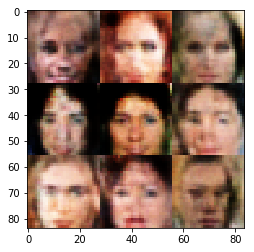

Step: 2310: Epoch 1/2... Discriminator Loss: 0.1292... Generator Loss: 3.0267
Step: 2320: Epoch 1/2... Discriminator Loss: 0.1094... Generator Loss: 4.3392
Step: 2330: Epoch 1/2... Discriminator Loss: 0.1978... Generator Loss: 2.2218
Step: 2340: Epoch 1/2... Discriminator Loss: 2.6784... Generator Loss: 4.8309
Step: 2350: Epoch 1/2... Discriminator Loss: 0.6344... Generator Loss: 1.0236
Step: 2360: Epoch 1/2... Discriminator Loss: 0.2670... Generator Loss: 2.8366
Step: 2370: Epoch 1/2... Discriminator Loss: 0.6452... Generator Loss: 3.2133
Step: 2380: Epoch 1/2... Discriminator Loss: 0.2972... Generator Loss: 3.1471
Step: 2390: Epoch 1/2... Discriminator Loss: 0.1344... Generator Loss: 2.9562
Step: 2400: Epoch 1/2... Discriminator Loss: 0.1866... Generator Loss: 2.4198


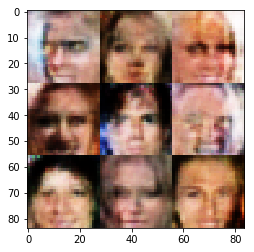

Step: 2410: Epoch 1/2... Discriminator Loss: 0.1827... Generator Loss: 2.2169
Step: 2420: Epoch 1/2... Discriminator Loss: 0.1500... Generator Loss: 2.6308
Step: 2430: Epoch 1/2... Discriminator Loss: 0.2426... Generator Loss: 2.3023
Step: 2440: Epoch 1/2... Discriminator Loss: 1.2068... Generator Loss: 0.4588
Step: 2450: Epoch 1/2... Discriminator Loss: 0.7506... Generator Loss: 0.9989
Step: 2460: Epoch 1/2... Discriminator Loss: 0.4203... Generator Loss: 1.4930
Step: 2470: Epoch 1/2... Discriminator Loss: 0.2990... Generator Loss: 2.0748
Step: 2480: Epoch 1/2... Discriminator Loss: 0.1917... Generator Loss: 2.4218
Step: 2490: Epoch 1/2... Discriminator Loss: 0.4296... Generator Loss: 4.4911
Step: 2500: Epoch 1/2... Discriminator Loss: 0.8944... Generator Loss: 4.2233


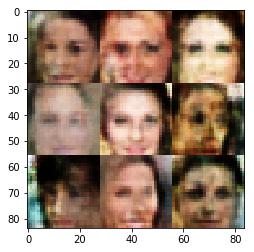

Step: 2510: Epoch 1/2... Discriminator Loss: 0.1118... Generator Loss: 3.3846
Step: 2520: Epoch 1/2... Discriminator Loss: 0.2804... Generator Loss: 1.9582
Step: 2530: Epoch 1/2... Discriminator Loss: 0.4131... Generator Loss: 1.7722
Step: 2540: Epoch 1/2... Discriminator Loss: 0.2665... Generator Loss: 1.9633
Step: 2550: Epoch 1/2... Discriminator Loss: 0.1585... Generator Loss: 5.5991
Step: 2560: Epoch 1/2... Discriminator Loss: 0.1472... Generator Loss: 3.3445
Step: 2570: Epoch 1/2... Discriminator Loss: 0.0747... Generator Loss: 4.5811
Step: 2580: Epoch 1/2... Discriminator Loss: 1.5204... Generator Loss: 0.3514
Step: 2590: Epoch 1/2... Discriminator Loss: 0.5605... Generator Loss: 1.4090
Step: 2600: Epoch 1/2... Discriminator Loss: 0.5510... Generator Loss: 1.9829


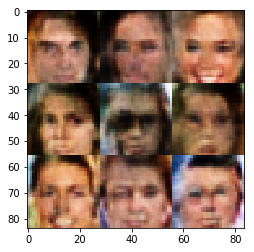

Step: 2610: Epoch 1/2... Discriminator Loss: 0.1907... Generator Loss: 2.3229
Step: 2620: Epoch 1/2... Discriminator Loss: 0.3815... Generator Loss: 1.5734
Step: 2630: Epoch 1/2... Discriminator Loss: 0.4235... Generator Loss: 2.7373
Step: 2640: Epoch 1/2... Discriminator Loss: 0.2569... Generator Loss: 2.1063
Step: 2650: Epoch 1/2... Discriminator Loss: 0.1704... Generator Loss: 2.9104
Step: 2660: Epoch 1/2... Discriminator Loss: 3.8009... Generator Loss: 5.1774
Step: 2670: Epoch 1/2... Discriminator Loss: 0.7705... Generator Loss: 0.8429
Step: 2680: Epoch 1/2... Discriminator Loss: 0.2555... Generator Loss: 2.4193
Step: 2690: Epoch 1/2... Discriminator Loss: 0.2857... Generator Loss: 1.9901
Step: 2700: Epoch 1/2... Discriminator Loss: 0.1818... Generator Loss: 2.7428


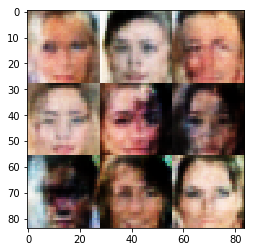

Step: 2710: Epoch 1/2... Discriminator Loss: 0.1591... Generator Loss: 2.6110
Step: 2720: Epoch 1/2... Discriminator Loss: 0.0868... Generator Loss: 4.5107
Step: 2730: Epoch 1/2... Discriminator Loss: 0.4027... Generator Loss: 1.4549
Step: 2740: Epoch 1/2... Discriminator Loss: 0.3702... Generator Loss: 1.5500
Step: 2750: Epoch 1/2... Discriminator Loss: 0.3292... Generator Loss: 1.7210
Step: 2760: Epoch 1/2... Discriminator Loss: 0.1875... Generator Loss: 2.4668
Step: 2770: Epoch 1/2... Discriminator Loss: 0.6197... Generator Loss: 3.5926
Step: 2780: Epoch 1/2... Discriminator Loss: 1.1299... Generator Loss: 0.5785
Step: 2790: Epoch 1/2... Discriminator Loss: 0.2294... Generator Loss: 2.5020
Step: 2800: Epoch 1/2... Discriminator Loss: 0.2631... Generator Loss: 2.3964


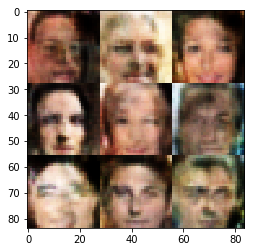

Step: 2810: Epoch 1/2... Discriminator Loss: 0.1974... Generator Loss: 5.0746
Step: 2820: Epoch 1/2... Discriminator Loss: 0.8565... Generator Loss: 0.8915
Step: 2830: Epoch 1/2... Discriminator Loss: 0.7021... Generator Loss: 3.2151
Step: 2840: Epoch 1/2... Discriminator Loss: 0.7925... Generator Loss: 0.7952
Step: 2850: Epoch 1/2... Discriminator Loss: 0.2420... Generator Loss: 2.3439
Step: 2860: Epoch 1/2... Discriminator Loss: 0.1902... Generator Loss: 2.6503
Step: 2870: Epoch 1/2... Discriminator Loss: 0.3066... Generator Loss: 4.0518
Step: 2880: Epoch 1/2... Discriminator Loss: 0.2101... Generator Loss: 3.6555
Step: 2890: Epoch 1/2... Discriminator Loss: 0.5748... Generator Loss: 5.1543
Step: 2900: Epoch 1/2... Discriminator Loss: 1.3606... Generator Loss: 0.4982


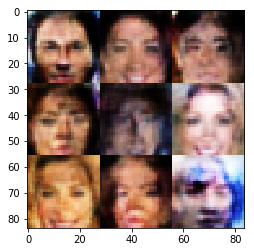

Step: 2910: Epoch 1/2... Discriminator Loss: 0.4119... Generator Loss: 1.9554
Step: 2920: Epoch 1/2... Discriminator Loss: 0.7961... Generator Loss: 0.8341
Step: 2930: Epoch 1/2... Discriminator Loss: 0.2369... Generator Loss: 2.1990
Step: 2940: Epoch 1/2... Discriminator Loss: 0.4795... Generator Loss: 1.4081
Step: 2950: Epoch 1/2... Discriminator Loss: 0.1418... Generator Loss: 3.0044
Step: 2960: Epoch 1/2... Discriminator Loss: 0.3966... Generator Loss: 2.2994
Step: 2970: Epoch 1/2... Discriminator Loss: 0.1659... Generator Loss: 2.6153
Step: 2980: Epoch 1/2... Discriminator Loss: 0.7875... Generator Loss: 0.8626
Step: 2990: Epoch 1/2... Discriminator Loss: 0.0630... Generator Loss: 3.9623
Step: 3000: Epoch 1/2... Discriminator Loss: 0.4972... Generator Loss: 3.4077


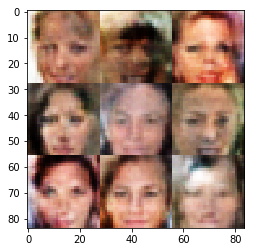

Step: 3010: Epoch 1/2... Discriminator Loss: 0.2199... Generator Loss: 2.3531
Step: 3020: Epoch 1/2... Discriminator Loss: 0.2321... Generator Loss: 3.7866
Step: 3030: Epoch 1/2... Discriminator Loss: 0.2872... Generator Loss: 2.9080
Step: 3040: Epoch 1/2... Discriminator Loss: 0.6050... Generator Loss: 1.0249
Step: 3050: Epoch 1/2... Discriminator Loss: 0.1638... Generator Loss: 2.5505
Step: 3060: Epoch 1/2... Discriminator Loss: 0.2494... Generator Loss: 2.6634
Step: 3070: Epoch 1/2... Discriminator Loss: 0.1626... Generator Loss: 2.6762
Step: 3080: Epoch 1/2... Discriminator Loss: 0.1223... Generator Loss: 3.0692
Step: 3090: Epoch 1/2... Discriminator Loss: 0.2630... Generator Loss: 1.9679
Step: 3100: Epoch 1/2... Discriminator Loss: 0.3436... Generator Loss: 1.6508


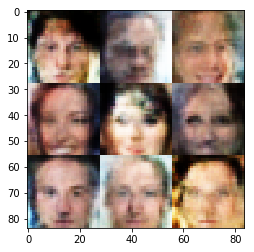

Step: 3110: Epoch 1/2... Discriminator Loss: 0.0399... Generator Loss: 5.1517
Step: 3120: Epoch 1/2... Discriminator Loss: 0.0612... Generator Loss: 4.8589
Step: 3130: Epoch 1/2... Discriminator Loss: 0.6749... Generator Loss: 3.2747
Step: 3140: Epoch 1/2... Discriminator Loss: 0.1629... Generator Loss: 2.8317
Step: 3150: Epoch 1/2... Discriminator Loss: 0.0876... Generator Loss: 3.8257
Step: 3160: Epoch 1/2... Discriminator Loss: 0.0941... Generator Loss: 4.6374
Step: 3170: Epoch 1/2... Discriminator Loss: 0.0629... Generator Loss: 5.0272
Step: 3180: Epoch 1/2... Discriminator Loss: 0.1884... Generator Loss: 3.3261
Step: 3190: Epoch 1/2... Discriminator Loss: 0.0819... Generator Loss: 3.9866
Step: 3200: Epoch 1/2... Discriminator Loss: 0.2963... Generator Loss: 2.0738


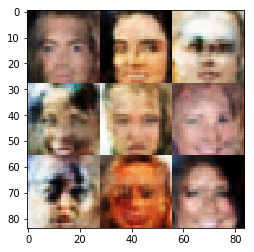

Step: 3210: Epoch 1/2... Discriminator Loss: 0.0859... Generator Loss: 3.9168
Step: 3220: Epoch 1/2... Discriminator Loss: 0.1554... Generator Loss: 2.3875
Step: 3230: Epoch 1/2... Discriminator Loss: 0.4149... Generator Loss: 2.4727
Step: 3240: Epoch 1/2... Discriminator Loss: 1.5172... Generator Loss: 1.9718
Step: 3250: Epoch 1/2... Discriminator Loss: 0.6851... Generator Loss: 1.5346
Step: 3260: Epoch 1/2... Discriminator Loss: 0.8158... Generator Loss: 2.7241
Step: 3270: Epoch 1/2... Discriminator Loss: 0.6726... Generator Loss: 0.9945
Step: 3280: Epoch 1/2... Discriminator Loss: 0.3218... Generator Loss: 1.8235
Step: 3290: Epoch 1/2... Discriminator Loss: 1.0993... Generator Loss: 0.5070
Step: 3300: Epoch 1/2... Discriminator Loss: 0.3982... Generator Loss: 1.6413


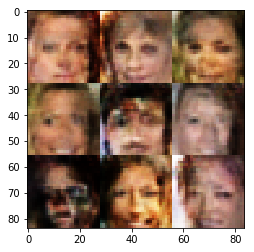

Step: 3310: Epoch 1/2... Discriminator Loss: 0.3614... Generator Loss: 2.5828
Step: 3320: Epoch 1/2... Discriminator Loss: 0.2006... Generator Loss: 3.7546
Step: 3330: Epoch 1/2... Discriminator Loss: 0.6502... Generator Loss: 0.9628
Step: 3340: Epoch 1/2... Discriminator Loss: 0.1389... Generator Loss: 2.9487
Step: 3350: Epoch 1/2... Discriminator Loss: 0.7797... Generator Loss: 0.7973
Step: 3360: Epoch 1/2... Discriminator Loss: 0.1385... Generator Loss: 3.0065
Step: 3370: Epoch 1/2... Discriminator Loss: 0.1441... Generator Loss: 2.9354
Step: 3380: Epoch 1/2... Discriminator Loss: 0.4772... Generator Loss: 1.2219
Step: 3390: Epoch 1/2... Discriminator Loss: 0.5049... Generator Loss: 3.1902
Step: 3400: Epoch 1/2... Discriminator Loss: 0.3121... Generator Loss: 1.9249


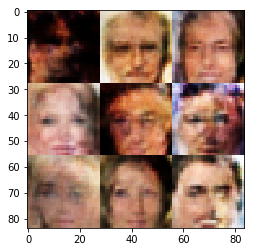

Step: 3410: Epoch 1/2... Discriminator Loss: 0.1176... Generator Loss: 3.0421
Step: 3420: Epoch 1/2... Discriminator Loss: 0.1851... Generator Loss: 3.8911
Step: 3430: Epoch 1/2... Discriminator Loss: 2.7893... Generator Loss: 0.1028
Step: 3440: Epoch 1/2... Discriminator Loss: 0.3391... Generator Loss: 1.8011
Step: 3450: Epoch 1/2... Discriminator Loss: 0.3867... Generator Loss: 1.5998
Step: 3460: Epoch 1/2... Discriminator Loss: 0.8399... Generator Loss: 0.8810
Step: 3470: Epoch 1/2... Discriminator Loss: 0.2835... Generator Loss: 1.9325
Step: 3480: Epoch 1/2... Discriminator Loss: 1.8657... Generator Loss: 3.7002
Step: 3490: Epoch 1/2... Discriminator Loss: 0.2649... Generator Loss: 2.1400
Step: 3500: Epoch 1/2... Discriminator Loss: 0.1261... Generator Loss: 4.3211


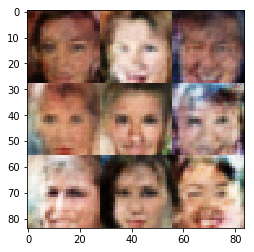

Step: 3510: Epoch 1/2... Discriminator Loss: 0.3742... Generator Loss: 1.7199
Step: 3520: Epoch 1/2... Discriminator Loss: 0.5169... Generator Loss: 1.1971
Step: 3530: Epoch 1/2... Discriminator Loss: 0.4129... Generator Loss: 1.3772
Step: 3540: Epoch 1/2... Discriminator Loss: 0.1927... Generator Loss: 2.4844
Step: 3550: Epoch 1/2... Discriminator Loss: 0.5062... Generator Loss: 2.5429
Step: 3560: Epoch 1/2... Discriminator Loss: 0.5174... Generator Loss: 1.3424
Step: 3570: Epoch 1/2... Discriminator Loss: 0.3475... Generator Loss: 2.3515
Step: 3580: Epoch 1/2... Discriminator Loss: 0.2250... Generator Loss: 2.2287
Step: 3590: Epoch 1/2... Discriminator Loss: 0.6438... Generator Loss: 3.0690
Step: 3600: Epoch 1/2... Discriminator Loss: 0.4919... Generator Loss: 1.2228


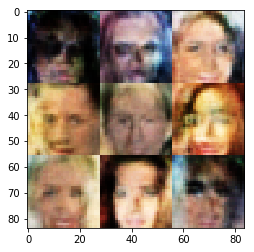

Step: 3610: Epoch 1/2... Discriminator Loss: 0.1607... Generator Loss: 2.5169
Step: 3620: Epoch 1/2... Discriminator Loss: 0.2531... Generator Loss: 2.0193
Step: 3630: Epoch 1/2... Discriminator Loss: 0.9410... Generator Loss: 0.7716
Step: 3640: Epoch 1/2... Discriminator Loss: 0.2653... Generator Loss: 1.8812
Step: 3650: Epoch 1/2... Discriminator Loss: 0.0739... Generator Loss: 5.1911
Step: 3660: Epoch 1/2... Discriminator Loss: 0.3692... Generator Loss: 1.5008
Step: 3670: Epoch 1/2... Discriminator Loss: 0.2562... Generator Loss: 2.0621
Step: 3680: Epoch 1/2... Discriminator Loss: 0.2231... Generator Loss: 2.2863
Step: 3690: Epoch 1/2... Discriminator Loss: 0.2639... Generator Loss: 1.8261
Step: 3700: Epoch 1/2... Discriminator Loss: 0.3649... Generator Loss: 1.6541


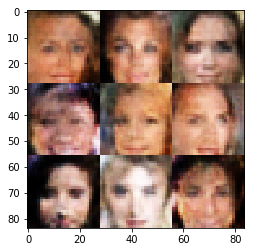

Step: 3710: Epoch 1/2... Discriminator Loss: 0.1819... Generator Loss: 2.2416
Step: 3720: Epoch 1/2... Discriminator Loss: 0.3909... Generator Loss: 3.6851
Step: 3730: Epoch 1/2... Discriminator Loss: 0.2060... Generator Loss: 2.3049
Step: 3740: Epoch 1/2... Discriminator Loss: 0.2389... Generator Loss: 2.1282
Step: 3750: Epoch 1/2... Discriminator Loss: 0.2900... Generator Loss: 3.4990
Step: 3760: Epoch 1/2... Discriminator Loss: 0.2094... Generator Loss: 2.3552
Step: 3770: Epoch 1/2... Discriminator Loss: 0.0923... Generator Loss: 4.2027
Step: 3780: Epoch 1/2... Discriminator Loss: 0.3015... Generator Loss: 1.8155
Step: 3790: Epoch 1/2... Discriminator Loss: 3.7863... Generator Loss: 0.0634
Step: 3800: Epoch 1/2... Discriminator Loss: 2.3430... Generator Loss: 0.1491


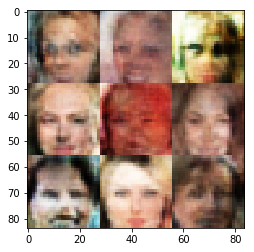

Step: 3810: Epoch 1/2... Discriminator Loss: 1.1915... Generator Loss: 3.6468
Step: 3820: Epoch 1/2... Discriminator Loss: 0.3816... Generator Loss: 1.6581
Step: 3830: Epoch 1/2... Discriminator Loss: 0.2718... Generator Loss: 2.0661
Step: 3840: Epoch 1/2... Discriminator Loss: 0.4101... Generator Loss: 2.5573
Step: 3850: Epoch 1/2... Discriminator Loss: 0.1881... Generator Loss: 4.9493
Step: 3860: Epoch 1/2... Discriminator Loss: 0.1513... Generator Loss: 4.4706
Step: 3870: Epoch 1/2... Discriminator Loss: 1.1837... Generator Loss: 0.4622
Step: 3880: Epoch 1/2... Discriminator Loss: 0.7286... Generator Loss: 0.8763
Step: 3890: Epoch 1/2... Discriminator Loss: 0.1168... Generator Loss: 3.2591
Step: 3900: Epoch 1/2... Discriminator Loss: 0.2922... Generator Loss: 1.9388


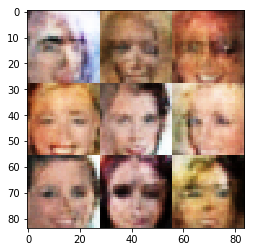

Step: 3910: Epoch 1/2... Discriminator Loss: 0.3946... Generator Loss: 1.3808
Step: 3920: Epoch 1/2... Discriminator Loss: 0.3073... Generator Loss: 1.9933
Step: 3930: Epoch 1/2... Discriminator Loss: 0.2510... Generator Loss: 2.8030
Step: 3940: Epoch 1/2... Discriminator Loss: 0.3667... Generator Loss: 2.8123
Step: 3950: Epoch 1/2... Discriminator Loss: 0.2608... Generator Loss: 3.0075
Step: 3960: Epoch 1/2... Discriminator Loss: 0.0947... Generator Loss: 3.1626
Step: 3970: Epoch 1/2... Discriminator Loss: 1.4401... Generator Loss: 0.7705
Step: 3980: Epoch 1/2... Discriminator Loss: 2.0063... Generator Loss: 0.2656
Step: 3990: Epoch 1/2... Discriminator Loss: 1.0887... Generator Loss: 0.6576
Step: 4000: Epoch 1/2... Discriminator Loss: 1.0086... Generator Loss: 0.6089


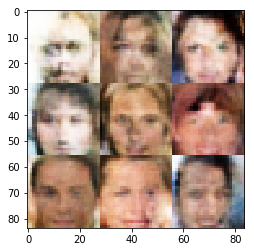

Step: 4010: Epoch 1/2... Discriminator Loss: 0.7082... Generator Loss: 1.5151
Step: 4020: Epoch 1/2... Discriminator Loss: 0.9876... Generator Loss: 0.6758
Step: 4030: Epoch 1/2... Discriminator Loss: 1.4434... Generator Loss: 0.3216
Step: 4040: Epoch 1/2... Discriminator Loss: 0.5383... Generator Loss: 1.1788
Step: 4050: Epoch 1/2... Discriminator Loss: 0.3495... Generator Loss: 1.7753
Step: 4060: Epoch 1/2... Discriminator Loss: 1.0149... Generator Loss: 0.6587
Step: 4070: Epoch 1/2... Discriminator Loss: 0.9591... Generator Loss: 0.6062
Step: 4080: Epoch 1/2... Discriminator Loss: 0.3337... Generator Loss: 1.6269
Step: 4090: Epoch 1/2... Discriminator Loss: 0.1647... Generator Loss: 3.0934
Step: 4100: Epoch 1/2... Discriminator Loss: 0.3940... Generator Loss: 1.5133


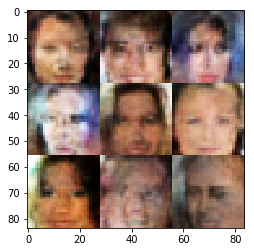

Step: 4110: Epoch 1/2... Discriminator Loss: 0.2035... Generator Loss: 2.3955
Step: 4120: Epoch 1/2... Discriminator Loss: 0.1193... Generator Loss: 4.2621
Step: 4130: Epoch 1/2... Discriminator Loss: 0.7575... Generator Loss: 0.7982
Step: 4140: Epoch 1/2... Discriminator Loss: 0.1259... Generator Loss: 3.2794
Step: 4150: Epoch 1/2... Discriminator Loss: 0.1986... Generator Loss: 2.3718
Step: 4160: Epoch 1/2... Discriminator Loss: 0.3159... Generator Loss: 1.8762
Step: 4170: Epoch 1/2... Discriminator Loss: 0.6524... Generator Loss: 0.9247
Step: 4180: Epoch 1/2... Discriminator Loss: 0.2098... Generator Loss: 2.3560
Step: 4190: Epoch 1/2... Discriminator Loss: 0.7562... Generator Loss: 4.3572
Step: 4200: Epoch 1/2... Discriminator Loss: 0.5990... Generator Loss: 1.0403


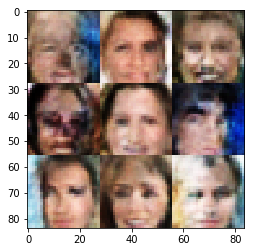

Step: 4210: Epoch 1/2... Discriminator Loss: 0.2884... Generator Loss: 2.0436
Step: 4220: Epoch 1/2... Discriminator Loss: 1.0565... Generator Loss: 0.6224
Step: 4230: Epoch 1/2... Discriminator Loss: 0.4986... Generator Loss: 1.4992
Step: 4240: Epoch 1/2... Discriminator Loss: 0.5221... Generator Loss: 1.2630
Step: 4250: Epoch 1/2... Discriminator Loss: 0.1298... Generator Loss: 3.5374
Step: 4260: Epoch 1/2... Discriminator Loss: 0.1159... Generator Loss: 3.1653
Step: 4270: Epoch 1/2... Discriminator Loss: 0.1203... Generator Loss: 2.9812
Step: 4280: Epoch 1/2... Discriminator Loss: 0.4701... Generator Loss: 3.2513
Step: 4290: Epoch 1/2... Discriminator Loss: 0.6987... Generator Loss: 0.9116
Step: 4300: Epoch 1/2... Discriminator Loss: 0.4596... Generator Loss: 1.3519


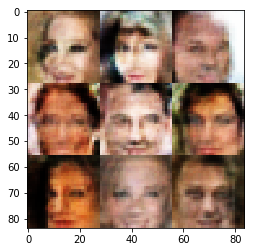

Step: 4310: Epoch 1/2... Discriminator Loss: 0.3705... Generator Loss: 1.5804
Step: 4320: Epoch 1/2... Discriminator Loss: 0.2572... Generator Loss: 2.1207
Step: 4330: Epoch 1/2... Discriminator Loss: 0.3503... Generator Loss: 1.6829
Step: 4340: Epoch 1/2... Discriminator Loss: 0.2740... Generator Loss: 2.0873
Step: 4350: Epoch 1/2... Discriminator Loss: 0.4074... Generator Loss: 1.4940
Step: 4360: Epoch 1/2... Discriminator Loss: 2.5051... Generator Loss: 0.3328
Step: 4370: Epoch 1/2... Discriminator Loss: 0.4127... Generator Loss: 2.9128
Step: 4380: Epoch 1/2... Discriminator Loss: 0.5627... Generator Loss: 1.3491
Step: 4390: Epoch 1/2... Discriminator Loss: 0.2490... Generator Loss: 2.1976
Step: 4400: Epoch 1/2... Discriminator Loss: 0.3160... Generator Loss: 1.9635


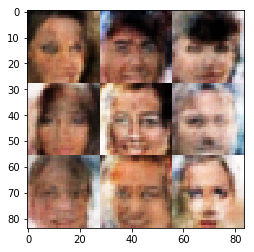

Step: 4410: Epoch 1/2... Discriminator Loss: 0.1290... Generator Loss: 3.2268
Step: 4420: Epoch 1/2... Discriminator Loss: 0.9061... Generator Loss: 0.6868
Step: 4430: Epoch 1/2... Discriminator Loss: 0.4882... Generator Loss: 1.5111
Step: 4440: Epoch 1/2... Discriminator Loss: 0.3663... Generator Loss: 1.6011
Step: 4450: Epoch 1/2... Discriminator Loss: 1.2264... Generator Loss: 0.4875
Step: 4460: Epoch 1/2... Discriminator Loss: 0.3059... Generator Loss: 1.9094
Step: 4470: Epoch 1/2... Discriminator Loss: 0.1320... Generator Loss: 2.9740
Step: 4480: Epoch 1/2... Discriminator Loss: 0.3222... Generator Loss: 1.8682
Step: 4490: Epoch 1/2... Discriminator Loss: 0.2893... Generator Loss: 2.0487
Step: 4500: Epoch 1/2... Discriminator Loss: 0.1628... Generator Loss: 2.4780


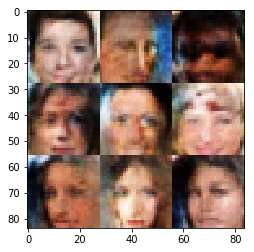

Step: 4510: Epoch 1/2... Discriminator Loss: 0.2604... Generator Loss: 1.9188
Step: 4520: Epoch 1/2... Discriminator Loss: 0.5178... Generator Loss: 1.2518
Step: 4530: Epoch 1/2... Discriminator Loss: 0.2076... Generator Loss: 2.5350
Step: 4540: Epoch 1/2... Discriminator Loss: 0.3160... Generator Loss: 1.6742
Step: 4550: Epoch 1/2... Discriminator Loss: 0.2886... Generator Loss: 1.9242
Step: 4560: Epoch 1/2... Discriminator Loss: 0.2364... Generator Loss: 2.7906
Step: 4570: Epoch 1/2... Discriminator Loss: 0.0726... Generator Loss: 3.7730
Step: 4580: Epoch 1/2... Discriminator Loss: 0.1938... Generator Loss: 7.7852
Step: 4590: Epoch 1/2... Discriminator Loss: 0.4747... Generator Loss: 1.3072
Step: 4600: Epoch 1/2... Discriminator Loss: 0.0960... Generator Loss: 3.5852


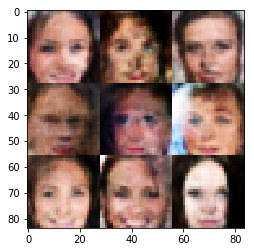

Step: 4610: Epoch 1/2... Discriminator Loss: 0.4251... Generator Loss: 1.3807
Step: 4620: Epoch 1/2... Discriminator Loss: 0.2336... Generator Loss: 2.9173
Step: 4630: Epoch 1/2... Discriminator Loss: 0.0464... Generator Loss: 5.1770
Step: 4640: Epoch 1/2... Discriminator Loss: 0.6639... Generator Loss: 0.9558
Step: 4650: Epoch 1/2... Discriminator Loss: 0.0636... Generator Loss: 4.4651
Step: 4660: Epoch 1/2... Discriminator Loss: 1.2651... Generator Loss: 2.6464
Step: 4670: Epoch 1/2... Discriminator Loss: 0.5711... Generator Loss: 1.2258
Step: 4680: Epoch 1/2... Discriminator Loss: 0.3674... Generator Loss: 1.8202
Step: 4690: Epoch 1/2... Discriminator Loss: 1.4551... Generator Loss: 0.3246
Step: 4700: Epoch 1/2... Discriminator Loss: 0.3350... Generator Loss: 3.4909


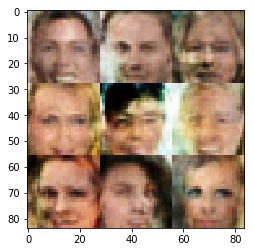

Step: 4710: Epoch 1/2... Discriminator Loss: 0.1845... Generator Loss: 2.8159
Step: 4720: Epoch 1/2... Discriminator Loss: 0.4174... Generator Loss: 1.3838
Step: 4730: Epoch 1/2... Discriminator Loss: 2.0508... Generator Loss: 0.2393
Step: 4740: Epoch 1/2... Discriminator Loss: 0.5219... Generator Loss: 1.8418
Step: 4750: Epoch 1/2... Discriminator Loss: 0.6986... Generator Loss: 1.0285
Step: 4760: Epoch 1/2... Discriminator Loss: 1.2945... Generator Loss: 4.7906
Step: 4770: Epoch 1/2... Discriminator Loss: 0.8707... Generator Loss: 1.1693
Step: 4780: Epoch 1/2... Discriminator Loss: 1.0506... Generator Loss: 0.5626
Step: 4790: Epoch 1/2... Discriminator Loss: 0.6470... Generator Loss: 1.0973
Step: 4800: Epoch 1/2... Discriminator Loss: 0.6197... Generator Loss: 1.1454


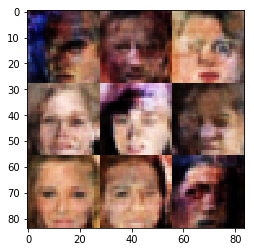

Step: 4810: Epoch 1/2... Discriminator Loss: 0.2665... Generator Loss: 1.9471
Step: 4820: Epoch 1/2... Discriminator Loss: 0.5126... Generator Loss: 1.5364
Step: 4830: Epoch 1/2... Discriminator Loss: 0.6072... Generator Loss: 1.0223
Step: 4840: Epoch 1/2... Discriminator Loss: 0.6360... Generator Loss: 0.9031
Step: 4850: Epoch 1/2... Discriminator Loss: 0.1465... Generator Loss: 3.0671
Step: 4860: Epoch 1/2... Discriminator Loss: 0.1307... Generator Loss: 3.1529
Step: 4870: Epoch 1/2... Discriminator Loss: 1.0110... Generator Loss: 0.5719
Step: 4880: Epoch 1/2... Discriminator Loss: 0.2630... Generator Loss: 1.9670
Step: 4890: Epoch 1/2... Discriminator Loss: 0.1348... Generator Loss: 3.0064
Step: 4900: Epoch 1/2... Discriminator Loss: 0.6540... Generator Loss: 0.9440


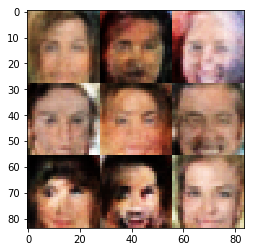

Step: 4910: Epoch 1/2... Discriminator Loss: 0.5876... Generator Loss: 1.1108
Step: 4920: Epoch 1/2... Discriminator Loss: 3.3594... Generator Loss: 0.0720
Step: 4930: Epoch 1/2... Discriminator Loss: 1.6565... Generator Loss: 0.2962
Step: 4940: Epoch 1/2... Discriminator Loss: 0.1933... Generator Loss: 2.5923
Step: 4950: Epoch 1/2... Discriminator Loss: 0.3525... Generator Loss: 1.7858
Step: 4960: Epoch 1/2... Discriminator Loss: 0.1638... Generator Loss: 2.5099
Step: 4970: Epoch 1/2... Discriminator Loss: 0.4996... Generator Loss: 1.0891
Step: 4980: Epoch 1/2... Discriminator Loss: 0.5089... Generator Loss: 1.4443
Step: 4990: Epoch 1/2... Discriminator Loss: 0.3003... Generator Loss: 2.2304
Step: 5000: Epoch 1/2... Discriminator Loss: 0.2832... Generator Loss: 2.0695


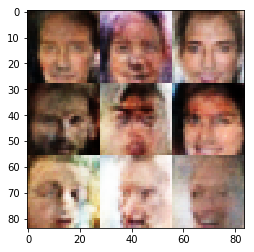

Step: 5010: Epoch 1/2... Discriminator Loss: 0.6060... Generator Loss: 0.9849
Step: 5020: Epoch 1/2... Discriminator Loss: 0.1110... Generator Loss: 2.9281
Step: 5030: Epoch 1/2... Discriminator Loss: 0.3367... Generator Loss: 1.6306
Step: 5040: Epoch 1/2... Discriminator Loss: 1.8486... Generator Loss: 5.5711
Step: 5050: Epoch 1/2... Discriminator Loss: 0.8224... Generator Loss: 0.7906
Step: 5060: Epoch 1/2... Discriminator Loss: 0.3996... Generator Loss: 1.5352
Step: 5070: Epoch 1/2... Discriminator Loss: 0.6335... Generator Loss: 1.0124
Step: 5080: Epoch 1/2... Discriminator Loss: 0.2663... Generator Loss: 2.0268
Step: 5090: Epoch 1/2... Discriminator Loss: 0.8665... Generator Loss: 0.6496
Step: 5100: Epoch 1/2... Discriminator Loss: 3.2223... Generator Loss: 6.1962


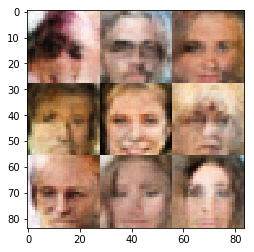

Step: 5110: Epoch 1/2... Discriminator Loss: 1.5554... Generator Loss: 0.3158
Step: 5120: Epoch 1/2... Discriminator Loss: 0.4300... Generator Loss: 1.6009
Step: 5130: Epoch 1/2... Discriminator Loss: 0.2118... Generator Loss: 2.3480
Step: 5140: Epoch 1/2... Discriminator Loss: 0.4165... Generator Loss: 1.8915
Step: 5150: Epoch 1/2... Discriminator Loss: 0.5773... Generator Loss: 0.9919
Step: 5160: Epoch 1/2... Discriminator Loss: 0.2499... Generator Loss: 2.0463
Step: 5170: Epoch 1/2... Discriminator Loss: 0.6039... Generator Loss: 4.1457
Step: 5180: Epoch 1/2... Discriminator Loss: 0.1439... Generator Loss: 2.9174
Step: 5190: Epoch 1/2... Discriminator Loss: 0.1481... Generator Loss: 2.5356
Step: 5200: Epoch 1/2... Discriminator Loss: 0.6030... Generator Loss: 1.0115


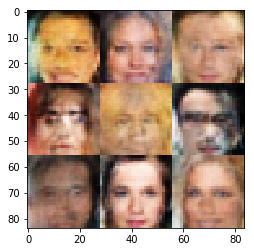

Step: 5210: Epoch 1/2... Discriminator Loss: 0.2891... Generator Loss: 1.9088
Step: 5220: Epoch 1/2... Discriminator Loss: 0.4909... Generator Loss: 1.3442
Step: 5230: Epoch 1/2... Discriminator Loss: 0.6617... Generator Loss: 0.8938
Step: 5240: Epoch 1/2... Discriminator Loss: 0.2981... Generator Loss: 2.1638
Step: 5250: Epoch 1/2... Discriminator Loss: 0.4510... Generator Loss: 1.3364
Step: 5260: Epoch 1/2... Discriminator Loss: 0.1089... Generator Loss: 2.9387
Step: 5270: Epoch 1/2... Discriminator Loss: 0.3490... Generator Loss: 1.4440
Step: 5280: Epoch 1/2... Discriminator Loss: 0.1999... Generator Loss: 2.2787
Step: 5290: Epoch 1/2... Discriminator Loss: 0.7510... Generator Loss: 0.8487
Step: 5300: Epoch 1/2... Discriminator Loss: 0.0733... Generator Loss: 4.1808


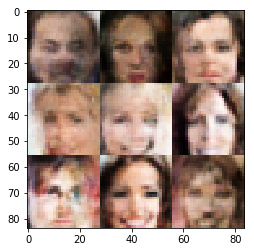

Step: 5310: Epoch 1/2... Discriminator Loss: 0.3608... Generator Loss: 3.4602
Step: 5320: Epoch 1/2... Discriminator Loss: 0.4335... Generator Loss: 1.3427
Step: 5330: Epoch 1/2... Discriminator Loss: 0.1135... Generator Loss: 2.9434
Step: 5340: Epoch 1/2... Discriminator Loss: 0.4537... Generator Loss: 4.5252
Step: 5350: Epoch 1/2... Discriminator Loss: 0.4342... Generator Loss: 1.2731
Step: 5360: Epoch 1/2... Discriminator Loss: 0.1564... Generator Loss: 2.4603
Step: 5370: Epoch 1/2... Discriminator Loss: 1.8655... Generator Loss: 0.3011
Step: 5380: Epoch 1/2... Discriminator Loss: 0.7368... Generator Loss: 1.8640
Step: 5390: Epoch 1/2... Discriminator Loss: 0.6266... Generator Loss: 1.0817
Step: 5400: Epoch 1/2... Discriminator Loss: 0.6435... Generator Loss: 0.9603


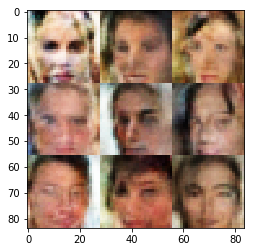

Step: 5410: Epoch 1/2... Discriminator Loss: 0.4381... Generator Loss: 1.5102
Step: 5420: Epoch 1/2... Discriminator Loss: 0.3379... Generator Loss: 2.4963
Step: 5430: Epoch 1/2... Discriminator Loss: 0.4757... Generator Loss: 1.4005
Step: 5440: Epoch 1/2... Discriminator Loss: 0.3749... Generator Loss: 1.7698
Step: 5450: Epoch 1/2... Discriminator Loss: 0.3049... Generator Loss: 4.3811
Step: 5460: Epoch 1/2... Discriminator Loss: 0.6048... Generator Loss: 1.1645
Step: 5470: Epoch 1/2... Discriminator Loss: 0.1228... Generator Loss: 3.2624
Step: 5480: Epoch 1/2... Discriminator Loss: 0.5167... Generator Loss: 1.3382
Step: 5490: Epoch 1/2... Discriminator Loss: 0.2213... Generator Loss: 3.1442
Step: 5500: Epoch 1/2... Discriminator Loss: 0.6099... Generator Loss: 0.9134


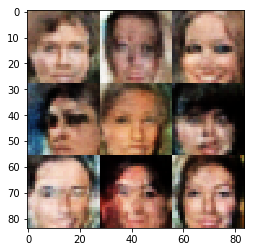

Step: 5510: Epoch 1/2... Discriminator Loss: 0.3775... Generator Loss: 1.5155
Step: 5520: Epoch 1/2... Discriminator Loss: 0.3686... Generator Loss: 1.7993
Step: 5530: Epoch 1/2... Discriminator Loss: 0.1286... Generator Loss: 2.6550
Step: 5540: Epoch 1/2... Discriminator Loss: 0.2900... Generator Loss: 1.8313
Step: 5550: Epoch 1/2... Discriminator Loss: 0.0803... Generator Loss: 3.1629
Step: 5560: Epoch 1/2... Discriminator Loss: 0.2841... Generator Loss: 1.7730
Step: 5570: Epoch 1/2... Discriminator Loss: 0.1768... Generator Loss: 2.9670
Step: 5580: Epoch 1/2... Discriminator Loss: 0.2447... Generator Loss: 1.9580
Step: 5590: Epoch 1/2... Discriminator Loss: 0.1152... Generator Loss: 4.8134
Step: 5600: Epoch 1/2... Discriminator Loss: 0.4669... Generator Loss: 1.5283


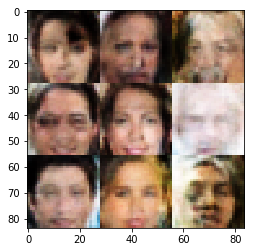

Step: 5610: Epoch 1/2... Discriminator Loss: 3.5751... Generator Loss: 0.0612
Step: 5620: Epoch 1/2... Discriminator Loss: 1.3061... Generator Loss: 2.3998
Step: 5630: Epoch 1/2... Discriminator Loss: 0.9501... Generator Loss: 4.9077
Step: 5640: Epoch 1/2... Discriminator Loss: 0.6456... Generator Loss: 1.6352
Step: 5650: Epoch 1/2... Discriminator Loss: 1.5308... Generator Loss: 0.3552
Step: 5660: Epoch 1/2... Discriminator Loss: 0.6306... Generator Loss: 0.9866
Step: 5670: Epoch 1/2... Discriminator Loss: 0.2094... Generator Loss: 2.6888
Step: 5680: Epoch 1/2... Discriminator Loss: 0.5307... Generator Loss: 1.3834
Step: 5690: Epoch 1/2... Discriminator Loss: 0.3919... Generator Loss: 1.5084
Step: 5700: Epoch 1/2... Discriminator Loss: 0.1614... Generator Loss: 2.6989


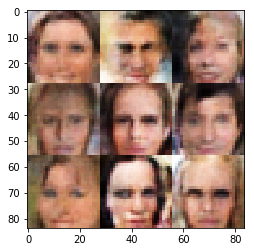

Step: 5710: Epoch 1/2... Discriminator Loss: 0.2172... Generator Loss: 3.9346
Step: 5720: Epoch 1/2... Discriminator Loss: 0.7873... Generator Loss: 0.7901
Step: 5730: Epoch 1/2... Discriminator Loss: 0.5350... Generator Loss: 1.1711
Step: 5740: Epoch 1/2... Discriminator Loss: 0.4730... Generator Loss: 1.3968
Step: 5750: Epoch 1/2... Discriminator Loss: 0.3941... Generator Loss: 2.5284
Step: 5760: Epoch 1/2... Discriminator Loss: 0.1720... Generator Loss: 2.5413
Step: 5770: Epoch 1/2... Discriminator Loss: 0.2513... Generator Loss: 2.0154
Step: 5780: Epoch 1/2... Discriminator Loss: 0.0902... Generator Loss: 3.7267
Step: 5790: Epoch 1/2... Discriminator Loss: 1.0453... Generator Loss: 0.5445
Step: 5800: Epoch 1/2... Discriminator Loss: 0.2034... Generator Loss: 2.3456


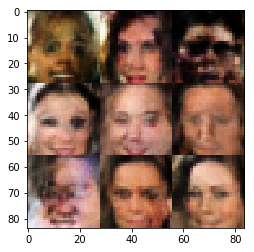

Step: 5810: Epoch 1/2... Discriminator Loss: 0.1007... Generator Loss: 3.8230
Step: 5820: Epoch 1/2... Discriminator Loss: 0.2758... Generator Loss: 1.8699
Step: 5830: Epoch 1/2... Discriminator Loss: 0.2329... Generator Loss: 2.1986
Step: 5840: Epoch 1/2... Discriminator Loss: 0.1538... Generator Loss: 2.5131
Step: 5850: Epoch 1/2... Discriminator Loss: 0.1158... Generator Loss: 3.3576
Step: 5860: Epoch 1/2... Discriminator Loss: 0.1604... Generator Loss: 2.9567
Step: 5870: Epoch 1/2... Discriminator Loss: 0.5662... Generator Loss: 4.4134
Step: 5880: Epoch 1/2... Discriminator Loss: 0.5703... Generator Loss: 1.2179
Step: 5890: Epoch 1/2... Discriminator Loss: 0.2968... Generator Loss: 3.3796
Step: 5900: Epoch 1/2... Discriminator Loss: 0.0627... Generator Loss: 3.9523


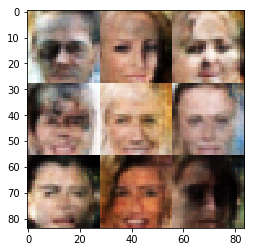

Step: 5910: Epoch 1/2... Discriminator Loss: 0.4040... Generator Loss: 1.5370
Step: 5920: Epoch 1/2... Discriminator Loss: 0.0708... Generator Loss: 4.1709
Step: 5930: Epoch 1/2... Discriminator Loss: 0.1351... Generator Loss: 2.6514
Step: 5940: Epoch 1/2... Discriminator Loss: 0.3509... Generator Loss: 1.7905
Step: 5950: Epoch 1/2... Discriminator Loss: 2.2560... Generator Loss: 0.1643
Step: 5960: Epoch 1/2... Discriminator Loss: 0.4330... Generator Loss: 1.8397
Step: 5970: Epoch 1/2... Discriminator Loss: 0.3859... Generator Loss: 1.7863
Step: 5980: Epoch 1/2... Discriminator Loss: 1.3765... Generator Loss: 0.3786
Step: 5990: Epoch 1/2... Discriminator Loss: 0.4000... Generator Loss: 2.5451
Step: 6000: Epoch 1/2... Discriminator Loss: 0.2972... Generator Loss: 1.8272


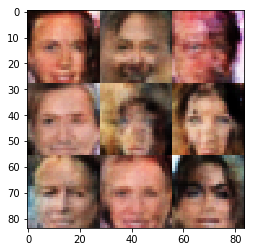

Step: 6010: Epoch 1/2... Discriminator Loss: 0.4842... Generator Loss: 1.3084
Step: 6020: Epoch 1/2... Discriminator Loss: 0.3052... Generator Loss: 1.5996
Step: 6030: Epoch 1/2... Discriminator Loss: 0.5398... Generator Loss: 1.0390
Step: 6040: Epoch 1/2... Discriminator Loss: 0.5663... Generator Loss: 1.0187
Step: 6050: Epoch 1/2... Discriminator Loss: 0.2245... Generator Loss: 4.9219
Step: 6060: Epoch 1/2... Discriminator Loss: 1.0033... Generator Loss: 0.5781
Step: 6070: Epoch 1/2... Discriminator Loss: 0.1417... Generator Loss: 2.8524
Step: 6080: Epoch 1/2... Discriminator Loss: 0.9234... Generator Loss: 0.6919
Step: 6090: Epoch 1/2... Discriminator Loss: 0.1304... Generator Loss: 2.9286
Step: 6100: Epoch 1/2... Discriminator Loss: 1.2142... Generator Loss: 0.5989


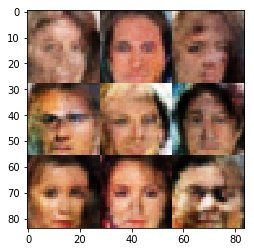

Step: 6110: Epoch 1/2... Discriminator Loss: 0.2864... Generator Loss: 1.9007
Step: 6120: Epoch 1/2... Discriminator Loss: 0.1780... Generator Loss: 2.3637
Step: 6130: Epoch 1/2... Discriminator Loss: 0.2964... Generator Loss: 1.8058
Step: 6140: Epoch 1/2... Discriminator Loss: 0.1806... Generator Loss: 2.0089
Step: 6150: Epoch 1/2... Discriminator Loss: 0.9429... Generator Loss: 0.6493
Step: 6160: Epoch 1/2... Discriminator Loss: 0.1083... Generator Loss: 3.2102
Step: 6170: Epoch 1/2... Discriminator Loss: 0.3021... Generator Loss: 1.7103
Step: 6180: Epoch 1/2... Discriminator Loss: 2.4466... Generator Loss: 4.7288
Step: 6190: Epoch 1/2... Discriminator Loss: 0.8912... Generator Loss: 0.7790
Step: 6200: Epoch 1/2... Discriminator Loss: 1.1229... Generator Loss: 0.6478


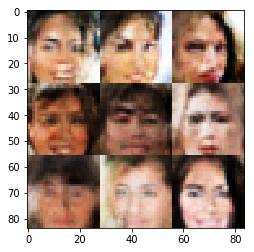

Step: 6210: Epoch 1/2... Discriminator Loss: 0.1836... Generator Loss: 3.0423
Step: 6220: Epoch 1/2... Discriminator Loss: 0.3336... Generator Loss: 1.6083
Step: 6230: Epoch 1/2... Discriminator Loss: 0.2256... Generator Loss: 2.3146
Step: 6240: Epoch 1/2... Discriminator Loss: 0.1118... Generator Loss: 3.4540
Step: 6250: Epoch 1/2... Discriminator Loss: 0.1945... Generator Loss: 2.8604
Step: 6260: Epoch 1/2... Discriminator Loss: 0.1930... Generator Loss: 2.2475
Step: 6270: Epoch 1/2... Discriminator Loss: 0.4599... Generator Loss: 1.3131
Step: 6280: Epoch 1/2... Discriminator Loss: 0.3428... Generator Loss: 1.8335
Step: 6290: Epoch 1/2... Discriminator Loss: 0.0992... Generator Loss: 2.9840
Step: 6300: Epoch 1/2... Discriminator Loss: 0.5778... Generator Loss: 1.0234


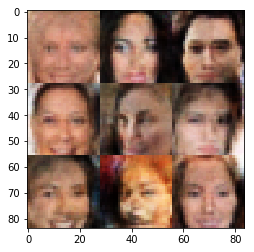

Step: 6310: Epoch 1/2... Discriminator Loss: 0.1218... Generator Loss: 2.9814
Step: 6320: Epoch 1/2... Discriminator Loss: 0.4664... Generator Loss: 1.2616
Step: 6330: Epoch 1/2... Discriminator Loss: 0.3063... Generator Loss: 1.7688
Step: 6340: Epoch 2/2... Discriminator Loss: 0.2082... Generator Loss: 2.3704
Step: 6350: Epoch 2/2... Discriminator Loss: 0.2277... Generator Loss: 2.4976
Step: 6360: Epoch 2/2... Discriminator Loss: 0.1461... Generator Loss: 4.1250
Step: 6370: Epoch 2/2... Discriminator Loss: 0.3843... Generator Loss: 1.4968
Step: 6380: Epoch 2/2... Discriminator Loss: 0.3821... Generator Loss: 4.4691
Step: 6390: Epoch 2/2... Discriminator Loss: 0.7844... Generator Loss: 2.4008
Step: 6400: Epoch 2/2... Discriminator Loss: 0.0903... Generator Loss: 3.1447


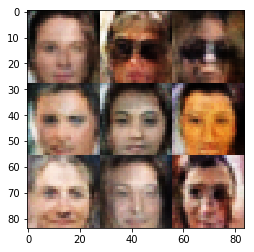

Step: 6410: Epoch 2/2... Discriminator Loss: 0.5456... Generator Loss: 1.1512
Step: 6420: Epoch 2/2... Discriminator Loss: 0.1532... Generator Loss: 2.6699
Step: 6430: Epoch 2/2... Discriminator Loss: 0.2026... Generator Loss: 2.2201
Step: 6440: Epoch 2/2... Discriminator Loss: 0.1858... Generator Loss: 2.3317
Step: 6450: Epoch 2/2... Discriminator Loss: 0.3465... Generator Loss: 1.8976
Step: 6460: Epoch 2/2... Discriminator Loss: 0.1646... Generator Loss: 2.4867
Step: 6470: Epoch 2/2... Discriminator Loss: 1.1164... Generator Loss: 0.5928
Step: 6480: Epoch 2/2... Discriminator Loss: 0.3149... Generator Loss: 1.7279
Step: 6490: Epoch 2/2... Discriminator Loss: 0.1335... Generator Loss: 2.9491
Step: 6500: Epoch 2/2... Discriminator Loss: 0.4090... Generator Loss: 1.4178


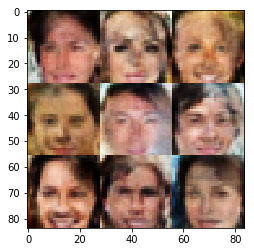

Step: 6510: Epoch 2/2... Discriminator Loss: 0.1478... Generator Loss: 2.4959
Step: 6520: Epoch 2/2... Discriminator Loss: 0.0395... Generator Loss: 5.1390
Step: 6530: Epoch 2/2... Discriminator Loss: 0.0925... Generator Loss: 3.1461
Step: 6540: Epoch 2/2... Discriminator Loss: 3.0996... Generator Loss: 0.0807
Step: 6550: Epoch 2/2... Discriminator Loss: 0.6599... Generator Loss: 1.0336
Step: 6560: Epoch 2/2... Discriminator Loss: 1.4386... Generator Loss: 0.3693
Step: 6570: Epoch 2/2... Discriminator Loss: 0.2335... Generator Loss: 2.9020
Step: 6580: Epoch 2/2... Discriminator Loss: 0.9441... Generator Loss: 0.6577
Step: 6590: Epoch 2/2... Discriminator Loss: 0.3209... Generator Loss: 3.5143
Step: 6600: Epoch 2/2... Discriminator Loss: 0.1359... Generator Loss: 3.0660


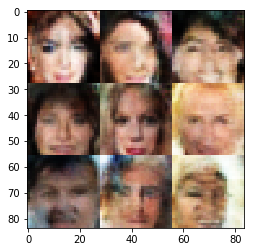

Step: 6610: Epoch 2/2... Discriminator Loss: 0.4264... Generator Loss: 1.3004
Step: 6620: Epoch 2/2... Discriminator Loss: 0.0622... Generator Loss: 4.0839
Step: 6630: Epoch 2/2... Discriminator Loss: 0.6722... Generator Loss: 0.9624
Step: 6640: Epoch 2/2... Discriminator Loss: 0.3491... Generator Loss: 1.6596
Step: 6650: Epoch 2/2... Discriminator Loss: 0.0981... Generator Loss: 3.4088
Step: 6660: Epoch 2/2... Discriminator Loss: 0.2205... Generator Loss: 2.4218
Step: 6670: Epoch 2/2... Discriminator Loss: 0.3256... Generator Loss: 1.7239
Step: 6680: Epoch 2/2... Discriminator Loss: 0.1658... Generator Loss: 3.3289
Step: 6690: Epoch 2/2... Discriminator Loss: 0.2384... Generator Loss: 2.0062
Step: 6700: Epoch 2/2... Discriminator Loss: 0.0798... Generator Loss: 3.4090


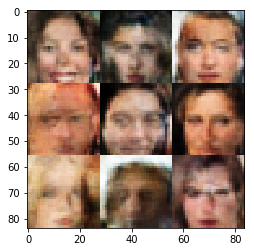

Step: 6710: Epoch 2/2... Discriminator Loss: 0.0571... Generator Loss: 4.0721
Step: 6720: Epoch 2/2... Discriminator Loss: 0.1620... Generator Loss: 2.2015
Step: 6730: Epoch 2/2... Discriminator Loss: 0.1830... Generator Loss: 2.4492
Step: 6740: Epoch 2/2... Discriminator Loss: 0.2764... Generator Loss: 1.7607
Step: 6750: Epoch 2/2... Discriminator Loss: 0.0937... Generator Loss: 4.8702
Step: 6760: Epoch 2/2... Discriminator Loss: 0.0303... Generator Loss: 5.3415
Step: 6770: Epoch 2/2... Discriminator Loss: 0.8135... Generator Loss: 0.9571
Step: 6780: Epoch 2/2... Discriminator Loss: 1.5003... Generator Loss: 0.3909
Step: 6790: Epoch 2/2... Discriminator Loss: 0.6648... Generator Loss: 0.9775
Step: 6800: Epoch 2/2... Discriminator Loss: 0.3020... Generator Loss: 2.0155


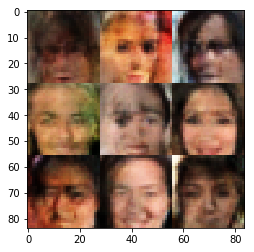

Step: 6810: Epoch 2/2... Discriminator Loss: 2.6507... Generator Loss: 0.2210
Step: 6820: Epoch 2/2... Discriminator Loss: 1.3930... Generator Loss: 0.4310
Step: 6830: Epoch 2/2... Discriminator Loss: 0.1281... Generator Loss: 2.5557
Step: 6840: Epoch 2/2... Discriminator Loss: 0.7926... Generator Loss: 0.7556
Step: 6850: Epoch 2/2... Discriminator Loss: 0.1659... Generator Loss: 2.6576
Step: 6860: Epoch 2/2... Discriminator Loss: 0.2749... Generator Loss: 1.9994
Step: 6870: Epoch 2/2... Discriminator Loss: 0.3685... Generator Loss: 1.4595
Step: 6880: Epoch 2/2... Discriminator Loss: 1.2000... Generator Loss: 0.4920
Step: 6890: Epoch 2/2... Discriminator Loss: 0.1173... Generator Loss: 3.0925
Step: 6900: Epoch 2/2... Discriminator Loss: 0.1414... Generator Loss: 2.7046


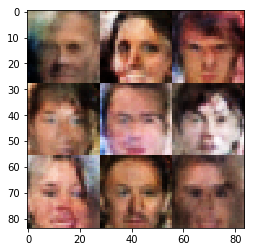

Step: 6910: Epoch 2/2... Discriminator Loss: 0.2935... Generator Loss: 2.8073
Step: 6920: Epoch 2/2... Discriminator Loss: 1.8145... Generator Loss: 2.5841
Step: 6930: Epoch 2/2... Discriminator Loss: 0.6560... Generator Loss: 2.2585
Step: 6940: Epoch 2/2... Discriminator Loss: 0.4174... Generator Loss: 2.0766
Step: 6950: Epoch 2/2... Discriminator Loss: 1.3848... Generator Loss: 0.4419
Step: 6960: Epoch 2/2... Discriminator Loss: 0.5471... Generator Loss: 1.2897
Step: 6970: Epoch 2/2... Discriminator Loss: 0.2948... Generator Loss: 4.8508
Step: 6980: Epoch 2/2... Discriminator Loss: 2.2317... Generator Loss: 0.1961
Step: 6990: Epoch 2/2... Discriminator Loss: 0.5674... Generator Loss: 3.2535
Step: 7000: Epoch 2/2... Discriminator Loss: 0.1244... Generator Loss: 3.1576


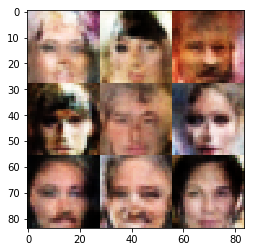

Step: 7010: Epoch 2/2... Discriminator Loss: 1.5398... Generator Loss: 0.3825
Step: 7020: Epoch 2/2... Discriminator Loss: 0.1855... Generator Loss: 3.7853
Step: 7030: Epoch 2/2... Discriminator Loss: 0.2351... Generator Loss: 2.4925
Step: 7040: Epoch 2/2... Discriminator Loss: 0.4995... Generator Loss: 1.3320
Step: 7050: Epoch 2/2... Discriminator Loss: 0.2159... Generator Loss: 2.1137
Step: 7060: Epoch 2/2... Discriminator Loss: 0.6870... Generator Loss: 0.8535
Step: 7070: Epoch 2/2... Discriminator Loss: 0.3247... Generator Loss: 1.7911
Step: 7080: Epoch 2/2... Discriminator Loss: 0.6616... Generator Loss: 0.9135
Step: 7090: Epoch 2/2... Discriminator Loss: 1.5612... Generator Loss: 0.3377
Step: 7100: Epoch 2/2... Discriminator Loss: 0.1619... Generator Loss: 2.8516


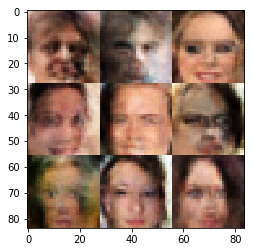

Step: 7110: Epoch 2/2... Discriminator Loss: 0.6201... Generator Loss: 0.9670
Step: 7120: Epoch 2/2... Discriminator Loss: 0.3110... Generator Loss: 1.8121
Step: 7130: Epoch 2/2... Discriminator Loss: 0.2060... Generator Loss: 2.3343
Step: 7140: Epoch 2/2... Discriminator Loss: 1.3470... Generator Loss: 0.3835
Step: 7150: Epoch 2/2... Discriminator Loss: 0.6020... Generator Loss: 1.3613
Step: 7160: Epoch 2/2... Discriminator Loss: 0.3994... Generator Loss: 1.6089
Step: 7170: Epoch 2/2... Discriminator Loss: 0.2978... Generator Loss: 3.0999
Step: 7180: Epoch 2/2... Discriminator Loss: 0.2762... Generator Loss: 1.7777
Step: 7190: Epoch 2/2... Discriminator Loss: 0.4306... Generator Loss: 3.8171
Step: 7200: Epoch 2/2... Discriminator Loss: 0.1042... Generator Loss: 3.3597


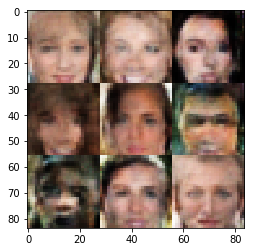

Step: 7210: Epoch 2/2... Discriminator Loss: 0.8730... Generator Loss: 0.6760
Step: 7220: Epoch 2/2... Discriminator Loss: 0.0870... Generator Loss: 4.2241
Step: 7230: Epoch 2/2... Discriminator Loss: 0.1811... Generator Loss: 2.2587
Step: 7240: Epoch 2/2... Discriminator Loss: 0.3006... Generator Loss: 1.6932
Step: 7250: Epoch 2/2... Discriminator Loss: 0.2012... Generator Loss: 2.6794
Step: 7260: Epoch 2/2... Discriminator Loss: 2.2074... Generator Loss: 0.1832
Step: 7270: Epoch 2/2... Discriminator Loss: 0.3501... Generator Loss: 1.8287
Step: 7280: Epoch 2/2... Discriminator Loss: 0.4036... Generator Loss: 1.5952
Step: 7290: Epoch 2/2... Discriminator Loss: 0.1552... Generator Loss: 2.3619
Step: 7300: Epoch 2/2... Discriminator Loss: 1.0001... Generator Loss: 0.6144


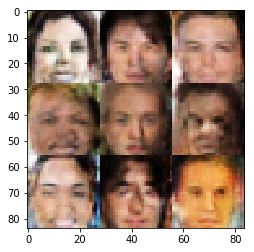

Step: 7310: Epoch 2/2... Discriminator Loss: 0.1435... Generator Loss: 2.6485
Step: 7320: Epoch 2/2... Discriminator Loss: 0.1107... Generator Loss: 3.0005
Step: 7330: Epoch 2/2... Discriminator Loss: 0.1457... Generator Loss: 3.0348
Step: 7340: Epoch 2/2... Discriminator Loss: 0.1834... Generator Loss: 2.2374
Step: 7350: Epoch 2/2... Discriminator Loss: 0.0875... Generator Loss: 3.6184
Step: 7360: Epoch 2/2... Discriminator Loss: 0.3119... Generator Loss: 1.7025
Step: 7370: Epoch 2/2... Discriminator Loss: 0.2768... Generator Loss: 1.8303
Step: 7380: Epoch 2/2... Discriminator Loss: 0.0945... Generator Loss: 4.5497
Step: 7390: Epoch 2/2... Discriminator Loss: 0.3688... Generator Loss: 1.6786
Step: 7400: Epoch 2/2... Discriminator Loss: 0.1203... Generator Loss: 2.8141


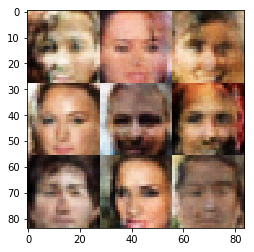

Step: 7410: Epoch 2/2... Discriminator Loss: 0.2246... Generator Loss: 1.9373
Step: 7420: Epoch 2/2... Discriminator Loss: 0.4240... Generator Loss: 1.4735
Step: 7430: Epoch 2/2... Discriminator Loss: 0.0541... Generator Loss: 4.3391
Step: 7440: Epoch 2/2... Discriminator Loss: 0.7920... Generator Loss: 2.9448
Step: 7450: Epoch 2/2... Discriminator Loss: 0.5081... Generator Loss: 3.0569
Step: 7460: Epoch 2/2... Discriminator Loss: 0.3909... Generator Loss: 3.3894
Step: 7470: Epoch 2/2... Discriminator Loss: 0.2279... Generator Loss: 2.1076
Step: 7480: Epoch 2/2... Discriminator Loss: 1.0011... Generator Loss: 0.7180
Step: 7490: Epoch 2/2... Discriminator Loss: 0.7452... Generator Loss: 0.9053
Step: 7500: Epoch 2/2... Discriminator Loss: 0.1105... Generator Loss: 2.9389


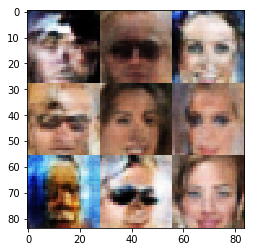

Step: 7510: Epoch 2/2... Discriminator Loss: 3.6996... Generator Loss: 0.0382
Step: 7520: Epoch 2/2... Discriminator Loss: 0.7027... Generator Loss: 1.1880
Step: 7530: Epoch 2/2... Discriminator Loss: 0.3871... Generator Loss: 1.7662
Step: 7540: Epoch 2/2... Discriminator Loss: 1.1512... Generator Loss: 4.0256
Step: 7550: Epoch 2/2... Discriminator Loss: 1.0200... Generator Loss: 0.6829
Step: 7560: Epoch 2/2... Discriminator Loss: 0.4481... Generator Loss: 1.2913
Step: 7570: Epoch 2/2... Discriminator Loss: 3.0858... Generator Loss: 0.0763
Step: 7580: Epoch 2/2... Discriminator Loss: 0.5068... Generator Loss: 1.3796
Step: 7590: Epoch 2/2... Discriminator Loss: 0.8930... Generator Loss: 3.3797
Step: 7600: Epoch 2/2... Discriminator Loss: 0.5588... Generator Loss: 1.1641


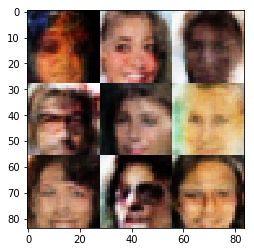

Step: 7610: Epoch 2/2... Discriminator Loss: 0.1305... Generator Loss: 3.3322
Step: 7620: Epoch 2/2... Discriminator Loss: 0.3059... Generator Loss: 1.7515
Step: 7630: Epoch 2/2... Discriminator Loss: 0.7036... Generator Loss: 0.9326
Step: 7640: Epoch 2/2... Discriminator Loss: 0.3709... Generator Loss: 1.4674
Step: 7650: Epoch 2/2... Discriminator Loss: 0.2092... Generator Loss: 2.1721
Step: 7660: Epoch 2/2... Discriminator Loss: 0.4058... Generator Loss: 1.4513
Step: 7670: Epoch 2/2... Discriminator Loss: 0.1855... Generator Loss: 2.6080
Step: 7680: Epoch 2/2... Discriminator Loss: 0.2088... Generator Loss: 2.3012
Step: 7690: Epoch 2/2... Discriminator Loss: 0.2093... Generator Loss: 2.2469
Step: 7700: Epoch 2/2... Discriminator Loss: 0.1348... Generator Loss: 3.0541


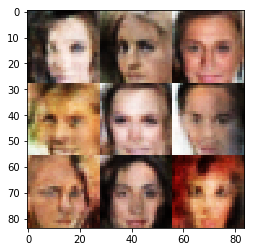

Step: 7710: Epoch 2/2... Discriminator Loss: 0.4057... Generator Loss: 1.3975
Step: 7720: Epoch 2/2... Discriminator Loss: 0.2532... Generator Loss: 2.1527
Step: 7730: Epoch 2/2... Discriminator Loss: 0.0805... Generator Loss: 3.1828
Step: 7740: Epoch 2/2... Discriminator Loss: 0.9262... Generator Loss: 0.6300
Step: 7750: Epoch 2/2... Discriminator Loss: 0.6070... Generator Loss: 1.0936
Step: 7760: Epoch 2/2... Discriminator Loss: 0.7229... Generator Loss: 1.0032
Step: 7770: Epoch 2/2... Discriminator Loss: 2.8805... Generator Loss: 0.2059
Step: 7780: Epoch 2/2... Discriminator Loss: 0.8241... Generator Loss: 0.8303
Step: 7790: Epoch 2/2... Discriminator Loss: 0.3906... Generator Loss: 1.5271
Step: 7800: Epoch 2/2... Discriminator Loss: 0.3422... Generator Loss: 1.7773


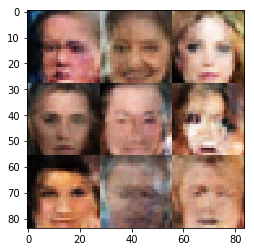

Step: 7810: Epoch 2/2... Discriminator Loss: 0.2569... Generator Loss: 1.9284
Step: 7820: Epoch 2/2... Discriminator Loss: 0.2216... Generator Loss: 2.7743
Step: 7830: Epoch 2/2... Discriminator Loss: 0.2108... Generator Loss: 2.1822
Step: 7840: Epoch 2/2... Discriminator Loss: 0.0960... Generator Loss: 3.1120
Step: 7850: Epoch 2/2... Discriminator Loss: 1.3187... Generator Loss: 0.4544
Step: 7860: Epoch 2/2... Discriminator Loss: 0.1520... Generator Loss: 2.3264
Step: 7870: Epoch 2/2... Discriminator Loss: 0.2978... Generator Loss: 1.7648
Step: 7880: Epoch 2/2... Discriminator Loss: 0.3254... Generator Loss: 1.6094
Step: 7890: Epoch 2/2... Discriminator Loss: 0.7135... Generator Loss: 1.0031
Step: 7900: Epoch 2/2... Discriminator Loss: 0.5820... Generator Loss: 1.0526


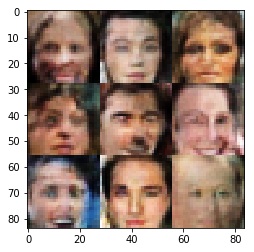

Step: 7910: Epoch 2/2... Discriminator Loss: 0.3951... Generator Loss: 1.4487
Step: 7920: Epoch 2/2... Discriminator Loss: 0.1203... Generator Loss: 5.3401
Step: 7930: Epoch 2/2... Discriminator Loss: 2.1315... Generator Loss: 6.7863
Step: 7940: Epoch 2/2... Discriminator Loss: 0.6967... Generator Loss: 1.0012
Step: 7950: Epoch 2/2... Discriminator Loss: 0.5061... Generator Loss: 3.0261
Step: 7960: Epoch 2/2... Discriminator Loss: 0.3910... Generator Loss: 1.4609
Step: 7970: Epoch 2/2... Discriminator Loss: 0.1936... Generator Loss: 2.4282
Step: 7980: Epoch 2/2... Discriminator Loss: 1.8913... Generator Loss: 0.2836
Step: 7990: Epoch 2/2... Discriminator Loss: 0.4455... Generator Loss: 1.4208
Step: 8000: Epoch 2/2... Discriminator Loss: 0.2422... Generator Loss: 3.1851


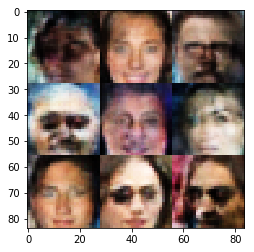

Step: 8010: Epoch 2/2... Discriminator Loss: 0.3829... Generator Loss: 3.9444
Step: 8020: Epoch 2/2... Discriminator Loss: 0.8918... Generator Loss: 0.7594
Step: 8030: Epoch 2/2... Discriminator Loss: 0.2905... Generator Loss: 1.8081
Step: 8040: Epoch 2/2... Discriminator Loss: 0.5208... Generator Loss: 1.1527
Step: 8050: Epoch 2/2... Discriminator Loss: 0.7519... Generator Loss: 0.8520
Step: 8060: Epoch 2/2... Discriminator Loss: 0.3022... Generator Loss: 1.7404
Step: 8070: Epoch 2/2... Discriminator Loss: 0.3459... Generator Loss: 1.8241
Step: 8080: Epoch 2/2... Discriminator Loss: 0.5391... Generator Loss: 1.1420
Step: 8090: Epoch 2/2... Discriminator Loss: 0.3721... Generator Loss: 4.1088
Step: 8100: Epoch 2/2... Discriminator Loss: 0.7066... Generator Loss: 0.9560


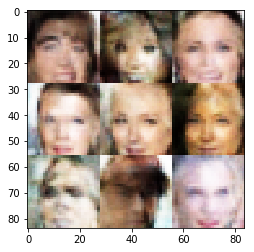

Step: 8110: Epoch 2/2... Discriminator Loss: 0.6742... Generator Loss: 0.9257
Step: 8120: Epoch 2/2... Discriminator Loss: 1.0124... Generator Loss: 0.6733
Step: 8130: Epoch 2/2... Discriminator Loss: 0.1972... Generator Loss: 2.4286
Step: 8140: Epoch 2/2... Discriminator Loss: 0.1456... Generator Loss: 2.7159
Step: 8150: Epoch 2/2... Discriminator Loss: 0.1244... Generator Loss: 2.5419
Step: 8160: Epoch 2/2... Discriminator Loss: 0.2423... Generator Loss: 1.9736
Step: 8170: Epoch 2/2... Discriminator Loss: 0.2709... Generator Loss: 1.8442
Step: 8180: Epoch 2/2... Discriminator Loss: 0.7510... Generator Loss: 0.8599
Step: 8190: Epoch 2/2... Discriminator Loss: 1.9985... Generator Loss: 5.2555
Step: 8200: Epoch 2/2... Discriminator Loss: 0.0725... Generator Loss: 3.9777


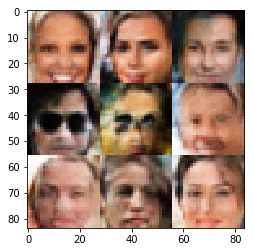

Step: 8210: Epoch 2/2... Discriminator Loss: 0.1328... Generator Loss: 3.2428
Step: 8220: Epoch 2/2... Discriminator Loss: 0.3392... Generator Loss: 1.5463
Step: 8230: Epoch 2/2... Discriminator Loss: 0.1863... Generator Loss: 2.3290
Step: 8240: Epoch 2/2... Discriminator Loss: 1.0859... Generator Loss: 0.6703
Step: 8250: Epoch 2/2... Discriminator Loss: 0.2593... Generator Loss: 2.0606
Step: 8260: Epoch 2/2... Discriminator Loss: 0.2322... Generator Loss: 2.0675
Step: 8270: Epoch 2/2... Discriminator Loss: 0.0946... Generator Loss: 3.0612
Step: 8280: Epoch 2/2... Discriminator Loss: 0.3166... Generator Loss: 3.5080
Step: 8290: Epoch 2/2... Discriminator Loss: 0.3018... Generator Loss: 2.8411
Step: 8300: Epoch 2/2... Discriminator Loss: 0.0483... Generator Loss: 4.1746


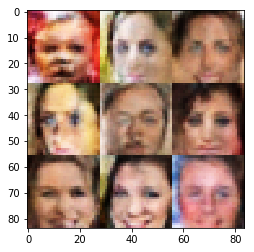

Step: 8310: Epoch 2/2... Discriminator Loss: 0.3588... Generator Loss: 3.5037
Step: 8320: Epoch 2/2... Discriminator Loss: 0.3524... Generator Loss: 1.5561
Step: 8330: Epoch 2/2... Discriminator Loss: 0.3908... Generator Loss: 1.4345
Step: 8340: Epoch 2/2... Discriminator Loss: 0.3228... Generator Loss: 1.6433
Step: 8350: Epoch 2/2... Discriminator Loss: 0.2473... Generator Loss: 2.1557
Step: 8360: Epoch 2/2... Discriminator Loss: 0.1785... Generator Loss: 3.7905
Step: 8370: Epoch 2/2... Discriminator Loss: 0.8248... Generator Loss: 1.3738
Step: 8380: Epoch 2/2... Discriminator Loss: 0.4922... Generator Loss: 1.5564
Step: 8390: Epoch 2/2... Discriminator Loss: 0.3784... Generator Loss: 3.3107
Step: 8400: Epoch 2/2... Discriminator Loss: 0.1353... Generator Loss: 3.1726


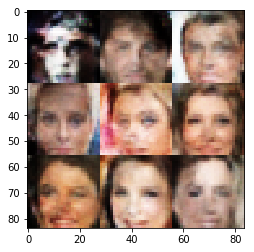

Step: 8410: Epoch 2/2... Discriminator Loss: 3.8699... Generator Loss: 0.1055
Step: 8420: Epoch 2/2... Discriminator Loss: 0.2299... Generator Loss: 2.6584
Step: 8430: Epoch 2/2... Discriminator Loss: 0.2084... Generator Loss: 2.5243
Step: 8440: Epoch 2/2... Discriminator Loss: 0.2605... Generator Loss: 1.8110
Step: 8450: Epoch 2/2... Discriminator Loss: 0.1337... Generator Loss: 2.7754
Step: 8460: Epoch 2/2... Discriminator Loss: 1.4231... Generator Loss: 0.4089
Step: 8470: Epoch 2/2... Discriminator Loss: 0.7020... Generator Loss: 1.0442
Step: 8480: Epoch 2/2... Discriminator Loss: 0.6926... Generator Loss: 0.9189
Step: 8490: Epoch 2/2... Discriminator Loss: 0.5978... Generator Loss: 1.1759
Step: 8500: Epoch 2/2... Discriminator Loss: 0.3114... Generator Loss: 1.8036


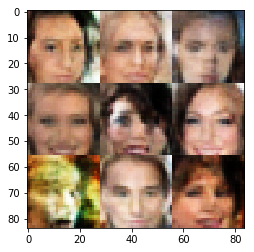

Step: 8510: Epoch 2/2... Discriminator Loss: 0.3347... Generator Loss: 1.5264
Step: 8520: Epoch 2/2... Discriminator Loss: 0.5139... Generator Loss: 1.1475
Step: 8530: Epoch 2/2... Discriminator Loss: 0.2256... Generator Loss: 2.1722
Step: 8540: Epoch 2/2... Discriminator Loss: 0.3333... Generator Loss: 1.6815
Step: 8550: Epoch 2/2... Discriminator Loss: 0.1191... Generator Loss: 3.7311
Step: 8560: Epoch 2/2... Discriminator Loss: 7.5130... Generator Loss: 11.5883
Step: 8570: Epoch 2/2... Discriminator Loss: 0.7370... Generator Loss: 0.8878
Step: 8580: Epoch 2/2... Discriminator Loss: 1.9842... Generator Loss: 0.2526
Step: 8590: Epoch 2/2... Discriminator Loss: 0.5332... Generator Loss: 1.1906
Step: 8600: Epoch 2/2... Discriminator Loss: 0.2176... Generator Loss: 2.2772


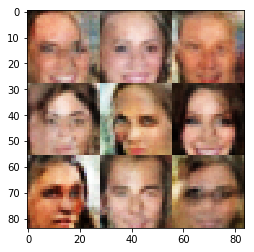

Step: 8610: Epoch 2/2... Discriminator Loss: 0.5583... Generator Loss: 1.1565
Step: 8620: Epoch 2/2... Discriminator Loss: 0.1230... Generator Loss: 2.9040
Step: 8630: Epoch 2/2... Discriminator Loss: 0.2331... Generator Loss: 2.0303
Step: 8640: Epoch 2/2... Discriminator Loss: 0.1034... Generator Loss: 2.7765
Step: 8650: Epoch 2/2... Discriminator Loss: 3.0475... Generator Loss: 6.2460
Step: 8660: Epoch 2/2... Discriminator Loss: 0.2740... Generator Loss: 2.0434
Step: 8670: Epoch 2/2... Discriminator Loss: 0.2909... Generator Loss: 2.2052
Step: 8680: Epoch 2/2... Discriminator Loss: 0.8320... Generator Loss: 4.9939
Step: 8690: Epoch 2/2... Discriminator Loss: 0.3468... Generator Loss: 1.6580
Step: 8700: Epoch 2/2... Discriminator Loss: 0.2167... Generator Loss: 2.1931


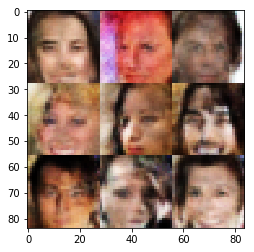

Step: 8710: Epoch 2/2... Discriminator Loss: 0.3531... Generator Loss: 1.4862
Step: 8720: Epoch 2/2... Discriminator Loss: 3.7299... Generator Loss: 0.0659
Step: 8730: Epoch 2/2... Discriminator Loss: 0.6124... Generator Loss: 1.1320
Step: 8740: Epoch 2/2... Discriminator Loss: 0.3747... Generator Loss: 3.0131
Step: 8750: Epoch 2/2... Discriminator Loss: 0.2268... Generator Loss: 2.1718
Step: 8760: Epoch 2/2... Discriminator Loss: 0.1857... Generator Loss: 2.3364
Step: 8770: Epoch 2/2... Discriminator Loss: 0.2256... Generator Loss: 1.9088
Step: 8780: Epoch 2/2... Discriminator Loss: 0.1471... Generator Loss: 2.3460
Step: 8790: Epoch 2/2... Discriminator Loss: 2.4572... Generator Loss: 0.1317
Step: 8800: Epoch 2/2... Discriminator Loss: 0.4401... Generator Loss: 1.4545


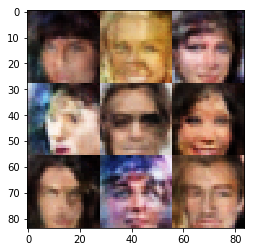

Step: 8810: Epoch 2/2... Discriminator Loss: 0.8323... Generator Loss: 0.8070
Step: 8820: Epoch 2/2... Discriminator Loss: 1.2083... Generator Loss: 4.1829
Step: 8830: Epoch 2/2... Discriminator Loss: 0.2332... Generator Loss: 2.1593
Step: 8840: Epoch 2/2... Discriminator Loss: 0.5463... Generator Loss: 1.0965
Step: 8850: Epoch 2/2... Discriminator Loss: 1.0375... Generator Loss: 0.7046
Step: 8860: Epoch 2/2... Discriminator Loss: 0.1062... Generator Loss: 3.3694
Step: 8870: Epoch 2/2... Discriminator Loss: 0.2676... Generator Loss: 1.8267
Step: 8880: Epoch 2/2... Discriminator Loss: 0.3194... Generator Loss: 1.5255
Step: 8890: Epoch 2/2... Discriminator Loss: 0.5008... Generator Loss: 1.1522
Step: 8900: Epoch 2/2... Discriminator Loss: 0.0906... Generator Loss: 3.4717


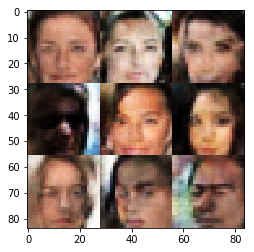

Step: 8910: Epoch 2/2... Discriminator Loss: 0.8378... Generator Loss: 0.7714
Step: 8920: Epoch 2/2... Discriminator Loss: 0.0732... Generator Loss: 3.3908
Step: 8930: Epoch 2/2... Discriminator Loss: 2.4819... Generator Loss: 0.1423
Step: 8940: Epoch 2/2... Discriminator Loss: 0.3077... Generator Loss: 1.8642
Step: 8950: Epoch 2/2... Discriminator Loss: 0.1250... Generator Loss: 3.1317
Step: 8960: Epoch 2/2... Discriminator Loss: 0.1152... Generator Loss: 3.1011
Step: 8970: Epoch 2/2... Discriminator Loss: 0.5709... Generator Loss: 1.0798
Step: 8980: Epoch 2/2... Discriminator Loss: 0.0333... Generator Loss: 4.6717
Step: 8990: Epoch 2/2... Discriminator Loss: 0.1478... Generator Loss: 2.5361
Step: 9000: Epoch 2/2... Discriminator Loss: 0.1027... Generator Loss: 3.2328


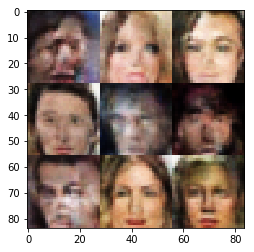

Step: 9010: Epoch 2/2... Discriminator Loss: 0.5398... Generator Loss: 1.0667
Step: 9020: Epoch 2/2... Discriminator Loss: 0.2432... Generator Loss: 2.3429
Step: 9030: Epoch 2/2... Discriminator Loss: 0.1216... Generator Loss: 2.9863
Step: 9040: Epoch 2/2... Discriminator Loss: 0.1273... Generator Loss: 2.8819
Step: 9050: Epoch 2/2... Discriminator Loss: 0.1481... Generator Loss: 2.7357
Step: 9060: Epoch 2/2... Discriminator Loss: 0.0591... Generator Loss: 3.7516
Step: 9070: Epoch 2/2... Discriminator Loss: 1.0509... Generator Loss: 0.6874
Step: 9080: Epoch 2/2... Discriminator Loss: 2.1470... Generator Loss: 6.2069
Step: 9090: Epoch 2/2... Discriminator Loss: 0.7932... Generator Loss: 0.7888
Step: 9100: Epoch 2/2... Discriminator Loss: 0.1061... Generator Loss: 3.3802


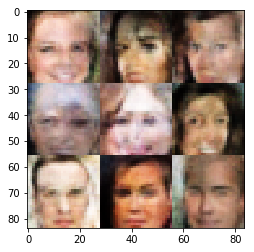

Step: 9110: Epoch 2/2... Discriminator Loss: 2.9147... Generator Loss: 0.1171
Step: 9120: Epoch 2/2... Discriminator Loss: 0.2434... Generator Loss: 2.6061
Step: 9130: Epoch 2/2... Discriminator Loss: 0.8831... Generator Loss: 0.7843
Step: 9140: Epoch 2/2... Discriminator Loss: 1.5747... Generator Loss: 0.3012
Step: 9150: Epoch 2/2... Discriminator Loss: 0.6531... Generator Loss: 0.8784
Step: 9160: Epoch 2/2... Discriminator Loss: 0.0948... Generator Loss: 3.7500
Step: 9170: Epoch 2/2... Discriminator Loss: 2.4582... Generator Loss: 0.1481
Step: 9180: Epoch 2/2... Discriminator Loss: 0.6345... Generator Loss: 1.0849
Step: 9190: Epoch 2/2... Discriminator Loss: 0.8444... Generator Loss: 0.7791
Step: 9200: Epoch 2/2... Discriminator Loss: 0.2754... Generator Loss: 6.7709


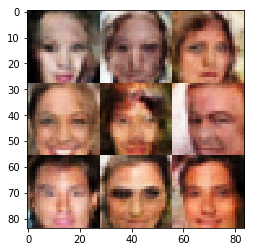

Step: 9210: Epoch 2/2... Discriminator Loss: 0.5090... Generator Loss: 1.2706
Step: 9220: Epoch 2/2... Discriminator Loss: 0.9504... Generator Loss: 0.6370
Step: 9230: Epoch 2/2... Discriminator Loss: 0.3153... Generator Loss: 2.3239
Step: 9240: Epoch 2/2... Discriminator Loss: 0.2248... Generator Loss: 2.5912
Step: 9250: Epoch 2/2... Discriminator Loss: 0.0860... Generator Loss: 3.3232
Step: 9260: Epoch 2/2... Discriminator Loss: 0.4731... Generator Loss: 3.7920
Step: 9270: Epoch 2/2... Discriminator Loss: 0.3416... Generator Loss: 1.6213
Step: 9280: Epoch 2/2... Discriminator Loss: 0.6904... Generator Loss: 0.9225
Step: 9290: Epoch 2/2... Discriminator Loss: 0.1118... Generator Loss: 3.5920
Step: 9300: Epoch 2/2... Discriminator Loss: 0.2549... Generator Loss: 1.9686


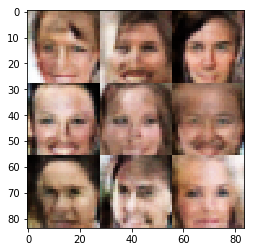

Step: 9310: Epoch 2/2... Discriminator Loss: 0.2246... Generator Loss: 2.0591
Step: 9320: Epoch 2/2... Discriminator Loss: 0.1530... Generator Loss: 2.6863
Step: 9330: Epoch 2/2... Discriminator Loss: 0.0327... Generator Loss: 5.0656
Step: 9340: Epoch 2/2... Discriminator Loss: 0.0989... Generator Loss: 3.3210
Step: 9350: Epoch 2/2... Discriminator Loss: 0.2952... Generator Loss: 2.3999
Step: 9360: Epoch 2/2... Discriminator Loss: 0.1192... Generator Loss: 2.9469
Step: 9370: Epoch 2/2... Discriminator Loss: 0.0975... Generator Loss: 3.0468
Step: 9380: Epoch 2/2... Discriminator Loss: 0.1731... Generator Loss: 2.3807
Step: 9390: Epoch 2/2... Discriminator Loss: 0.1671... Generator Loss: 2.5642
Step: 9400: Epoch 2/2... Discriminator Loss: 0.3220... Generator Loss: 1.4965


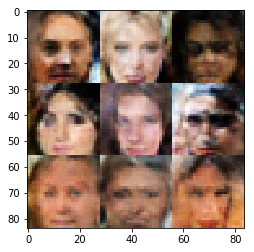

Step: 9410: Epoch 2/2... Discriminator Loss: 0.0866... Generator Loss: 3.2448
Step: 9420: Epoch 2/2... Discriminator Loss: 0.0427... Generator Loss: 3.8528
Step: 9430: Epoch 2/2... Discriminator Loss: 2.4813... Generator Loss: 0.1257
Step: 9440: Epoch 2/2... Discriminator Loss: 0.1641... Generator Loss: 2.5302
Step: 9450: Epoch 2/2... Discriminator Loss: 0.0760... Generator Loss: 3.7419
Step: 9460: Epoch 2/2... Discriminator Loss: 0.3129... Generator Loss: 1.6596
Step: 9470: Epoch 2/2... Discriminator Loss: 0.1199... Generator Loss: 2.8483
Step: 9480: Epoch 2/2... Discriminator Loss: 0.1649... Generator Loss: 2.8333
Step: 9490: Epoch 2/2... Discriminator Loss: 0.2985... Generator Loss: 1.7349
Step: 9500: Epoch 2/2... Discriminator Loss: 0.0738... Generator Loss: 3.5401


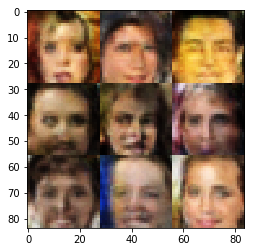

Step: 9510: Epoch 2/2... Discriminator Loss: 0.3216... Generator Loss: 1.6445
Step: 9520: Epoch 2/2... Discriminator Loss: 0.3284... Generator Loss: 1.6673
Step: 9530: Epoch 2/2... Discriminator Loss: 1.9666... Generator Loss: 0.2369
Step: 9540: Epoch 2/2... Discriminator Loss: 0.8486... Generator Loss: 0.8459
Step: 9550: Epoch 2/2... Discriminator Loss: 0.1578... Generator Loss: 2.3233
Step: 9560: Epoch 2/2... Discriminator Loss: 0.1559... Generator Loss: 2.5992
Step: 9570: Epoch 2/2... Discriminator Loss: 0.1118... Generator Loss: 3.0457
Step: 9580: Epoch 2/2... Discriminator Loss: 0.0611... Generator Loss: 4.0866
Step: 9590: Epoch 2/2... Discriminator Loss: 0.1250... Generator Loss: 3.1834
Step: 9600: Epoch 2/2... Discriminator Loss: 2.3347... Generator Loss: 0.1530


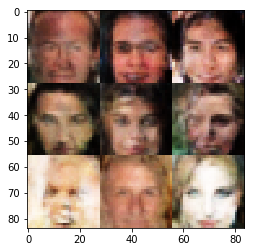

Step: 9610: Epoch 2/2... Discriminator Loss: 0.4645... Generator Loss: 2.0991
Step: 9620: Epoch 2/2... Discriminator Loss: 0.2559... Generator Loss: 2.7368
Step: 9630: Epoch 2/2... Discriminator Loss: 0.2830... Generator Loss: 1.9798
Step: 9640: Epoch 2/2... Discriminator Loss: 0.6498... Generator Loss: 4.0647
Step: 9650: Epoch 2/2... Discriminator Loss: 0.1366... Generator Loss: 5.8278
Step: 9660: Epoch 2/2... Discriminator Loss: 0.3802... Generator Loss: 4.8013
Step: 9670: Epoch 2/2... Discriminator Loss: 0.4290... Generator Loss: 1.5256
Step: 9680: Epoch 2/2... Discriminator Loss: 0.4421... Generator Loss: 1.4502
Step: 9690: Epoch 2/2... Discriminator Loss: 0.1835... Generator Loss: 2.2508
Step: 9700: Epoch 2/2... Discriminator Loss: 0.0978... Generator Loss: 3.0861


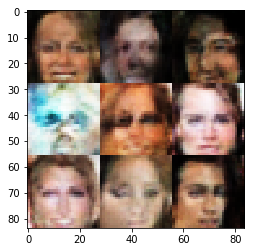

Step: 9710: Epoch 2/2... Discriminator Loss: 1.7546... Generator Loss: 0.3006
Step: 9720: Epoch 2/2... Discriminator Loss: 0.6728... Generator Loss: 1.0978
Step: 9730: Epoch 2/2... Discriminator Loss: 0.0407... Generator Loss: 4.5750
Step: 9740: Epoch 2/2... Discriminator Loss: 0.1920... Generator Loss: 2.1970
Step: 9750: Epoch 2/2... Discriminator Loss: 0.1398... Generator Loss: 2.6292
Step: 9760: Epoch 2/2... Discriminator Loss: 0.1606... Generator Loss: 2.4034
Step: 9770: Epoch 2/2... Discriminator Loss: 0.1615... Generator Loss: 2.4541
Step: 9780: Epoch 2/2... Discriminator Loss: 0.3284... Generator Loss: 1.9079
Step: 9790: Epoch 2/2... Discriminator Loss: 0.2088... Generator Loss: 2.2152
Step: 9800: Epoch 2/2... Discriminator Loss: 0.5394... Generator Loss: 1.3212


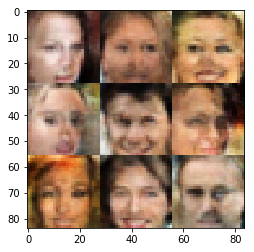

Step: 9810: Epoch 2/2... Discriminator Loss: 0.6177... Generator Loss: 1.1774
Step: 9820: Epoch 2/2... Discriminator Loss: 1.0353... Generator Loss: 0.5772
Step: 9830: Epoch 2/2... Discriminator Loss: 2.1898... Generator Loss: 0.2299
Step: 9840: Epoch 2/2... Discriminator Loss: 0.2503... Generator Loss: 2.2439
Step: 9850: Epoch 2/2... Discriminator Loss: 0.2959... Generator Loss: 4.5781
Step: 9860: Epoch 2/2... Discriminator Loss: 0.1524... Generator Loss: 2.5814
Step: 9870: Epoch 2/2... Discriminator Loss: 0.2519... Generator Loss: 1.9159
Step: 9880: Epoch 2/2... Discriminator Loss: 0.2757... Generator Loss: 1.9268
Step: 9890: Epoch 2/2... Discriminator Loss: 0.3641... Generator Loss: 1.6515
Step: 9900: Epoch 2/2... Discriminator Loss: 1.2006... Generator Loss: 0.5025


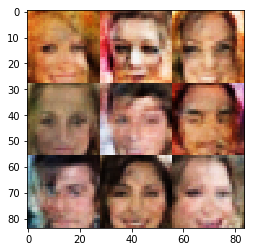

Step: 9910: Epoch 2/2... Discriminator Loss: 0.1106... Generator Loss: 2.9954
Step: 9920: Epoch 2/2... Discriminator Loss: 0.2434... Generator Loss: 1.8664
Step: 9930: Epoch 2/2... Discriminator Loss: 0.7757... Generator Loss: 0.8304
Step: 9940: Epoch 2/2... Discriminator Loss: 0.0394... Generator Loss: 4.7647
Step: 9950: Epoch 2/2... Discriminator Loss: 0.9587... Generator Loss: 0.7827
Step: 9960: Epoch 2/2... Discriminator Loss: 0.3201... Generator Loss: 1.8860
Step: 9970: Epoch 2/2... Discriminator Loss: 0.9577... Generator Loss: 5.8353
Step: 9980: Epoch 2/2... Discriminator Loss: 0.2203... Generator Loss: 3.3966
Step: 9990: Epoch 2/2... Discriminator Loss: 1.4481... Generator Loss: 6.7578
Step: 10000: Epoch 2/2... Discriminator Loss: 0.5305... Generator Loss: 1.1851


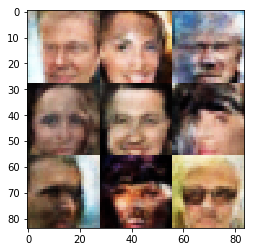

Step: 10010: Epoch 2/2... Discriminator Loss: 2.3547... Generator Loss: 0.2206
Step: 10020: Epoch 2/2... Discriminator Loss: 0.0423... Generator Loss: 4.2973
Step: 10030: Epoch 2/2... Discriminator Loss: 0.4400... Generator Loss: 1.2212
Step: 10040: Epoch 2/2... Discriminator Loss: 0.2514... Generator Loss: 1.9171
Step: 10050: Epoch 2/2... Discriminator Loss: 0.0810... Generator Loss: 3.1304
Step: 10060: Epoch 2/2... Discriminator Loss: 0.0749... Generator Loss: 3.8638
Step: 10070: Epoch 2/2... Discriminator Loss: 0.2439... Generator Loss: 1.8989
Step: 10080: Epoch 2/2... Discriminator Loss: 0.0697... Generator Loss: 3.4528
Step: 10090: Epoch 2/2... Discriminator Loss: 0.1454... Generator Loss: 2.3969
Step: 10100: Epoch 2/2... Discriminator Loss: 0.1862... Generator Loss: 2.2217


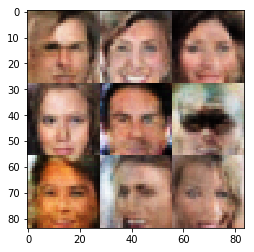

Step: 10110: Epoch 2/2... Discriminator Loss: 0.0789... Generator Loss: 3.2521
Step: 10120: Epoch 2/2... Discriminator Loss: 1.1550... Generator Loss: 5.9450
Step: 10130: Epoch 2/2... Discriminator Loss: 0.9060... Generator Loss: 0.7550
Step: 10140: Epoch 2/2... Discriminator Loss: 1.1477... Generator Loss: 0.5443
Step: 10150: Epoch 2/2... Discriminator Loss: 3.7282... Generator Loss: 0.0530
Step: 10160: Epoch 2/2... Discriminator Loss: 0.5134... Generator Loss: 1.2514
Step: 10170: Epoch 2/2... Discriminator Loss: 2.4527... Generator Loss: 0.1631
Step: 10180: Epoch 2/2... Discriminator Loss: 1.2443... Generator Loss: 0.6835
Step: 10190: Epoch 2/2... Discriminator Loss: 0.1916... Generator Loss: 2.1057
Step: 10200: Epoch 2/2... Discriminator Loss: 0.1465... Generator Loss: 2.6677


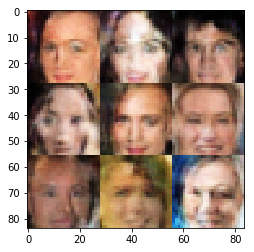

Step: 10210: Epoch 2/2... Discriminator Loss: 2.3890... Generator Loss: 6.0069
Step: 10220: Epoch 2/2... Discriminator Loss: 0.6959... Generator Loss: 1.0105
Step: 10230: Epoch 2/2... Discriminator Loss: 0.6465... Generator Loss: 0.9031
Step: 10240: Epoch 2/2... Discriminator Loss: 0.1626... Generator Loss: 2.7995
Step: 10250: Epoch 2/2... Discriminator Loss: 0.3073... Generator Loss: 1.9398
Step: 10260: Epoch 2/2... Discriminator Loss: 0.3023... Generator Loss: 1.9208
Step: 10270: Epoch 2/2... Discriminator Loss: 0.1159... Generator Loss: 2.9257
Step: 10280: Epoch 2/2... Discriminator Loss: 0.0808... Generator Loss: 3.6187
Step: 10290: Epoch 2/2... Discriminator Loss: 0.1153... Generator Loss: 4.4748
Step: 10300: Epoch 2/2... Discriminator Loss: 0.6263... Generator Loss: 4.9017


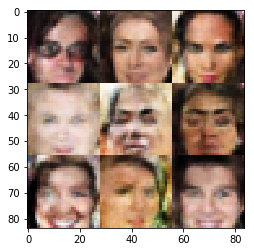

Step: 10310: Epoch 2/2... Discriminator Loss: 0.1943... Generator Loss: 2.2556
Step: 10320: Epoch 2/2... Discriminator Loss: 0.2508... Generator Loss: 1.8901
Step: 10330: Epoch 2/2... Discriminator Loss: 0.6251... Generator Loss: 6.5455
Step: 10340: Epoch 2/2... Discriminator Loss: 0.4706... Generator Loss: 1.2653
Step: 10350: Epoch 2/2... Discriminator Loss: 0.2745... Generator Loss: 1.7416
Step: 10360: Epoch 2/2... Discriminator Loss: 0.1923... Generator Loss: 2.3247
Step: 10370: Epoch 2/2... Discriminator Loss: 0.0864... Generator Loss: 3.1522
Step: 10380: Epoch 2/2... Discriminator Loss: 0.0905... Generator Loss: 3.5015
Step: 10390: Epoch 2/2... Discriminator Loss: 0.1987... Generator Loss: 2.4128
Step: 10400: Epoch 2/2... Discriminator Loss: 0.3121... Generator Loss: 1.6909


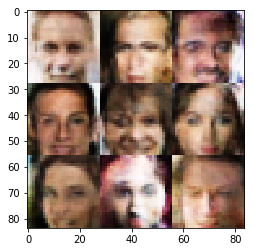

Step: 10410: Epoch 2/2... Discriminator Loss: 0.1404... Generator Loss: 3.2778
Step: 10420: Epoch 2/2... Discriminator Loss: 0.0836... Generator Loss: 3.2014
Step: 10430: Epoch 2/2... Discriminator Loss: 0.1703... Generator Loss: 2.3740
Step: 10440: Epoch 2/2... Discriminator Loss: 0.0769... Generator Loss: 3.0993
Step: 10450: Epoch 2/2... Discriminator Loss: 0.1625... Generator Loss: 2.8507
Step: 10460: Epoch 2/2... Discriminator Loss: 0.2389... Generator Loss: 2.1168
Step: 10470: Epoch 2/2... Discriminator Loss: 0.0515... Generator Loss: 3.9944
Step: 10480: Epoch 2/2... Discriminator Loss: 0.0228... Generator Loss: 5.3101
Step: 10490: Epoch 2/2... Discriminator Loss: 0.0666... Generator Loss: 4.4867
Step: 10500: Epoch 2/2... Discriminator Loss: 0.0585... Generator Loss: 3.8831


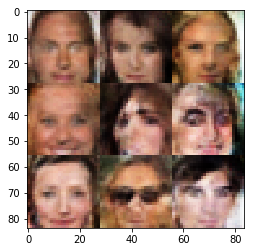

Step: 10510: Epoch 2/2... Discriminator Loss: 0.8570... Generator Loss: 0.8817
Step: 10520: Epoch 2/2... Discriminator Loss: 0.4631... Generator Loss: 1.3260
Step: 10530: Epoch 2/2... Discriminator Loss: 0.0861... Generator Loss: 3.3717
Step: 10540: Epoch 2/2... Discriminator Loss: 0.3794... Generator Loss: 1.5940
Step: 10550: Epoch 2/2... Discriminator Loss: 0.0683... Generator Loss: 3.5275
Step: 10560: Epoch 2/2... Discriminator Loss: 0.2189... Generator Loss: 2.2075
Step: 10570: Epoch 2/2... Discriminator Loss: 0.8027... Generator Loss: 0.8001
Step: 10580: Epoch 2/2... Discriminator Loss: 0.0466... Generator Loss: 5.0992
Step: 10590: Epoch 2/2... Discriminator Loss: 0.2124... Generator Loss: 2.2028
Step: 10600: Epoch 2/2... Discriminator Loss: 0.0939... Generator Loss: 3.1221


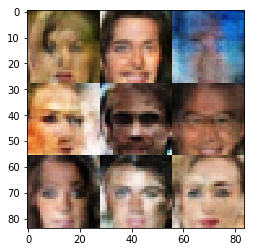

Step: 10610: Epoch 2/2... Discriminator Loss: 0.3376... Generator Loss: 1.5190
Step: 10620: Epoch 2/2... Discriminator Loss: 0.0973... Generator Loss: 2.9720
Step: 10630: Epoch 2/2... Discriminator Loss: 0.2037... Generator Loss: 2.2470
Step: 10640: Epoch 2/2... Discriminator Loss: 0.3943... Generator Loss: 1.4889
Step: 10650: Epoch 2/2... Discriminator Loss: 0.0591... Generator Loss: 3.9334
Step: 10660: Epoch 2/2... Discriminator Loss: 9.5370... Generator Loss: 13.4955
Step: 10670: Epoch 2/2... Discriminator Loss: 0.3588... Generator Loss: 3.0847
Step: 10680: Epoch 2/2... Discriminator Loss: 1.6220... Generator Loss: 0.2944
Step: 10690: Epoch 2/2... Discriminator Loss: 0.4139... Generator Loss: 1.3732
Step: 10700: Epoch 2/2... Discriminator Loss: 0.7713... Generator Loss: 0.9924


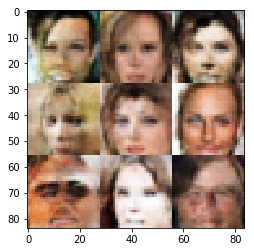

Step: 10710: Epoch 2/2... Discriminator Loss: 0.5004... Generator Loss: 1.4494
Step: 10720: Epoch 2/2... Discriminator Loss: 1.4729... Generator Loss: 4.3168
Step: 10730: Epoch 2/2... Discriminator Loss: 1.2025... Generator Loss: 0.5946
Step: 10740: Epoch 2/2... Discriminator Loss: 0.7050... Generator Loss: 3.9144
Step: 10750: Epoch 2/2... Discriminator Loss: 0.2573... Generator Loss: 2.1994
Step: 10760: Epoch 2/2... Discriminator Loss: 0.1281... Generator Loss: 2.7824
Step: 10770: Epoch 2/2... Discriminator Loss: 0.2103... Generator Loss: 2.2505
Step: 10780: Epoch 2/2... Discriminator Loss: 0.1244... Generator Loss: 2.7525
Step: 10790: Epoch 2/2... Discriminator Loss: 0.3454... Generator Loss: 1.7495
Step: 10800: Epoch 2/2... Discriminator Loss: 0.1613... Generator Loss: 2.8169


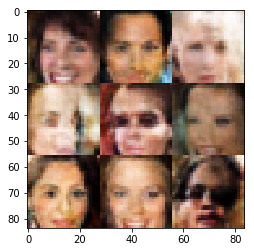

Step: 10810: Epoch 2/2... Discriminator Loss: 0.1272... Generator Loss: 3.1412
Step: 10820: Epoch 2/2... Discriminator Loss: 0.0196... Generator Loss: 5.8987
Step: 10830: Epoch 2/2... Discriminator Loss: 1.7874... Generator Loss: 5.9851
Step: 10840: Epoch 2/2... Discriminator Loss: 0.4626... Generator Loss: 1.5588
Step: 10850: Epoch 2/2... Discriminator Loss: 0.4268... Generator Loss: 1.3733
Step: 10860: Epoch 2/2... Discriminator Loss: 0.1582... Generator Loss: 2.4359
Step: 10870: Epoch 2/2... Discriminator Loss: 0.2167... Generator Loss: 2.1537
Step: 10880: Epoch 2/2... Discriminator Loss: 0.2343... Generator Loss: 1.9965
Step: 10890: Epoch 2/2... Discriminator Loss: 0.1726... Generator Loss: 2.4978
Step: 10900: Epoch 2/2... Discriminator Loss: 0.1576... Generator Loss: 2.4673


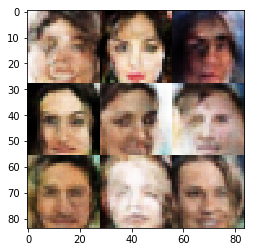

Step: 10910: Epoch 2/2... Discriminator Loss: 0.0793... Generator Loss: 3.4208
Step: 10920: Epoch 2/2... Discriminator Loss: 1.2864... Generator Loss: 0.6234
Step: 10930: Epoch 2/2... Discriminator Loss: 0.2836... Generator Loss: 1.8215
Step: 10940: Epoch 2/2... Discriminator Loss: 0.3804... Generator Loss: 1.4978
Step: 10950: Epoch 2/2... Discriminator Loss: 0.5229... Generator Loss: 1.1598
Step: 10960: Epoch 2/2... Discriminator Loss: 0.1114... Generator Loss: 3.2002
Step: 10970: Epoch 2/2... Discriminator Loss: 0.1116... Generator Loss: 3.0340
Step: 10980: Epoch 2/2... Discriminator Loss: 0.1367... Generator Loss: 2.5942
Step: 10990: Epoch 2/2... Discriminator Loss: 0.0302... Generator Loss: 5.9956
Step: 11000: Epoch 2/2... Discriminator Loss: 0.0746... Generator Loss: 3.5740


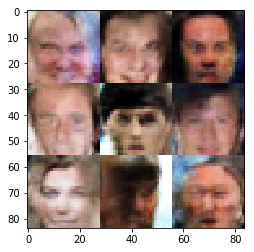

Step: 11010: Epoch 2/2... Discriminator Loss: 0.8897... Generator Loss: 0.6510
Step: 11020: Epoch 2/2... Discriminator Loss: 0.1497... Generator Loss: 2.6183
Step: 11030: Epoch 2/2... Discriminator Loss: 0.1123... Generator Loss: 2.8468
Step: 11040: Epoch 2/2... Discriminator Loss: 0.2190... Generator Loss: 2.0876
Step: 11050: Epoch 2/2... Discriminator Loss: 0.0565... Generator Loss: 5.0319
Step: 11060: Epoch 2/2... Discriminator Loss: 0.1048... Generator Loss: 4.4249
Step: 11070: Epoch 2/2... Discriminator Loss: 0.2666... Generator Loss: 1.7822
Step: 11080: Epoch 2/2... Discriminator Loss: 0.3788... Generator Loss: 1.5322
Step: 11090: Epoch 2/2... Discriminator Loss: 0.1123... Generator Loss: 2.9912
Step: 11100: Epoch 2/2... Discriminator Loss: 0.5599... Generator Loss: 1.0611


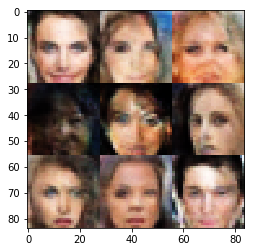

Step: 11110: Epoch 2/2... Discriminator Loss: 0.3185... Generator Loss: 6.2157
Step: 11120: Epoch 2/2... Discriminator Loss: 0.2092... Generator Loss: 2.0954
Step: 11130: Epoch 2/2... Discriminator Loss: 0.0849... Generator Loss: 3.3506
Step: 11140: Epoch 2/2... Discriminator Loss: 0.1573... Generator Loss: 2.8237
Step: 11150: Epoch 2/2... Discriminator Loss: 0.4652... Generator Loss: 7.6190
Step: 11160: Epoch 2/2... Discriminator Loss: 2.1180... Generator Loss: 0.2999
Step: 11170: Epoch 2/2... Discriminator Loss: 0.5334... Generator Loss: 1.8060
Step: 11180: Epoch 2/2... Discriminator Loss: 0.5798... Generator Loss: 1.4169
Step: 11190: Epoch 2/2... Discriminator Loss: 0.7999... Generator Loss: 2.8990
Step: 11200: Epoch 2/2... Discriminator Loss: 0.5618... Generator Loss: 1.1992


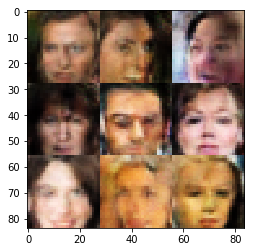

Step: 11210: Epoch 2/2... Discriminator Loss: 0.1728... Generator Loss: 2.4309
Step: 11220: Epoch 2/2... Discriminator Loss: 0.9111... Generator Loss: 0.7550
Step: 11230: Epoch 2/2... Discriminator Loss: 0.2137... Generator Loss: 3.1669
Step: 11240: Epoch 2/2... Discriminator Loss: 0.1936... Generator Loss: 2.6611
Step: 11250: Epoch 2/2... Discriminator Loss: 0.4705... Generator Loss: 3.0715
Step: 11260: Epoch 2/2... Discriminator Loss: 0.1828... Generator Loss: 2.6414
Step: 11270: Epoch 2/2... Discriminator Loss: 0.1377... Generator Loss: 2.5700
Step: 11280: Epoch 2/2... Discriminator Loss: 0.1538... Generator Loss: 2.3550
Step: 11290: Epoch 2/2... Discriminator Loss: 0.0791... Generator Loss: 3.4868
Step: 11300: Epoch 2/2... Discriminator Loss: 0.3748... Generator Loss: 1.6274


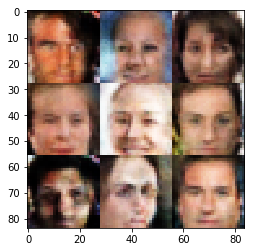

Step: 11310: Epoch 2/2... Discriminator Loss: 0.0348... Generator Loss: 5.3214
Step: 11320: Epoch 2/2... Discriminator Loss: 0.0514... Generator Loss: 4.4238
Step: 11330: Epoch 2/2... Discriminator Loss: 0.3790... Generator Loss: 1.5228
Step: 11340: Epoch 2/2... Discriminator Loss: 0.0961... Generator Loss: 2.9808
Step: 11350: Epoch 2/2... Discriminator Loss: 0.1035... Generator Loss: 4.3552
Step: 11360: Epoch 2/2... Discriminator Loss: 0.1621... Generator Loss: 2.3055
Step: 11370: Epoch 2/2... Discriminator Loss: 0.4415... Generator Loss: 1.4717
Step: 11380: Epoch 2/2... Discriminator Loss: 0.0515... Generator Loss: 3.8494
Step: 11390: Epoch 2/2... Discriminator Loss: 1.0623... Generator Loss: 0.6965
Step: 11400: Epoch 2/2... Discriminator Loss: 0.1600... Generator Loss: 2.4286


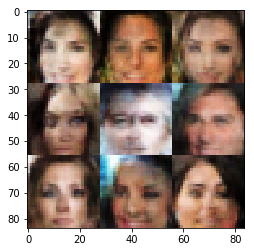

Step: 11410: Epoch 2/2... Discriminator Loss: 0.1035... Generator Loss: 3.0016
Step: 11420: Epoch 2/2... Discriminator Loss: 0.0410... Generator Loss: 4.1474
Step: 11430: Epoch 2/2... Discriminator Loss: 3.4577... Generator Loss: 0.0869
Step: 11440: Epoch 2/2... Discriminator Loss: 0.6156... Generator Loss: 2.0468
Step: 11450: Epoch 2/2... Discriminator Loss: 0.8109... Generator Loss: 0.8538
Step: 11460: Epoch 2/2... Discriminator Loss: 1.7259... Generator Loss: 0.3293
Step: 11470: Epoch 2/2... Discriminator Loss: 0.2518... Generator Loss: 1.9326
Step: 11480: Epoch 2/2... Discriminator Loss: 0.5159... Generator Loss: 1.2783
Step: 11490: Epoch 2/2... Discriminator Loss: 0.0714... Generator Loss: 4.1744
Step: 11500: Epoch 2/2... Discriminator Loss: 0.5593... Generator Loss: 1.1515


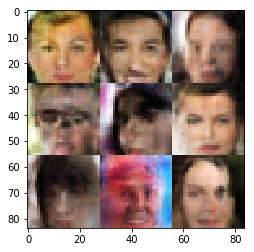

Step: 11510: Epoch 2/2... Discriminator Loss: 0.2105... Generator Loss: 2.2006
Step: 11520: Epoch 2/2... Discriminator Loss: 2.0172... Generator Loss: 0.2202
Step: 11530: Epoch 2/2... Discriminator Loss: 0.3177... Generator Loss: 2.9128
Step: 11540: Epoch 2/2... Discriminator Loss: 0.1637... Generator Loss: 2.2750
Step: 11550: Epoch 2/2... Discriminator Loss: 0.2029... Generator Loss: 2.0718
Step: 11560: Epoch 2/2... Discriminator Loss: 0.1712... Generator Loss: 2.5159
Step: 11570: Epoch 2/2... Discriminator Loss: 0.1590... Generator Loss: 2.4662
Step: 11580: Epoch 2/2... Discriminator Loss: 0.4070... Generator Loss: 1.3993
Step: 11590: Epoch 2/2... Discriminator Loss: 0.2395... Generator Loss: 1.8683
Step: 11600: Epoch 2/2... Discriminator Loss: 0.1813... Generator Loss: 5.8239


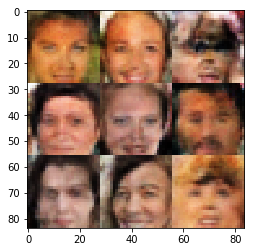

Step: 11610: Epoch 2/2... Discriminator Loss: 0.4821... Generator Loss: 1.3712
Step: 11620: Epoch 2/2... Discriminator Loss: 0.5683... Generator Loss: 1.1640
Step: 11630: Epoch 2/2... Discriminator Loss: 0.8406... Generator Loss: 2.3261
Step: 11640: Epoch 2/2... Discriminator Loss: 0.5148... Generator Loss: 2.5545
Step: 11650: Epoch 2/2... Discriminator Loss: 0.7810... Generator Loss: 0.9617
Step: 11660: Epoch 2/2... Discriminator Loss: 0.7479... Generator Loss: 0.8731
Step: 11670: Epoch 2/2... Discriminator Loss: 0.2233... Generator Loss: 2.0096
Step: 11680: Epoch 2/2... Discriminator Loss: 1.3509... Generator Loss: 5.9429
Step: 11690: Epoch 2/2... Discriminator Loss: 0.2216... Generator Loss: 2.0897
Step: 11700: Epoch 2/2... Discriminator Loss: 0.1834... Generator Loss: 2.5914


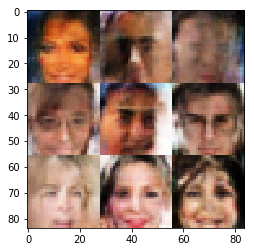

Step: 11710: Epoch 2/2... Discriminator Loss: 0.0453... Generator Loss: 4.6766
Step: 11720: Epoch 2/2... Discriminator Loss: 0.0444... Generator Loss: 4.7747
Step: 11730: Epoch 2/2... Discriminator Loss: 0.1420... Generator Loss: 2.6759
Step: 11740: Epoch 2/2... Discriminator Loss: 1.3054... Generator Loss: 5.7098
Step: 11750: Epoch 2/2... Discriminator Loss: 0.2796... Generator Loss: 1.7549
Step: 11760: Epoch 2/2... Discriminator Loss: 1.9344... Generator Loss: 0.2764
Step: 11770: Epoch 2/2... Discriminator Loss: 3.4778... Generator Loss: 7.4327
Step: 11780: Epoch 2/2... Discriminator Loss: 0.5080... Generator Loss: 2.6167
Step: 11790: Epoch 2/2... Discriminator Loss: 0.3232... Generator Loss: 2.2410
Step: 11800: Epoch 2/2... Discriminator Loss: 0.3076... Generator Loss: 1.8026


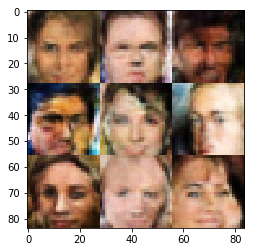

Step: 11810: Epoch 2/2... Discriminator Loss: 0.3228... Generator Loss: 2.0647
Step: 11820: Epoch 2/2... Discriminator Loss: 0.4158... Generator Loss: 1.7275
Step: 11830: Epoch 2/2... Discriminator Loss: 0.4782... Generator Loss: 1.3066
Step: 11840: Epoch 2/2... Discriminator Loss: 0.1405... Generator Loss: 4.5633
Step: 11850: Epoch 2/2... Discriminator Loss: 0.8298... Generator Loss: 0.8717
Step: 11860: Epoch 2/2... Discriminator Loss: 0.2649... Generator Loss: 4.2818
Step: 11870: Epoch 2/2... Discriminator Loss: 0.2819... Generator Loss: 1.8723
Step: 11880: Epoch 2/2... Discriminator Loss: 0.0709... Generator Loss: 3.7652
Step: 11890: Epoch 2/2... Discriminator Loss: 0.4907... Generator Loss: 1.2204
Step: 11900: Epoch 2/2... Discriminator Loss: 0.3875... Generator Loss: 1.3960


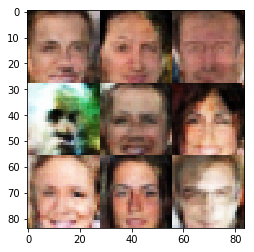

Step: 11910: Epoch 2/2... Discriminator Loss: 1.7726... Generator Loss: 0.2645
Step: 11920: Epoch 2/2... Discriminator Loss: 0.3980... Generator Loss: 1.4335
Step: 11930: Epoch 2/2... Discriminator Loss: 0.1360... Generator Loss: 2.6061
Step: 11940: Epoch 2/2... Discriminator Loss: 0.1933... Generator Loss: 3.6461
Step: 11950: Epoch 2/2... Discriminator Loss: 0.1770... Generator Loss: 2.3858
Step: 11960: Epoch 2/2... Discriminator Loss: 0.2396... Generator Loss: 2.0153
Step: 11970: Epoch 2/2... Discriminator Loss: 0.1338... Generator Loss: 2.8615
Step: 11980: Epoch 2/2... Discriminator Loss: 0.1803... Generator Loss: 2.3299
Step: 11990: Epoch 2/2... Discriminator Loss: 0.0298... Generator Loss: 6.2377
Step: 12000: Epoch 2/2... Discriminator Loss: 0.3966... Generator Loss: 1.4715


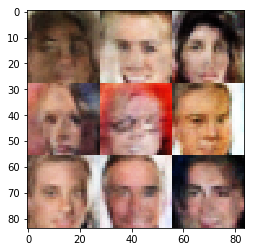

Step: 12010: Epoch 2/2... Discriminator Loss: 0.1596... Generator Loss: 3.3319
Step: 12020: Epoch 2/2... Discriminator Loss: 0.2094... Generator Loss: 2.1985
Step: 12030: Epoch 2/2... Discriminator Loss: 1.8956... Generator Loss: 0.3002
Step: 12040: Epoch 2/2... Discriminator Loss: 0.4832... Generator Loss: 2.3634
Step: 12050: Epoch 2/2... Discriminator Loss: 0.3491... Generator Loss: 2.2038
Step: 12060: Epoch 2/2... Discriminator Loss: 0.5485... Generator Loss: 1.2166
Step: 12070: Epoch 2/2... Discriminator Loss: 0.8423... Generator Loss: 0.9201
Step: 12080: Epoch 2/2... Discriminator Loss: 0.3039... Generator Loss: 1.9634
Step: 12090: Epoch 2/2... Discriminator Loss: 0.0419... Generator Loss: 4.7027
Step: 12100: Epoch 2/2... Discriminator Loss: 1.7072... Generator Loss: 0.3829


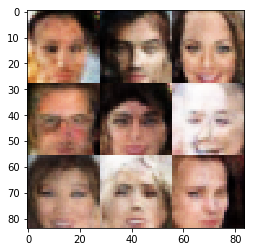

Step: 12110: Epoch 2/2... Discriminator Loss: 0.5068... Generator Loss: 1.4314
Step: 12120: Epoch 2/2... Discriminator Loss: 0.3341... Generator Loss: 1.7813
Step: 12130: Epoch 2/2... Discriminator Loss: 1.1805... Generator Loss: 0.4726
Step: 12140: Epoch 2/2... Discriminator Loss: 0.1216... Generator Loss: 2.9600
Step: 12150: Epoch 2/2... Discriminator Loss: 0.0806... Generator Loss: 3.5475
Step: 12160: Epoch 2/2... Discriminator Loss: 0.0773... Generator Loss: 3.3467
Step: 12170: Epoch 2/2... Discriminator Loss: 0.2060... Generator Loss: 2.1835
Step: 12180: Epoch 2/2... Discriminator Loss: 0.2087... Generator Loss: 2.2555
Step: 12190: Epoch 2/2... Discriminator Loss: 0.0679... Generator Loss: 3.7986
Step: 12200: Epoch 2/2... Discriminator Loss: 0.0816... Generator Loss: 3.1746


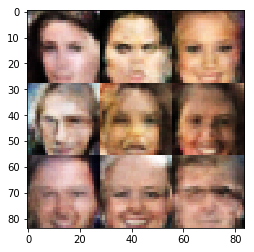

Step: 12210: Epoch 2/2... Discriminator Loss: 0.3002... Generator Loss: 1.8030
Step: 12220: Epoch 2/2... Discriminator Loss: 2.3259... Generator Loss: 0.2288
Step: 12230: Epoch 2/2... Discriminator Loss: 0.5662... Generator Loss: 1.1169
Step: 12240: Epoch 2/2... Discriminator Loss: 0.5877... Generator Loss: 1.1254
Step: 12250: Epoch 2/2... Discriminator Loss: 0.2447... Generator Loss: 2.4615
Step: 12260: Epoch 2/2... Discriminator Loss: 0.0688... Generator Loss: 3.4271
Step: 12270: Epoch 2/2... Discriminator Loss: 0.1154... Generator Loss: 7.4417
Step: 12280: Epoch 2/2... Discriminator Loss: 0.5395... Generator Loss: 2.0477
Step: 12290: Epoch 2/2... Discriminator Loss: 0.7817... Generator Loss: 3.4733
Step: 12300: Epoch 2/2... Discriminator Loss: 0.1856... Generator Loss: 2.2129


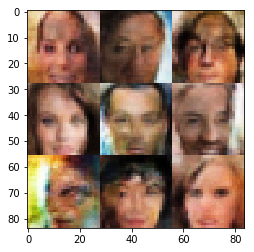

Step: 12310: Epoch 2/2... Discriminator Loss: 0.1471... Generator Loss: 2.3987
Step: 12320: Epoch 2/2... Discriminator Loss: 0.2014... Generator Loss: 2.1385
Step: 12330: Epoch 2/2... Discriminator Loss: 0.1171... Generator Loss: 2.8842
Step: 12340: Epoch 2/2... Discriminator Loss: 0.4573... Generator Loss: 1.2904
Step: 12350: Epoch 2/2... Discriminator Loss: 0.1501... Generator Loss: 2.4831
Step: 12360: Epoch 2/2... Discriminator Loss: 0.1440... Generator Loss: 2.5781
Step: 12370: Epoch 2/2... Discriminator Loss: 0.3161... Generator Loss: 1.6799
Step: 12380: Epoch 2/2... Discriminator Loss: 1.1046... Generator Loss: 0.6622
Step: 12390: Epoch 2/2... Discriminator Loss: 0.2933... Generator Loss: 1.7948
Step: 12400: Epoch 2/2... Discriminator Loss: 0.0385... Generator Loss: 5.0158


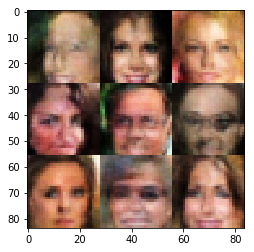

Step: 12410: Epoch 2/2... Discriminator Loss: 0.5732... Generator Loss: 1.0054
Step: 12420: Epoch 2/2... Discriminator Loss: 0.1843... Generator Loss: 2.2227
Step: 12430: Epoch 2/2... Discriminator Loss: 1.0461... Generator Loss: 0.6574
Step: 12440: Epoch 2/2... Discriminator Loss: 0.3665... Generator Loss: 1.7270
Step: 12450: Epoch 2/2... Discriminator Loss: 0.3460... Generator Loss: 1.8762
Step: 12460: Epoch 2/2... Discriminator Loss: 0.0857... Generator Loss: 3.1079
Step: 12470: Epoch 2/2... Discriminator Loss: 0.1277... Generator Loss: 3.0649
Step: 12480: Epoch 2/2... Discriminator Loss: 0.2900... Generator Loss: 1.8567
Step: 12490: Epoch 2/2... Discriminator Loss: 0.1127... Generator Loss: 2.7644
Step: 12500: Epoch 2/2... Discriminator Loss: 0.4096... Generator Loss: 1.3395


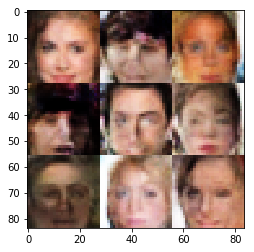

Step: 12510: Epoch 2/2... Discriminator Loss: 0.0342... Generator Loss: 4.5865
Step: 12520: Epoch 2/2... Discriminator Loss: 0.0410... Generator Loss: 4.4834
Step: 12530: Epoch 2/2... Discriminator Loss: 0.0691... Generator Loss: 3.5861
Step: 12540: Epoch 2/2... Discriminator Loss: 0.8704... Generator Loss: 0.8319
Step: 12550: Epoch 2/2... Discriminator Loss: 0.4395... Generator Loss: 1.3685
Step: 12560: Epoch 2/2... Discriminator Loss: 0.1336... Generator Loss: 2.7863
Step: 12570: Epoch 2/2... Discriminator Loss: 0.6417... Generator Loss: 1.0330
Step: 12580: Epoch 2/2... Discriminator Loss: 0.6900... Generator Loss: 1.0627
Step: 12590: Epoch 2/2... Discriminator Loss: 0.2021... Generator Loss: 2.1939
Step: 12600: Epoch 2/2... Discriminator Loss: 0.4590... Generator Loss: 1.2112


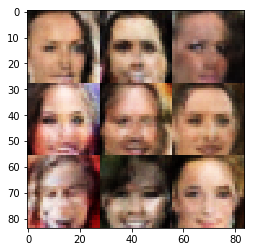

Step: 12610: Epoch 2/2... Discriminator Loss: 0.1318... Generator Loss: 2.6807
Step: 12620: Epoch 2/2... Discriminator Loss: 0.2489... Generator Loss: 1.8487
Step: 12630: Epoch 2/2... Discriminator Loss: 0.4382... Generator Loss: 3.1786
Step: 12640: Epoch 2/2... Discriminator Loss: 0.2017... Generator Loss: 2.6154
Step: 12650: Epoch 2/2... Discriminator Loss: 0.0761... Generator Loss: 3.5405
Step: 12660: Epoch 2/2... Discriminator Loss: 0.1291... Generator Loss: 2.7753
Training finished


In [51]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.